In [55]:
from scipy.stats import entropy

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import tensorflow
# https://github.com/tensorflow/tensorflow/issues/46038
config = tensorflow.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tensorflow.compat.v1.Session(config=config)

In [27]:
# machinelearningmastery.com/how-to-develop-an-information-maximizing-generative-adversarial-network-infogan-in-keras/

# example of training an infogan on mnist
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy import hstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Activation

# define the standalone discriminator model
def define_discriminator(n_cat, in_shape=(28,28,1)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.1)(d)
    # downsample to 7x7
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.1)(d)
    d = BatchNormalization()(d)
    # normal
    d = Conv2D(256, (4,4), padding='same', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.1)(d)
    d = BatchNormalization()(d)
    # flatten feature maps
    d = Flatten()(d)
    # real/fake output
    out_classifier = Dense(1, activation='sigmoid')(d)
    # define d model
    d_model = Model(in_image, out_classifier)
    # compile d model
    d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    # create q model layers
    q = Dense(128)(d)
    q = BatchNormalization()(q)
    q = LeakyReLU(alpha=0.1)(q)
    # q model output
    out_codes = Dense(n_cat, activation='softmax')(q)
    # define q model
    q_model = Model(in_image, out_codes)
    return d_model, q_model

# define the standalone generator model
def define_generator(gen_input_size):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image generator input
    in_lat = Input(shape=(gen_input_size,))
    # foundation for 7x7 image
    n_nodes = 512 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = BatchNormalization()(gen)
    gen = Reshape((7, 7, 512))(gen)
    # normal
    gen = Conv2D(128, (4,4), padding='same', kernel_initializer=init)(gen)
    gen = Activation('relu')(gen)
    gen = BatchNormalization()(gen)
    # upsample to 14x14
    gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = Activation('relu')(gen)
    gen = BatchNormalization()(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    # tanh output
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model(in_lat, out_layer)
    return model

# define the combined discriminator, generator and q network model
def define_gan(g_model, d_model, q_model):
    # make weights in the discriminator (some shared with the q model) as not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect g outputs to d inputs
    d_output = d_model(g_model.output)
    # connect g outputs to q inputs
    q_output = q_model(g_model.output)
    # define composite model
    model = Model(g_model.input, [d_output, q_output])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape)
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images and labels
    X = dataset[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_cat, n_samples):
    # generate points in the latent space
    z_latent = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_latent = z_latent.reshape(n_samples, latent_dim)
    # generate categorical codes
    cat_codes = randint(0, n_cat, n_samples)
    # one hot encode
    cat_codes = to_categorical(cat_codes, num_classes=n_cat)
    # concatenate latent points and control codes
    z_input = hstack((z_latent, cat_codes))
    return [z_input, cat_codes]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_cat, n_samples):
    # generate points in latent space and control codes
    z_input, _ = generate_latent_points(latent_dim, n_cat, n_samples)
    # predict outputs
    images = generator.predict(z_input)
    # create class labels
    y = zeros((n_samples, 1))
    return images, y

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_cat, n_epochs=100, n_batch=256):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator and q model weights
        d_loss1 = d_model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_cat, half_batch)
        # update discriminator model weights
        d_loss2 = d_model.train_on_batch(X_fake, y_fake)
        # prepare points in latent space as input for the generator
        z_input, cat_codes = generate_latent_points(latent_dim, n_cat, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the g via the d and q error
        _,g_1,g_2 = gan_model.train_on_batch(z_input, [y_gan, cat_codes])
        # summarize loss on this batch
        print('>%d/%d, d[%.3f,%.3f], g[%.3f] q[%.3f]' % (i+1, n_steps, d_loss1, d_loss2, g_1, g_2))

# number of values for the categorical control code
n_cat = 10
# size of the latent space
latent_dim = 128
# create the discriminator
d_model, q_model = define_discriminator(n_cat)
# create the generator
gen_input_size = latent_dim + n_cat
g_model = define_generator(gen_input_size)
# create the gan
gan_model = define_gan(g_model, d_model, q_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_cat)

(60000, 28, 28, 1)
>1/23400, d[1.836,0.845], g[0.646] q[2.708]
>2/23400, d[0.000,0.541], g[0.675] q[2.539]
>3/23400, d[0.000,0.384], g[0.687] q[2.707]
>4/23400, d[0.000,0.285], g[0.635] q[2.513]
>5/23400, d[0.000,0.204], g[0.620] q[2.476]
>6/23400, d[0.000,0.139], g[0.616] q[2.436]
>7/23400, d[0.000,0.092], g[0.544] q[2.386]
>8/23400, d[0.000,0.065], g[0.494] q[2.357]
>9/23400, d[0.000,0.044], g[0.508] q[2.236]
>10/23400, d[0.000,0.033], g[0.425] q[2.148]
>11/23400, d[0.000,0.027], g[0.338] q[2.213]
>12/23400, d[0.000,0.022], g[0.312] q[2.154]
>13/23400, d[0.000,0.018], g[0.316] q[2.121]
>14/23400, d[0.000,0.015], g[0.271] q[2.022]
>15/23400, d[0.000,0.012], g[0.258] q[1.918]
>16/23400, d[0.000,0.009], g[0.233] q[1.956]
>17/23400, d[0.000,0.009], g[0.228] q[1.859]
>18/23400, d[0.000,0.007], g[0.213] q[1.775]
>19/23400, d[0.000,0.007], g[0.206] q[1.795]
>20/23400, d[0.000,0.006], g[0.166] q[1.669]
>21/23400, d[0.001,0.005], g[0.190] q[1.596]
>22/23400, d[0.000,0.004], g[0.171] q[1.668]


>183/23400, d[0.000,0.000], g[0.003] q[0.022]
>184/23400, d[0.000,0.000], g[0.004] q[0.018]
>185/23400, d[0.000,0.000], g[0.003] q[0.016]
>186/23400, d[0.000,0.000], g[0.004] q[0.017]
>187/23400, d[0.000,0.000], g[0.004] q[0.018]
>188/23400, d[0.000,0.000], g[0.003] q[0.017]
>189/23400, d[0.000,0.000], g[0.003] q[0.018]
>190/23400, d[0.000,0.000], g[0.003] q[0.015]
>191/23400, d[0.000,0.000], g[0.003] q[0.017]
>192/23400, d[0.000,0.000], g[0.003] q[0.018]
>193/23400, d[0.000,0.000], g[0.003] q[0.017]
>194/23400, d[0.000,0.000], g[0.004] q[0.022]
>195/23400, d[0.000,0.000], g[0.003] q[0.015]
>196/23400, d[0.000,0.000], g[0.003] q[0.013]
>197/23400, d[0.000,0.000], g[0.003] q[0.020]
>198/23400, d[0.000,0.000], g[0.003] q[0.018]
>199/23400, d[0.000,0.000], g[0.003] q[0.014]
>200/23400, d[0.000,0.000], g[0.003] q[0.018]
>201/23400, d[0.000,0.000], g[0.003] q[0.016]
>202/23400, d[0.000,0.000], g[0.003] q[0.016]
>203/23400, d[0.000,0.000], g[0.003] q[0.016]
>204/23400, d[0.000,0.000], g[0.00

>363/23400, d[0.001,0.000], g[0.010] q[0.007]
>364/23400, d[0.000,0.000], g[0.013] q[0.008]
>365/23400, d[0.000,0.000], g[0.014] q[0.007]
>366/23400, d[0.000,0.000], g[0.015] q[0.007]
>367/23400, d[0.000,0.000], g[0.015] q[0.008]
>368/23400, d[0.000,0.000], g[0.013] q[0.005]
>369/23400, d[0.000,0.000], g[0.012] q[0.008]
>370/23400, d[0.000,0.000], g[0.020] q[0.007]
>371/23400, d[0.001,0.000], g[0.017] q[0.007]
>372/23400, d[0.000,0.001], g[0.021] q[0.008]
>373/23400, d[0.001,0.000], g[0.020] q[0.007]
>374/23400, d[0.000,0.001], g[0.024] q[0.007]
>375/23400, d[0.001,0.001], g[0.019] q[0.007]
>376/23400, d[0.000,0.000], g[0.025] q[0.010]
>377/23400, d[0.001,0.001], g[0.028] q[0.006]
>378/23400, d[0.001,0.000], g[0.015] q[0.011]
>379/23400, d[0.000,0.001], g[0.025] q[0.007]
>380/23400, d[0.001,0.001], g[0.030] q[0.010]
>381/23400, d[0.001,0.002], g[0.096] q[0.008]
>382/23400, d[0.022,15.207], g[22.466] q[0.019]
>383/23400, d[26.034,6.594], g[3.159] q[0.048]
>384/23400, d[2.188,0.039], g[0

>541/23400, d[0.002,0.016], g[4.573] q[0.193]
>542/23400, d[0.006,0.013], g[4.407] q[0.233]
>543/23400, d[0.015,0.017], g[4.046] q[0.191]
>544/23400, d[0.007,0.013], g[3.888] q[0.205]
>545/23400, d[0.012,0.026], g[3.596] q[0.226]
>546/23400, d[0.015,0.035], g[4.217] q[0.199]
>547/23400, d[0.033,0.016], g[3.650] q[0.255]
>548/23400, d[0.010,0.027], g[3.968] q[0.219]
>549/23400, d[0.023,0.042], g[4.831] q[0.317]
>550/23400, d[0.027,0.012], g[4.342] q[0.258]
>551/23400, d[0.019,0.033], g[4.263] q[0.262]
>552/23400, d[0.023,0.024], g[4.403] q[0.226]
>553/23400, d[0.026,0.019], g[3.863] q[0.213]
>554/23400, d[0.009,0.028], g[4.816] q[0.235]
>555/23400, d[0.028,0.010], g[3.847] q[0.261]
>556/23400, d[0.006,0.015], g[3.940] q[0.233]
>557/23400, d[0.005,0.010], g[4.115] q[0.194]
>558/23400, d[0.006,0.033], g[5.463] q[0.206]
>559/23400, d[0.034,0.018], g[4.560] q[0.206]
>560/23400, d[0.014,0.024], g[4.806] q[0.231]
>561/23400, d[0.016,0.044], g[6.386] q[0.229]
>562/23400, d[0.059,0.020], g[4.38

>721/23400, d[0.356,0.080], g[3.263] q[0.054]
>722/23400, d[0.123,0.149], g[2.929] q[0.097]
>723/23400, d[0.128,0.182], g[3.860] q[0.068]
>724/23400, d[0.317,0.343], g[3.515] q[0.075]
>725/23400, d[0.246,0.126], g[2.889] q[0.070]
>726/23400, d[0.113,0.238], g[4.190] q[0.062]
>727/23400, d[0.320,0.271], g[3.374] q[0.078]
>728/23400, d[0.194,0.129], g[3.341] q[0.047]
>729/23400, d[0.143,0.162], g[3.596] q[0.059]
>730/23400, d[0.163,0.171], g[3.556] q[0.083]
>731/23400, d[0.264,0.426], g[5.046] q[0.086]
>732/23400, d[0.511,0.460], g[3.910] q[0.053]
>733/23400, d[0.426,0.406], g[4.065] q[0.070]
>734/23400, d[0.311,0.187], g[3.289] q[0.093]
>735/23400, d[0.188,0.199], g[3.662] q[0.081]
>736/23400, d[0.153,0.135], g[3.745] q[0.105]
>737/23400, d[0.157,0.153], g[3.648] q[0.063]
>738/23400, d[0.180,0.214], g[3.717] q[0.074]
>739/23400, d[0.250,0.273], g[3.650] q[0.099]
>740/23400, d[0.230,0.184], g[3.546] q[0.066]
>741/23400, d[0.143,0.159], g[3.990] q[0.070]
>742/23400, d[0.219,0.272], g[4.04

>901/23400, d[0.409,0.499], g[3.404] q[0.112]
>902/23400, d[0.258,0.213], g[3.952] q[0.115]
>903/23400, d[0.432,0.574], g[3.116] q[0.086]
>904/23400, d[0.264,0.123], g[3.064] q[0.063]
>905/23400, d[0.142,0.181], g[2.939] q[0.066]
>906/23400, d[0.150,0.207], g[3.400] q[0.052]
>907/23400, d[0.214,0.183], g[2.992] q[0.071]
>908/23400, d[0.148,0.194], g[3.475] q[0.103]
>909/23400, d[0.247,0.209], g[2.858] q[0.065]
>910/23400, d[0.182,0.166], g[2.792] q[0.118]
>911/23400, d[0.136,0.165], g[3.226] q[0.091]
>912/23400, d[0.195,0.232], g[3.612] q[0.072]
>913/23400, d[0.237,0.255], g[3.613] q[0.088]
>914/23400, d[0.179,0.167], g[3.453] q[0.071]
>915/23400, d[0.222,0.191], g[3.145] q[0.072]
>916/23400, d[0.186,0.199], g[3.172] q[0.094]
>917/23400, d[0.143,0.176], g[3.660] q[0.073]
>918/23400, d[0.247,0.216], g[2.958] q[0.109]
>919/23400, d[0.113,0.117], g[3.468] q[0.116]
>920/23400, d[0.147,0.167], g[3.384] q[0.100]
>921/23400, d[0.154,0.150], g[3.440] q[0.068]
>922/23400, d[0.283,0.327], g[3.29

>1079/23400, d[0.111,0.261], g[4.142] q[0.058]
>1080/23400, d[0.418,0.511], g[3.767] q[0.108]
>1081/23400, d[0.287,0.073], g[3.933] q[0.048]
>1082/23400, d[0.256,0.589], g[4.095] q[0.093]
>1083/23400, d[0.273,0.047], g[3.946] q[0.084]
>1084/23400, d[0.259,0.416], g[2.945] q[0.078]
>1085/23400, d[0.153,0.067], g[3.208] q[0.100]
>1086/23400, d[0.151,0.143], g[2.988] q[0.068]
>1087/23400, d[0.091,0.161], g[4.023] q[0.078]
>1088/23400, d[0.191,0.137], g[3.038] q[0.107]
>1089/23400, d[0.161,0.181], g[3.029] q[0.074]
>1090/23400, d[0.058,0.105], g[3.789] q[0.052]
>1091/23400, d[0.182,0.121], g[3.002] q[0.128]
>1092/23400, d[0.101,0.098], g[3.144] q[0.085]
>1093/23400, d[0.074,0.102], g[3.603] q[0.109]
>1094/23400, d[0.126,0.081], g[2.535] q[0.096]
>1095/23400, d[0.068,0.154], g[3.455] q[0.071]
>1096/23400, d[0.142,0.122], g[3.471] q[0.138]
>1097/23400, d[0.173,0.206], g[3.264] q[0.079]
>1098/23400, d[0.093,0.084], g[3.721] q[0.112]
>1099/23400, d[0.113,0.098], g[3.319] q[0.111]
>1100/23400, 

>1255/23400, d[0.451,0.307], g[2.565] q[0.037]
>1256/23400, d[0.330,0.425], g[2.945] q[0.061]
>1257/23400, d[0.301,0.248], g[2.808] q[0.069]
>1258/23400, d[0.419,0.392], g[2.421] q[0.074]
>1259/23400, d[0.216,0.269], g[3.011] q[0.039]
>1260/23400, d[0.318,0.322], g[3.119] q[0.111]
>1261/23400, d[0.357,0.252], g[2.490] q[0.083]
>1262/23400, d[0.222,0.392], g[3.024] q[0.041]
>1263/23400, d[0.295,0.207], g[3.000] q[0.059]
>1264/23400, d[0.264,0.251], g[2.555] q[0.061]
>1265/23400, d[0.129,0.219], g[3.222] q[0.062]
>1266/23400, d[0.304,0.206], g[2.684] q[0.050]
>1267/23400, d[0.142,0.191], g[3.092] q[0.050]
>1268/23400, d[0.207,0.214], g[3.125] q[0.076]
>1269/23400, d[0.232,0.227], g[3.195] q[0.073]
>1270/23400, d[0.176,0.200], g[3.181] q[0.064]
>1271/23400, d[0.181,0.259], g[3.060] q[0.048]
>1272/23400, d[0.181,0.140], g[3.272] q[0.050]
>1273/23400, d[0.136,0.177], g[3.407] q[0.042]
>1274/23400, d[0.157,0.156], g[3.192] q[0.081]
>1275/23400, d[0.144,0.151], g[2.991] q[0.063]
>1276/23400, 

>1430/23400, d[0.163,0.360], g[4.327] q[0.084]
>1431/23400, d[0.142,0.041], g[4.744] q[0.090]
>1432/23400, d[0.191,0.080], g[3.255] q[0.075]
>1433/23400, d[0.040,0.138], g[4.121] q[0.129]
>1434/23400, d[0.156,0.206], g[3.614] q[0.104]
>1435/23400, d[0.097,0.074], g[4.254] q[0.111]
>1436/23400, d[0.182,0.138], g[2.792] q[0.104]
>1437/23400, d[0.031,0.094], g[3.511] q[0.084]
>1438/23400, d[0.173,0.108], g[3.189] q[0.103]
>1439/23400, d[0.042,0.124], g[4.201] q[0.126]
>1440/23400, d[0.183,0.139], g[3.280] q[0.088]
>1441/23400, d[0.103,0.107], g[4.022] q[0.089]
>1442/23400, d[0.144,0.213], g[3.449] q[0.096]
>1443/23400, d[0.079,0.047], g[4.475] q[0.132]
>1444/23400, d[0.110,0.052], g[2.864] q[0.127]
>1445/23400, d[0.065,0.123], g[3.559] q[0.087]
>1446/23400, d[0.048,0.063], g[4.264] q[0.090]
>1447/23400, d[0.228,0.188], g[3.400] q[0.137]
>1448/23400, d[0.240,0.462], g[6.027] q[0.110]
>1449/23400, d[0.548,0.199], g[2.631] q[0.099]
>1450/23400, d[0.253,0.573], g[3.903] q[0.123]
>1451/23400, 

>1605/23400, d[0.089,0.165], g[4.050] q[0.098]
>1606/23400, d[0.076,0.068], g[4.218] q[0.100]
>1607/23400, d[0.196,0.244], g[5.064] q[0.098]
>1608/23400, d[0.296,0.350], g[4.729] q[0.090]
>1609/23400, d[0.609,0.477], g[3.162] q[0.064]
>1610/23400, d[0.255,0.260], g[3.921] q[0.067]
>1611/23400, d[0.205,0.106], g[3.205] q[0.111]
>1612/23400, d[0.156,0.180], g[3.581] q[0.077]
>1613/23400, d[0.089,0.114], g[4.376] q[0.072]
>1614/23400, d[0.142,0.063], g[2.665] q[0.128]
>1615/23400, d[0.038,0.203], g[4.321] q[0.093]
>1616/23400, d[0.259,0.090], g[3.134] q[0.037]
>1617/23400, d[0.063,0.104], g[3.511] q[0.108]
>1618/23400, d[0.020,0.059], g[4.351] q[0.087]
>1619/23400, d[0.140,0.132], g[3.558] q[0.054]
>1620/23400, d[0.074,0.097], g[4.243] q[0.101]
>1621/23400, d[0.075,0.062], g[4.145] q[0.079]
>1622/23400, d[0.095,0.092], g[3.357] q[0.085]
>1623/23400, d[0.088,0.103], g[3.309] q[0.066]
>1624/23400, d[0.054,0.102], g[4.564] q[0.050]
>1625/23400, d[0.163,0.099], g[3.459] q[0.084]
>1626/23400, 

>1780/23400, d[0.214,0.265], g[3.033] q[0.065]
>1781/23400, d[0.394,0.498], g[3.390] q[0.101]
>1782/23400, d[0.476,0.496], g[3.339] q[0.096]
>1783/23400, d[0.340,0.302], g[3.070] q[0.060]
>1784/23400, d[0.277,0.418], g[3.929] q[0.064]
>1785/23400, d[0.317,0.240], g[3.572] q[0.064]
>1786/23400, d[0.194,0.281], g[4.213] q[0.022]
>1787/23400, d[0.295,0.145], g[2.845] q[0.028]
>1788/23400, d[0.066,0.275], g[4.491] q[0.054]
>1789/23400, d[0.255,0.081], g[3.035] q[0.053]
>1790/23400, d[0.096,0.215], g[3.578] q[0.042]
>1791/23400, d[0.163,0.100], g[3.241] q[0.050]
>1792/23400, d[0.072,0.092], g[3.058] q[0.093]
>1793/23400, d[0.077,0.160], g[4.161] q[0.082]
>1794/23400, d[0.169,0.157], g[4.029] q[0.069]
>1795/23400, d[0.089,0.049], g[4.029] q[0.062]
>1796/23400, d[0.149,0.190], g[3.427] q[0.050]
>1797/23400, d[0.062,0.066], g[4.212] q[0.067]
>1798/23400, d[0.135,0.196], g[4.372] q[0.093]
>1799/23400, d[0.133,0.065], g[3.994] q[0.064]
>1800/23400, d[0.214,0.251], g[3.526] q[0.064]
>1801/23400, 

>1956/23400, d[0.092,0.043], g[4.032] q[0.094]
>1957/23400, d[0.110,0.099], g[3.909] q[0.058]
>1958/23400, d[0.078,0.096], g[4.220] q[0.059]
>1959/23400, d[0.054,0.070], g[3.894] q[0.056]
>1960/23400, d[0.115,0.080], g[3.500] q[0.061]
>1961/23400, d[0.055,0.147], g[4.338] q[0.092]
>1962/23400, d[0.106,0.049], g[3.501] q[0.053]
>1963/23400, d[0.042,0.057], g[4.091] q[0.024]
>1964/23400, d[0.068,0.093], g[4.523] q[0.040]
>1965/23400, d[0.065,0.051], g[4.438] q[0.079]
>1966/23400, d[0.116,0.159], g[4.373] q[0.072]
>1967/23400, d[0.114,0.061], g[3.092] q[0.071]
>1968/23400, d[0.054,0.051], g[3.518] q[0.060]
>1969/23400, d[0.029,0.041], g[3.817] q[0.059]
>1970/23400, d[0.032,0.059], g[3.680] q[0.059]
>1971/23400, d[0.048,0.070], g[4.537] q[0.093]
>1972/23400, d[0.118,0.118], g[3.819] q[0.067]
>1973/23400, d[0.064,0.047], g[4.108] q[0.057]
>1974/23400, d[0.123,0.192], g[4.372] q[0.042]
>1975/23400, d[0.180,0.072], g[3.735] q[0.029]
>1976/23400, d[0.048,0.110], g[4.492] q[0.094]
>1977/23400, 

>2132/23400, d[0.035,0.131], g[3.660] q[0.065]
>2133/23400, d[0.041,0.023], g[3.923] q[0.056]
>2134/23400, d[0.204,0.194], g[3.435] q[0.123]
>2135/23400, d[0.035,0.072], g[5.243] q[0.057]
>2136/23400, d[0.256,0.217], g[3.627] q[0.052]
>2137/23400, d[0.189,0.212], g[3.802] q[0.061]
>2138/23400, d[0.116,0.069], g[3.608] q[0.056]
>2139/23400, d[0.072,0.098], g[3.886] q[0.056]
>2140/23400, d[0.071,0.065], g[3.835] q[0.068]
>2141/23400, d[0.073,0.073], g[3.631] q[0.043]
>2142/23400, d[0.084,0.093], g[3.643] q[0.039]
>2143/23400, d[0.029,0.052], g[3.873] q[0.040]
>2144/23400, d[0.100,0.069], g[3.456] q[0.051]
>2145/23400, d[0.058,0.150], g[4.431] q[0.047]
>2146/23400, d[0.070,0.022], g[4.158] q[0.086]
>2147/23400, d[0.128,0.106], g[3.451] q[0.045]
>2148/23400, d[0.040,0.053], g[3.262] q[0.109]
>2149/23400, d[0.048,0.116], g[4.794] q[0.049]
>2150/23400, d[0.226,0.162], g[3.648] q[0.059]
>2151/23400, d[0.091,0.099], g[3.830] q[0.046]
>2152/23400, d[0.109,0.155], g[4.192] q[0.044]
>2153/23400, 

>2307/23400, d[0.049,0.062], g[4.085] q[0.045]
>2308/23400, d[0.039,0.053], g[4.072] q[0.034]
>2309/23400, d[0.051,0.067], g[4.209] q[0.032]
>2310/23400, d[0.047,0.040], g[4.803] q[0.059]
>2311/23400, d[0.033,0.030], g[4.010] q[0.035]
>2312/23400, d[0.063,0.042], g[3.801] q[0.043]
>2313/23400, d[0.044,0.172], g[5.151] q[0.023]
>2314/23400, d[0.285,0.092], g[3.487] q[0.065]
>2315/23400, d[0.179,0.711], g[7.002] q[0.039]
>2316/23400, d[1.350,1.121], g[5.694] q[0.051]
>2317/23400, d[0.724,0.357], g[3.858] q[0.071]
>2318/23400, d[0.143,0.228], g[4.446] q[0.059]
>2319/23400, d[0.365,0.447], g[4.265] q[0.058]
>2320/23400, d[0.261,0.107], g[3.964] q[0.019]
>2321/23400, d[0.146,0.187], g[3.850] q[0.038]
>2322/23400, d[0.076,0.060], g[3.743] q[0.028]
>2323/23400, d[0.149,0.221], g[4.205] q[0.091]
>2324/23400, d[0.250,0.171], g[3.012] q[0.066]
>2325/23400, d[0.068,0.129], g[4.359] q[0.039]
>2326/23400, d[0.125,0.083], g[3.696] q[0.054]
>2327/23400, d[0.073,0.078], g[3.856] q[0.051]
>2328/23400, 

>2483/23400, d[1.241,0.519], g[3.681] q[0.069]
>2484/23400, d[0.082,0.040], g[4.923] q[0.076]
>2485/23400, d[0.452,1.263], g[7.939] q[0.066]
>2486/23400, d[2.398,1.250], g[6.026] q[0.037]
>2487/23400, d[2.083,2.584], g[3.488] q[0.085]
>2488/23400, d[0.628,0.286], g[3.276] q[0.051]
>2489/23400, d[0.608,0.892], g[3.555] q[0.042]
>2490/23400, d[0.378,0.148], g[3.287] q[0.089]
>2491/23400, d[0.197,0.275], g[3.246] q[0.051]
>2492/23400, d[0.174,0.166], g[3.297] q[0.047]
>2493/23400, d[0.448,0.589], g[3.153] q[0.053]
>2494/23400, d[0.209,0.214], g[4.368] q[0.050]
>2495/23400, d[0.554,0.521], g[3.066] q[0.073]
>2496/23400, d[0.215,0.181], g[3.487] q[0.099]
>2497/23400, d[0.315,0.486], g[4.055] q[0.062]
>2498/23400, d[0.478,0.333], g[3.347] q[0.089]
>2499/23400, d[0.121,0.146], g[3.295] q[0.086]
>2500/23400, d[0.110,0.083], g[3.677] q[0.047]
>2501/23400, d[0.185,0.329], g[4.503] q[0.075]
>2502/23400, d[0.142,0.067], g[4.065] q[0.056]
>2503/23400, d[0.146,0.161], g[3.305] q[0.041]
>2504/23400, 

>2659/23400, d[0.425,0.234], g[2.284] q[0.047]
>2660/23400, d[0.100,0.225], g[3.262] q[0.089]
>2661/23400, d[0.115,0.107], g[3.765] q[0.073]
>2662/23400, d[0.307,0.563], g[4.345] q[0.057]
>2663/23400, d[0.470,0.212], g[3.150] q[0.086]
>2664/23400, d[0.244,0.466], g[4.096] q[0.067]
>2665/23400, d[0.363,0.124], g[3.032] q[0.021]
>2666/23400, d[0.160,0.263], g[3.045] q[0.048]
>2667/23400, d[0.195,0.169], g[3.444] q[0.049]
>2668/23400, d[0.134,0.175], g[3.738] q[0.053]
>2669/23400, d[0.263,0.185], g[2.535] q[0.053]
>2670/23400, d[0.132,0.214], g[2.947] q[0.032]
>2671/23400, d[0.117,0.120], g[3.191] q[0.060]
>2672/23400, d[0.130,0.157], g[3.587] q[0.020]
>2673/23400, d[0.118,0.157], g[3.994] q[0.076]
>2674/23400, d[0.211,0.220], g[3.313] q[0.039]
>2675/23400, d[0.122,0.103], g[3.462] q[0.047]
>2676/23400, d[0.152,0.208], g[3.572] q[0.048]
>2677/23400, d[0.122,0.109], g[3.863] q[0.074]
>2678/23400, d[0.086,0.076], g[3.452] q[0.061]
>2679/23400, d[0.138,0.099], g[3.115] q[0.056]
>2680/23400, 

>2834/23400, d[0.062,0.063], g[4.041] q[0.062]
>2835/23400, d[0.052,0.024], g[3.965] q[0.096]
>2836/23400, d[0.137,0.274], g[4.655] q[0.060]
>2837/23400, d[0.085,0.030], g[4.795] q[0.068]
>2838/23400, d[0.116,0.056], g[3.631] q[0.081]
>2839/23400, d[0.032,0.056], g[3.962] q[0.043]
>2840/23400, d[0.063,0.060], g[3.427] q[0.040]
>2841/23400, d[0.046,0.083], g[4.155] q[0.065]
>2842/23400, d[0.040,0.032], g[4.190] q[0.059]
>2843/23400, d[0.058,0.040], g[3.450] q[0.067]
>2844/23400, d[0.045,0.058], g[3.660] q[0.048]
>2845/23400, d[0.038,0.027], g[3.272] q[0.069]
>2846/23400, d[0.046,0.229], g[5.472] q[0.089]
>2847/23400, d[0.238,0.031], g[3.559] q[0.043]
>2848/23400, d[0.023,0.087], g[3.692] q[0.059]
>2849/23400, d[0.057,0.092], g[4.321] q[0.049]
>2850/23400, d[0.103,0.113], g[4.360] q[0.063]
>2851/23400, d[0.219,0.181], g[4.081] q[0.046]
>2852/23400, d[0.189,0.250], g[3.499] q[0.100]
>2853/23400, d[0.186,0.111], g[3.713] q[0.044]
>2854/23400, d[0.040,0.039], g[4.109] q[0.046]
>2855/23400, 

>3010/23400, d[0.155,0.230], g[3.151] q[0.063]
>3011/23400, d[0.231,0.316], g[3.638] q[0.052]
>3012/23400, d[0.415,0.277], g[2.512] q[0.065]
>3013/23400, d[0.082,0.188], g[3.514] q[0.046]
>3014/23400, d[0.251,0.273], g[3.650] q[0.076]
>3015/23400, d[0.176,0.142], g[3.153] q[0.046]
>3016/23400, d[0.199,0.228], g[2.805] q[0.058]
>3017/23400, d[0.169,0.189], g[3.379] q[0.034]
>3018/23400, d[0.212,0.163], g[2.684] q[0.059]
>3019/23400, d[0.099,0.266], g[4.139] q[0.064]
>3020/23400, d[0.388,0.216], g[2.772] q[0.059]
>3021/23400, d[0.092,0.208], g[3.819] q[0.041]
>3022/23400, d[0.212,0.175], g[3.675] q[0.047]
>3023/23400, d[0.228,0.198], g[2.727] q[0.081]
>3024/23400, d[0.101,0.213], g[3.390] q[0.063]
>3025/23400, d[0.186,0.113], g[3.309] q[0.081]
>3026/23400, d[0.106,0.182], g[3.452] q[0.047]
>3027/23400, d[0.113,0.203], g[4.328] q[0.076]
>3028/23400, d[0.280,0.117], g[3.225] q[0.056]
>3029/23400, d[0.118,0.259], g[3.260] q[0.056]
>3030/23400, d[0.187,0.148], g[3.318] q[0.019]
>3031/23400, 

>3186/23400, d[0.029,0.077], g[3.824] q[0.049]
>3187/23400, d[0.092,0.080], g[3.378] q[0.061]
>3188/23400, d[0.038,0.115], g[4.563] q[0.052]
>3189/23400, d[0.077,0.023], g[3.679] q[0.069]
>3190/23400, d[0.110,0.181], g[4.163] q[0.045]
>3191/23400, d[0.066,0.016], g[4.390] q[0.043]
>3192/23400, d[0.058,0.058], g[4.115] q[0.062]
>3193/23400, d[0.039,0.028], g[3.856] q[0.053]
>3194/23400, d[0.058,0.125], g[4.111] q[0.049]
>3195/23400, d[0.224,0.095], g[2.819] q[0.074]
>3196/23400, d[0.031,0.132], g[4.692] q[0.071]
>3197/23400, d[0.132,0.124], g[3.342] q[0.030]
>3198/23400, d[0.038,0.070], g[4.427] q[0.030]
>3199/23400, d[0.079,0.035], g[3.916] q[0.039]
>3200/23400, d[0.069,0.103], g[3.801] q[0.040]
>3201/23400, d[0.091,0.064], g[3.339] q[0.039]
>3202/23400, d[0.040,0.111], g[4.343] q[0.052]
>3203/23400, d[0.075,0.038], g[4.385] q[0.060]
>3204/23400, d[0.167,0.274], g[4.703] q[0.044]
>3205/23400, d[0.342,0.133], g[3.893] q[0.057]
>3206/23400, d[0.731,2.749], g[6.674] q[0.037]
>3207/23400, 

>3362/23400, d[0.314,0.269], g[2.664] q[0.045]
>3363/23400, d[0.207,0.215], g[3.312] q[0.063]
>3364/23400, d[0.168,0.150], g[2.793] q[0.061]
>3365/23400, d[0.191,0.164], g[2.674] q[0.035]
>3366/23400, d[0.100,0.170], g[3.138] q[0.063]
>3367/23400, d[0.246,0.264], g[3.044] q[0.061]
>3368/23400, d[0.141,0.190], g[3.644] q[0.043]
>3369/23400, d[0.258,0.288], g[3.391] q[0.091]
>3370/23400, d[0.319,0.356], g[3.180] q[0.070]
>3371/23400, d[0.132,0.112], g[3.705] q[0.071]
>3372/23400, d[0.231,0.230], g[2.557] q[0.058]
>3373/23400, d[0.119,0.190], g[3.731] q[0.058]
>3374/23400, d[0.242,0.158], g[2.406] q[0.030]
>3375/23400, d[0.075,0.278], g[3.819] q[0.050]
>3376/23400, d[0.150,0.066], g[4.092] q[0.038]
>3377/23400, d[0.268,0.185], g[2.441] q[0.023]
>3378/23400, d[0.078,0.178], g[3.083] q[0.071]
>3379/23400, d[0.090,0.058], g[3.383] q[0.072]
>3380/23400, d[0.113,0.166], g[2.952] q[0.035]
>3381/23400, d[0.156,0.110], g[2.926] q[0.049]
>3382/23400, d[0.050,0.129], g[3.468] q[0.029]
>3383/23400, 

>3538/23400, d[0.053,0.134], g[3.985] q[0.065]
>3539/23400, d[0.171,0.097], g[3.128] q[0.064]
>3540/23400, d[0.052,0.087], g[3.214] q[0.074]
>3541/23400, d[0.102,0.044], g[2.821] q[0.033]
>3542/23400, d[0.067,0.112], g[2.716] q[0.060]
>3543/23400, d[0.051,0.218], g[3.680] q[0.063]
>3544/23400, d[0.226,0.052], g[3.456] q[0.055]
>3545/23400, d[0.134,0.215], g[3.155] q[0.076]
>3546/23400, d[0.081,0.106], g[4.347] q[0.042]
>3547/23400, d[0.152,0.114], g[3.648] q[0.032]
>3548/23400, d[0.057,0.102], g[4.244] q[0.039]
>3549/23400, d[0.241,0.126], g[2.589] q[0.048]
>3550/23400, d[0.037,0.203], g[4.655] q[0.064]
>3551/23400, d[0.395,0.133], g[2.765] q[0.096]
>3552/23400, d[0.207,0.261], g[2.710] q[0.037]
>3553/23400, d[0.286,0.578], g[4.352] q[0.047]
>3554/23400, d[0.633,0.331], g[2.611] q[0.050]
>3555/23400, d[0.143,0.307], g[3.534] q[0.054]
>3556/23400, d[0.371,0.288], g[2.930] q[0.065]
>3557/23400, d[0.136,0.120], g[3.034] q[0.065]
>3558/23400, d[0.116,0.185], g[3.397] q[0.024]
>3559/23400, 

>3714/23400, d[0.876,0.564], g[2.264] q[0.029]
>3715/23400, d[0.055,0.166], g[3.963] q[0.070]
>3716/23400, d[0.453,0.462], g[2.879] q[0.029]
>3717/23400, d[0.125,0.105], g[3.354] q[0.054]
>3718/23400, d[0.125,0.142], g[3.255] q[0.023]
>3719/23400, d[0.180,0.191], g[3.038] q[0.050]
>3720/23400, d[0.106,0.138], g[3.350] q[0.042]
>3721/23400, d[0.243,0.169], g[2.342] q[0.039]
>3722/23400, d[0.065,0.115], g[2.906] q[0.034]
>3723/23400, d[0.138,0.215], g[3.213] q[0.043]
>3724/23400, d[0.125,0.052], g[3.115] q[0.053]
>3725/23400, d[0.180,0.245], g[2.880] q[0.074]
>3726/23400, d[0.078,0.125], g[3.475] q[0.060]
>3727/23400, d[0.155,0.093], g[2.855] q[0.035]
>3728/23400, d[0.145,0.140], g[2.344] q[0.033]
>3729/23400, d[0.030,0.146], g[4.049] q[0.035]
>3730/23400, d[0.147,0.070], g[3.223] q[0.014]
>3731/23400, d[0.106,0.201], g[3.740] q[0.032]
>3732/23400, d[0.217,0.206], g[3.535] q[0.046]
>3733/23400, d[0.114,0.117], g[3.674] q[0.053]
>3734/23400, d[0.262,0.387], g[3.986] q[0.070]
>3735/23400, 

>3889/23400, d[0.350,0.372], g[2.801] q[0.041]
>3890/23400, d[0.292,0.206], g[2.289] q[0.051]
>3891/23400, d[0.156,0.248], g[2.605] q[0.043]
>3892/23400, d[0.294,0.361], g[3.041] q[0.062]
>3893/23400, d[0.525,0.694], g[3.098] q[0.045]
>3894/23400, d[0.485,0.376], g[2.717] q[0.031]
>3895/23400, d[0.379,0.350], g[2.418] q[0.080]
>3896/23400, d[0.257,0.261], g[2.213] q[0.073]
>3897/23400, d[0.237,0.272], g[2.922] q[0.038]
>3898/23400, d[0.417,0.538], g[3.106] q[0.084]
>3899/23400, d[0.421,0.244], g[2.347] q[0.051]
>3900/23400, d[0.183,0.394], g[3.194] q[0.061]
>3901/23400, d[0.318,0.214], g[2.866] q[0.029]
>3902/23400, d[0.228,0.183], g[2.400] q[0.030]
>3903/23400, d[0.205,0.249], g[2.610] q[0.084]
>3904/23400, d[0.158,0.393], g[3.444] q[0.088]
>3905/23400, d[0.476,0.263], g[2.702] q[0.040]
>3906/23400, d[0.208,0.300], g[3.323] q[0.037]
>3907/23400, d[0.353,0.299], g[2.314] q[0.042]
>3908/23400, d[0.156,0.253], g[2.904] q[0.054]
>3909/23400, d[0.257,0.152], g[2.623] q[0.028]
>3910/23400, 

>4064/23400, d[0.299,0.161], g[2.225] q[0.042]
>4065/23400, d[0.037,0.156], g[3.547] q[0.030]
>4066/23400, d[0.335,0.362], g[3.588] q[0.050]
>4067/23400, d[0.376,0.414], g[3.384] q[0.021]
>4068/23400, d[0.192,0.167], g[3.569] q[0.072]
>4069/23400, d[0.188,0.243], g[3.675] q[0.013]
>4070/23400, d[0.302,0.140], g[2.688] q[0.050]
>4071/23400, d[0.056,0.145], g[3.455] q[0.024]
>4072/23400, d[0.094,0.070], g[3.244] q[0.030]
>4073/23400, d[0.142,0.127], g[2.891] q[0.058]
>4074/23400, d[0.101,0.184], g[3.181] q[0.052]
>4075/23400, d[0.089,0.085], g[3.588] q[0.027]
>4076/23400, d[0.226,0.208], g[2.936] q[0.043]
>4077/23400, d[0.072,0.144], g[3.342] q[0.064]
>4078/23400, d[0.297,0.468], g[4.420] q[0.036]
>4079/23400, d[0.665,0.363], g[2.656] q[0.036]
>4080/23400, d[0.223,0.171], g[2.359] q[0.045]
>4081/23400, d[0.080,0.352], g[4.375] q[0.010]
>4082/23400, d[0.399,0.138], g[2.559] q[0.026]
>4083/23400, d[0.089,0.249], g[3.418] q[0.035]
>4084/23400, d[0.330,0.247], g[2.949] q[0.044]
>4085/23400, 

>4239/23400, d[0.223,0.061], g[2.784] q[0.042]
>4240/23400, d[0.096,0.110], g[2.939] q[0.031]
>4241/23400, d[0.058,0.160], g[3.636] q[0.054]
>4242/23400, d[0.124,0.083], g[3.319] q[0.033]
>4243/23400, d[0.145,0.181], g[3.011] q[0.052]
>4244/23400, d[0.083,0.180], g[3.592] q[0.049]
>4245/23400, d[0.291,0.139], g[2.552] q[0.045]
>4246/23400, d[0.091,0.153], g[2.816] q[0.029]
>4247/23400, d[0.106,0.238], g[3.481] q[0.047]
>4248/23400, d[0.201,0.153], g[3.624] q[0.100]
>4249/23400, d[0.222,0.213], g[3.078] q[0.052]
>4250/23400, d[0.164,0.258], g[3.805] q[0.050]
>4251/23400, d[0.093,0.045], g[3.364] q[0.032]
>4252/23400, d[0.282,0.224], g[2.975] q[0.036]
>4253/23400, d[0.086,0.135], g[3.048] q[0.050]
>4254/23400, d[0.144,0.185], g[3.103] q[0.035]
>4255/23400, d[0.095,0.071], g[3.511] q[0.033]
>4256/23400, d[0.137,0.203], g[3.153] q[0.037]
>4257/23400, d[0.169,0.251], g[4.007] q[0.050]
>4258/23400, d[0.204,0.145], g[3.912] q[0.059]
>4259/23400, d[0.176,0.137], g[2.866] q[0.031]
>4260/23400, 

>4414/23400, d[0.842,0.462], g[2.311] q[0.111]
>4415/23400, d[0.165,0.381], g[3.986] q[0.055]
>4416/23400, d[0.709,0.678], g[3.329] q[0.037]
>4417/23400, d[0.280,0.135], g[2.993] q[0.079]
>4418/23400, d[0.170,0.465], g[4.457] q[0.039]
>4419/23400, d[0.944,0.686], g[2.633] q[0.076]
>4420/23400, d[0.103,0.117], g[3.690] q[0.076]
>4421/23400, d[0.221,0.089], g[2.803] q[0.056]
>4422/23400, d[0.155,0.448], g[3.548] q[0.041]
>4423/23400, d[0.262,0.076], g[3.161] q[0.067]
>4424/23400, d[0.074,0.140], g[3.662] q[0.058]
>4425/23400, d[0.078,0.093], g[3.537] q[0.047]
>4426/23400, d[0.188,0.131], g[2.572] q[0.032]
>4427/23400, d[0.063,0.131], g[2.846] q[0.043]
>4428/23400, d[0.225,0.256], g[2.903] q[0.057]
>4429/23400, d[0.068,0.096], g[3.262] q[0.045]
>4430/23400, d[0.334,0.356], g[2.878] q[0.095]
>4431/23400, d[0.050,0.088], g[3.875] q[0.040]
>4432/23400, d[0.228,0.220], g[3.024] q[0.069]
>4433/23400, d[0.119,0.141], g[3.172] q[0.040]
>4434/23400, d[0.073,0.114], g[4.038] q[0.027]
>4435/23400, 

>4589/23400, d[0.061,0.081], g[2.847] q[0.054]
>4590/23400, d[0.052,0.148], g[4.238] q[0.034]
>4591/23400, d[0.136,0.131], g[3.659] q[0.045]
>4592/23400, d[0.234,0.188], g[2.756] q[0.016]
>4593/23400, d[0.049,0.034], g[3.338] q[0.038]
>4594/23400, d[0.057,0.094], g[3.262] q[0.034]
>4595/23400, d[0.063,0.060], g[3.382] q[0.085]
>4596/23400, d[0.055,0.049], g[2.782] q[0.034]
>4597/23400, d[0.056,0.170], g[3.465] q[0.047]
>4598/23400, d[0.232,0.180], g[3.617] q[0.034]
>4599/23400, d[0.054,0.045], g[3.598] q[0.035]
>4600/23400, d[0.162,0.220], g[3.518] q[0.078]
>4601/23400, d[0.120,0.046], g[3.232] q[0.049]
>4602/23400, d[0.090,0.193], g[3.738] q[0.035]
>4603/23400, d[0.112,0.084], g[3.592] q[0.058]
>4604/23400, d[0.108,0.037], g[2.918] q[0.048]
>4605/23400, d[0.029,0.130], g[3.565] q[0.040]
>4606/23400, d[0.062,0.056], g[3.729] q[0.044]
>4607/23400, d[0.099,0.085], g[3.384] q[0.029]
>4608/23400, d[0.044,0.093], g[3.706] q[0.031]
>4609/23400, d[0.150,0.157], g[3.840] q[0.076]
>4610/23400, 

>4764/23400, d[0.074,0.071], g[3.061] q[0.034]
>4765/23400, d[0.112,0.098], g[3.045] q[0.052]
>4766/23400, d[0.083,0.084], g[3.373] q[0.050]
>4767/23400, d[0.043,0.107], g[3.796] q[0.030]
>4768/23400, d[0.131,0.068], g[3.144] q[0.040]
>4769/23400, d[0.063,0.108], g[3.381] q[0.027]
>4770/23400, d[0.051,0.067], g[4.263] q[0.044]
>4771/23400, d[0.185,0.310], g[4.734] q[0.029]
>4772/23400, d[0.218,0.054], g[3.212] q[0.039]
>4773/23400, d[0.054,0.092], g[3.078] q[0.033]
>4774/23400, d[0.038,0.063], g[3.758] q[0.048]
>4775/23400, d[0.068,0.079], g[3.599] q[0.053]
>4776/23400, d[0.152,0.197], g[3.326] q[0.065]
>4777/23400, d[0.104,0.056], g[3.378] q[0.059]
>4778/23400, d[0.066,0.089], g[3.561] q[0.063]
>4779/23400, d[0.220,0.303], g[3.879] q[0.048]
>4780/23400, d[0.059,0.030], g[4.494] q[0.034]
>4781/23400, d[0.297,0.216], g[2.352] q[0.036]
>4782/23400, d[0.053,0.183], g[4.839] q[0.012]
>4783/23400, d[0.085,0.046], g[3.966] q[0.056]
>4784/23400, d[0.230,0.248], g[4.139] q[0.028]
>4785/23400, 

>4940/23400, d[0.141,0.033], g[4.215] q[0.036]
>4941/23400, d[0.101,0.060], g[2.719] q[0.026]
>4942/23400, d[0.031,0.089], g[3.047] q[0.043]
>4943/23400, d[0.048,0.098], g[4.256] q[0.022]
>4944/23400, d[0.110,0.055], g[3.476] q[0.022]
>4945/23400, d[0.040,0.044], g[3.148] q[0.069]
>4946/23400, d[0.118,0.094], g[2.675] q[0.059]
>4947/23400, d[0.008,0.089], g[3.446] q[0.039]
>4948/23400, d[0.075,0.063], g[3.481] q[0.049]
>4949/23400, d[0.061,0.065], g[3.192] q[0.059]
>4950/23400, d[0.060,0.063], g[3.537] q[0.083]
>4951/23400, d[0.053,0.108], g[4.827] q[0.049]
>4952/23400, d[0.172,0.100], g[2.769] q[0.082]
>4953/23400, d[0.038,0.105], g[3.692] q[0.039]
>4954/23400, d[0.152,0.342], g[5.325] q[0.035]
>4955/23400, d[0.870,0.802], g[6.717] q[0.029]
>4956/23400, d[2.138,4.274], g[4.817] q[0.074]
>4957/23400, d[1.117,0.394], g[2.566] q[0.037]
>4958/23400, d[0.144,0.205], g[2.640] q[0.085]
>4959/23400, d[0.174,0.091], g[2.862] q[0.069]
>4960/23400, d[0.102,0.151], g[2.851] q[0.063]
>4961/23400, 

>5115/23400, d[0.027,0.084], g[3.044] q[0.059]
>5116/23400, d[0.046,0.046], g[3.414] q[0.032]
>5117/23400, d[0.073,0.132], g[3.739] q[0.037]
>5118/23400, d[0.230,0.136], g[2.192] q[0.047]
>5119/23400, d[0.029,0.135], g[3.819] q[0.058]
>5120/23400, d[0.133,0.098], g[3.343] q[0.040]
>5121/23400, d[0.065,0.057], g[3.508] q[0.036]
>5122/23400, d[0.152,0.243], g[3.536] q[0.042]
>5123/23400, d[0.060,0.053], g[4.339] q[0.024]
>5124/23400, d[0.197,0.138], g[2.945] q[0.041]
>5125/23400, d[0.036,0.067], g[3.351] q[0.097]
>5126/23400, d[0.097,0.139], g[3.619] q[0.039]
>5127/23400, d[0.080,0.062], g[3.598] q[0.033]
>5128/23400, d[0.165,0.082], g[2.352] q[0.032]
>5129/23400, d[0.021,0.344], g[5.186] q[0.066]
>5130/23400, d[0.702,0.734], g[5.068] q[0.070]
>5131/23400, d[0.352,0.077], g[2.933] q[0.016]
>5132/23400, d[0.146,0.437], g[4.029] q[0.031]
>5133/23400, d[0.207,0.086], g[4.161] q[0.038]
>5134/23400, d[0.253,0.149], g[2.101] q[0.076]
>5135/23400, d[0.043,0.213], g[3.663] q[0.034]
>5136/23400, 

>5291/23400, d[0.058,0.014], g[4.663] q[0.045]
>5292/23400, d[0.158,0.110], g[3.110] q[0.052]
>5293/23400, d[0.085,0.185], g[3.719] q[0.034]
>5294/23400, d[0.104,0.056], g[4.176] q[0.030]
>5295/23400, d[0.168,0.176], g[3.522] q[0.031]
>5296/23400, d[0.061,0.135], g[4.017] q[0.060]
>5297/23400, d[0.110,0.031], g[3.254] q[0.034]
>5298/23400, d[0.054,0.124], g[3.759] q[0.034]
>5299/23400, d[0.103,0.087], g[3.144] q[0.029]
>5300/23400, d[0.101,0.077], g[2.686] q[0.026]
>5301/23400, d[0.019,0.051], g[3.417] q[0.034]
>5302/23400, d[0.172,0.087], g[1.475] q[0.066]
>5303/23400, d[0.008,0.178], g[3.460] q[0.064]
>5304/23400, d[0.151,0.035], g[2.986] q[0.054]
>5305/23400, d[0.074,0.318], g[4.895] q[0.033]
>5306/23400, d[0.183,0.018], g[3.685] q[0.042]
>5307/23400, d[0.213,0.390], g[4.049] q[0.030]
>5308/23400, d[0.074,0.015], g[5.028] q[0.018]
>5309/23400, d[0.380,0.201], g[2.452] q[0.048]
>5310/23400, d[0.033,0.152], g[3.682] q[0.029]
>5311/23400, d[0.056,0.102], g[4.228] q[0.026]
>5312/23400, 

>5467/23400, d[0.167,0.151], g[3.615] q[0.040]
>5468/23400, d[0.062,0.056], g[3.342] q[0.023]
>5469/23400, d[0.129,0.172], g[3.435] q[0.066]
>5470/23400, d[0.195,0.236], g[3.582] q[0.028]
>5471/23400, d[0.129,0.050], g[3.007] q[0.032]
>5472/23400, d[0.050,0.102], g[2.705] q[0.044]
>5473/23400, d[0.104,0.089], g[3.029] q[0.045]
>5474/23400, d[0.031,0.154], g[4.125] q[0.032]
>5475/23400, d[0.216,0.108], g[3.031] q[0.033]
>5476/23400, d[0.063,0.036], g[2.825] q[0.028]
>5477/23400, d[0.037,0.138], g[3.198] q[0.055]
>5478/23400, d[0.119,0.048], g[3.275] q[0.027]
>5479/23400, d[0.029,0.046], g[2.890] q[0.030]
>5480/23400, d[0.071,0.146], g[3.716] q[0.048]
>5481/23400, d[0.128,0.036], g[2.511] q[0.038]
>5482/23400, d[0.042,0.179], g[3.744] q[0.024]
>5483/23400, d[0.080,0.068], g[3.593] q[0.022]
>5484/23400, d[0.144,0.071], g[3.038] q[0.019]
>5485/23400, d[0.050,0.063], g[2.694] q[0.018]
>5486/23400, d[0.045,0.146], g[3.843] q[0.031]
>5487/23400, d[0.104,0.048], g[3.795] q[0.053]
>5488/23400, 

>5642/23400, d[0.161,0.164], g[2.331] q[0.034]
>5643/23400, d[0.049,0.147], g[3.622] q[0.010]
>5644/23400, d[0.126,0.065], g[3.306] q[0.018]
>5645/23400, d[0.067,0.084], g[3.690] q[0.023]
>5646/23400, d[0.073,0.080], g[3.827] q[0.020]
>5647/23400, d[0.143,0.108], g[2.824] q[0.041]
>5648/23400, d[0.077,0.135], g[3.367] q[0.037]
>5649/23400, d[0.189,0.210], g[3.535] q[0.056]
>5650/23400, d[0.081,0.141], g[4.498] q[0.017]
>5651/23400, d[0.330,0.272], g[2.844] q[0.047]
>5652/23400, d[0.078,0.120], g[3.690] q[0.034]
>5653/23400, d[0.174,0.118], g[3.630] q[0.017]
>5654/23400, d[0.051,0.130], g[4.374] q[0.054]
>5655/23400, d[0.390,0.561], g[3.899] q[0.036]
>5656/23400, d[0.209,0.054], g[3.045] q[0.032]
>5657/23400, d[0.081,0.123], g[3.787] q[0.072]
>5658/23400, d[0.170,0.082], g[2.519] q[0.034]
>5659/23400, d[0.075,0.164], g[3.140] q[0.019]
>5660/23400, d[0.037,0.116], g[4.860] q[0.035]
>5661/23400, d[0.339,0.188], g[2.409] q[0.045]
>5662/23400, d[0.076,0.137], g[3.065] q[0.033]
>5663/23400, 

>5817/23400, d[0.123,0.065], g[3.167] q[0.028]
>5818/23400, d[0.138,0.246], g[3.285] q[0.037]
>5819/23400, d[0.117,0.077], g[3.058] q[0.061]
>5820/23400, d[0.042,0.082], g[3.912] q[0.020]
>5821/23400, d[0.170,0.104], g[2.519] q[0.030]
>5822/23400, d[0.087,0.207], g[3.570] q[0.063]
>5823/23400, d[0.118,0.133], g[3.627] q[0.073]
>5824/23400, d[0.228,0.114], g[2.397] q[0.024]
>5825/23400, d[0.105,0.238], g[3.039] q[0.029]
>5826/23400, d[0.242,0.286], g[3.577] q[0.055]
>5827/23400, d[0.291,0.202], g[2.672] q[0.021]
>5828/23400, d[0.064,0.135], g[3.626] q[0.047]
>5829/23400, d[0.158,0.122], g[3.092] q[0.038]
>5830/23400, d[0.143,0.146], g[2.727] q[0.024]
>5831/23400, d[0.078,0.096], g[2.999] q[0.027]
>5832/23400, d[0.075,0.139], g[4.071] q[0.059]
>5833/23400, d[0.148,0.116], g[3.451] q[0.026]
>5834/23400, d[0.177,0.161], g[2.820] q[0.042]
>5835/23400, d[0.080,0.072], g[3.066] q[0.019]
>5836/23400, d[0.044,0.102], g[3.659] q[0.019]
>5837/23400, d[0.154,0.181], g[3.766] q[0.038]
>5838/23400, 

>5993/23400, d[0.578,1.558], g[4.348] q[0.120]
>5994/23400, d[2.219,2.124], g[3.335] q[0.103]
>5995/23400, d[1.216,0.942], g[2.918] q[0.109]
>5996/23400, d[0.639,0.319], g[2.040] q[0.075]
>5997/23400, d[0.296,0.461], g[2.834] q[0.064]
>5998/23400, d[0.966,1.468], g[3.210] q[0.061]
>5999/23400, d[0.926,0.626], g[2.452] q[0.060]
>6000/23400, d[0.593,0.502], g[2.220] q[0.107]
>6001/23400, d[0.409,0.335], g[2.587] q[0.056]
>6002/23400, d[0.417,0.712], g[2.796] q[0.042]
>6003/23400, d[0.399,0.191], g[2.758] q[0.056]
>6004/23400, d[0.815,0.983], g[2.045] q[0.069]
>6005/23400, d[0.306,0.319], g[2.449] q[0.068]
>6006/23400, d[0.299,0.264], g[2.927] q[0.065]
>6007/23400, d[0.606,0.796], g[2.502] q[0.065]
>6008/23400, d[0.486,0.453], g[2.480] q[0.049]
>6009/23400, d[0.506,0.403], g[2.108] q[0.056]
>6010/23400, d[0.185,0.282], g[2.846] q[0.062]
>6011/23400, d[0.497,0.376], g[2.243] q[0.037]
>6012/23400, d[0.256,0.276], g[2.368] q[0.042]
>6013/23400, d[0.226,0.256], g[2.373] q[0.082]
>6014/23400, 

>6169/23400, d[0.235,0.230], g[2.809] q[0.028]
>6170/23400, d[0.103,0.281], g[4.475] q[0.053]
>6171/23400, d[0.645,0.471], g[2.227] q[0.027]
>6172/23400, d[0.052,0.104], g[3.229] q[0.010]
>6173/23400, d[0.123,0.075], g[3.297] q[0.023]
>6174/23400, d[0.179,0.320], g[3.672] q[0.063]
>6175/23400, d[0.371,0.278], g[2.995] q[0.023]
>6176/23400, d[0.119,0.155], g[3.619] q[0.025]
>6177/23400, d[0.336,0.260], g[2.341] q[0.034]
>6178/23400, d[0.049,0.055], g[2.790] q[0.007]
>6179/23400, d[0.103,0.269], g[3.677] q[0.031]
>6180/23400, d[0.156,0.053], g[3.386] q[0.047]
>6181/23400, d[0.348,0.331], g[2.272] q[0.022]
>6182/23400, d[0.047,0.141], g[3.538] q[0.029]
>6183/23400, d[0.142,0.106], g[3.213] q[0.034]
>6184/23400, d[0.183,0.131], g[2.980] q[0.027]
>6185/23400, d[0.069,0.163], g[3.221] q[0.056]
>6186/23400, d[0.180,0.239], g[3.542] q[0.031]
>6187/23400, d[0.398,0.416], g[3.175] q[0.039]
>6188/23400, d[0.134,0.048], g[3.456] q[0.018]
>6189/23400, d[0.164,0.135], g[2.903] q[0.015]
>6190/23400, 

>6344/23400, d[0.500,0.417], g[2.974] q[0.034]
>6345/23400, d[0.040,0.024], g[3.632] q[0.042]
>6346/23400, d[0.261,0.198], g[2.809] q[0.057]
>6347/23400, d[0.252,0.780], g[4.780] q[0.021]
>6348/23400, d[0.603,0.216], g[3.295] q[0.023]
>6349/23400, d[0.311,0.376], g[2.856] q[0.042]
>6350/23400, d[0.199,0.147], g[2.764] q[0.027]
>6351/23400, d[0.137,0.209], g[3.533] q[0.048]
>6352/23400, d[0.286,0.297], g[3.314] q[0.052]
>6353/23400, d[0.254,0.184], g[2.289] q[0.037]
>6354/23400, d[0.078,0.102], g[2.995] q[0.030]
>6355/23400, d[0.091,0.125], g[3.083] q[0.040]
>6356/23400, d[0.281,0.441], g[4.065] q[0.026]
>6357/23400, d[0.267,0.095], g[2.908] q[0.045]
>6358/23400, d[0.099,0.283], g[4.432] q[0.044]
>6359/23400, d[0.448,0.372], g[3.094] q[0.044]
>6360/23400, d[0.092,0.074], g[2.824] q[0.029]
>6361/23400, d[0.150,0.226], g[3.639] q[0.043]
>6362/23400, d[0.296,0.164], g[2.564] q[0.046]
>6363/23400, d[0.109,0.258], g[4.095] q[0.035]
>6364/23400, d[0.245,0.143], g[3.387] q[0.021]
>6365/23400, 

>6520/23400, d[0.357,0.176], g[1.742] q[0.022]
>6521/23400, d[0.039,0.276], g[3.093] q[0.043]
>6522/23400, d[0.234,0.074], g[2.582] q[0.049]
>6523/23400, d[0.191,0.320], g[3.287] q[0.026]
>6524/23400, d[0.121,0.090], g[2.929] q[0.016]
>6525/23400, d[0.140,0.060], g[2.175] q[0.039]
>6526/23400, d[0.050,0.246], g[3.347] q[0.036]
>6527/23400, d[0.187,0.132], g[3.420] q[0.030]
>6528/23400, d[0.166,0.134], g[2.580] q[0.041]
>6529/23400, d[0.117,0.156], g[3.046] q[0.063]
>6530/23400, d[0.058,0.105], g[2.895] q[0.024]
>6531/23400, d[0.264,0.146], g[2.055] q[0.016]
>6532/23400, d[0.071,0.305], g[3.546] q[0.023]
>6533/23400, d[0.495,0.257], g[1.988] q[0.021]
>6534/23400, d[0.045,0.114], g[2.547] q[0.048]
>6535/23400, d[0.075,0.158], g[4.253] q[0.036]
>6536/23400, d[0.211,0.071], g[2.305] q[0.035]
>6537/23400, d[0.121,0.162], g[2.390] q[0.042]
>6538/23400, d[0.128,0.156], g[2.469] q[0.013]
>6539/23400, d[0.117,0.226], g[3.605] q[0.025]
>6540/23400, d[0.203,0.102], g[2.546] q[0.073]
>6541/23400, 

>6696/23400, d[0.860,0.386], g[3.151] q[0.070]
>6697/23400, d[0.174,0.201], g[2.990] q[0.019]
>6698/23400, d[0.219,0.408], g[3.921] q[0.030]
>6699/23400, d[0.951,1.066], g[2.847] q[0.056]
>6700/23400, d[0.292,0.082], g[3.386] q[0.038]
>6701/23400, d[0.320,0.694], g[4.033] q[0.021]
>6702/23400, d[0.715,0.322], g[2.038] q[0.070]
>6703/23400, d[0.056,0.192], g[3.218] q[0.025]
>6704/23400, d[0.441,0.381], g[2.711] q[0.022]
>6705/23400, d[0.060,0.086], g[3.557] q[0.027]
>6706/23400, d[0.703,1.325], g[3.521] q[0.031]
>6707/23400, d[0.280,0.032], g[3.729] q[0.047]
>6708/23400, d[0.980,1.068], g[1.961] q[0.060]
>6709/23400, d[0.138,0.214], g[3.266] q[0.044]
>6710/23400, d[0.622,0.187], g[1.264] q[0.053]
>6711/23400, d[0.035,0.764], g[4.627] q[0.035]
>6712/23400, d[1.388,0.647], g[3.126] q[0.037]
>6713/23400, d[0.444,0.633], g[2.927] q[0.035]
>6714/23400, d[0.783,0.682], g[3.322] q[0.012]
>6715/23400, d[0.223,0.150], g[3.522] q[0.023]
>6716/23400, d[0.432,0.452], g[1.879] q[0.029]
>6717/23400, 

>6872/23400, d[0.136,0.184], g[2.636] q[0.024]
>6873/23400, d[0.123,0.189], g[3.246] q[0.049]
>6874/23400, d[0.216,0.293], g[3.617] q[0.058]
>6875/23400, d[0.351,0.226], g[2.721] q[0.028]
>6876/23400, d[0.054,0.156], g[4.020] q[0.061]
>6877/23400, d[0.226,0.121], g[2.774] q[0.020]
>6878/23400, d[0.098,0.175], g[3.240] q[0.042]
>6879/23400, d[0.343,0.687], g[4.537] q[0.036]
>6880/23400, d[0.445,0.089], g[2.952] q[0.032]
>6881/23400, d[0.150,0.181], g[2.150] q[0.013]
>6882/23400, d[0.159,0.125], g[2.265] q[0.045]
>6883/23400, d[0.111,0.274], g[3.391] q[0.041]
>6884/23400, d[0.601,1.013], g[3.905] q[0.014]
>6885/23400, d[0.789,0.346], g[2.694] q[0.066]
>6886/23400, d[0.091,0.097], g[3.652] q[0.050]
>6887/23400, d[0.474,1.021], g[3.388] q[0.012]
>6888/23400, d[0.637,0.223], g[2.386] q[0.034]
>6889/23400, d[0.275,0.437], g[3.196] q[0.056]
>6890/23400, d[0.122,0.061], g[3.511] q[0.009]
>6891/23400, d[0.329,0.312], g[2.141] q[0.031]
>6892/23400, d[0.152,0.180], g[2.292] q[0.021]
>6893/23400, 

>7048/23400, d[0.084,0.145], g[3.012] q[0.039]
>7049/23400, d[0.217,0.193], g[2.931] q[0.030]
>7050/23400, d[0.267,0.240], g[2.471] q[0.017]
>7051/23400, d[0.115,0.191], g[2.805] q[0.025]
>7052/23400, d[0.269,0.302], g[3.047] q[0.026]
>7053/23400, d[0.118,0.115], g[3.645] q[0.020]
>7054/23400, d[0.288,0.255], g[2.222] q[0.021]
>7055/23400, d[0.112,0.197], g[2.885] q[0.028]
>7056/23400, d[0.118,0.098], g[3.460] q[0.028]
>7057/23400, d[0.340,0.375], g[2.662] q[0.046]
>7058/23400, d[0.155,0.154], g[3.255] q[0.095]
>7059/23400, d[0.174,0.115], g[2.210] q[0.017]
>7060/23400, d[0.091,0.169], g[2.870] q[0.043]
>7061/23400, d[0.182,0.236], g[3.122] q[0.014]
>7062/23400, d[0.271,0.163], g[2.519] q[0.031]
>7063/23400, d[0.123,0.303], g[3.643] q[0.039]
>7064/23400, d[0.232,0.077], g[2.355] q[0.011]
>7065/23400, d[0.220,0.374], g[2.583] q[0.016]
>7066/23400, d[0.123,0.071], g[3.389] q[0.032]
>7067/23400, d[0.282,0.547], g[3.425] q[0.046]
>7068/23400, d[0.234,0.051], g[3.599] q[0.058]
>7069/23400, 

>7224/23400, d[0.252,0.129], g[2.767] q[0.035]
>7225/23400, d[0.103,0.230], g[3.756] q[0.058]
>7226/23400, d[0.425,0.263], g[2.459] q[0.010]
>7227/23400, d[0.239,0.462], g[3.681] q[0.049]
>7228/23400, d[0.373,0.184], g[2.944] q[0.020]
>7229/23400, d[0.129,0.251], g[3.103] q[0.022]
>7230/23400, d[0.210,0.075], g[2.591] q[0.044]
>7231/23400, d[0.121,0.311], g[2.852] q[0.036]
>7232/23400, d[0.342,0.275], g[2.710] q[0.034]
>7233/23400, d[0.180,0.091], g[2.082] q[0.020]
>7234/23400, d[0.051,0.101], g[2.823] q[0.056]
>7235/23400, d[0.121,0.169], g[3.125] q[0.106]
>7236/23400, d[0.124,0.146], g[3.440] q[0.057]
>7237/23400, d[0.433,0.863], g[3.983] q[0.020]
>7238/23400, d[0.632,0.150], g[2.200] q[0.020]
>7239/23400, d[0.081,0.464], g[3.911] q[0.013]
>7240/23400, d[0.566,0.270], g[2.667] q[0.046]
>7241/23400, d[0.114,0.279], g[3.677] q[0.017]
>7242/23400, d[0.525,0.316], g[1.953] q[0.022]
>7243/23400, d[0.065,0.132], g[2.741] q[0.018]
>7244/23400, d[0.206,0.279], g[2.913] q[0.042]
>7245/23400, 

>7400/23400, d[0.136,0.122], g[2.297] q[0.025]
>7401/23400, d[0.147,0.173], g[2.576] q[0.018]
>7402/23400, d[0.120,0.105], g[2.720] q[0.038]
>7403/23400, d[0.124,0.172], g[2.910] q[0.021]
>7404/23400, d[0.227,0.133], g[1.817] q[0.020]
>7405/23400, d[0.101,0.172], g[2.286] q[0.031]
>7406/23400, d[0.084,0.114], g[2.787] q[0.024]
>7407/23400, d[0.226,0.299], g[2.655] q[0.014]
>7408/23400, d[0.283,0.453], g[3.526] q[0.017]
>7409/23400, d[0.505,0.296], g[2.284] q[0.030]
>7410/23400, d[0.086,0.084], g[2.969] q[0.040]
>7411/23400, d[0.230,0.290], g[2.282] q[0.013]
>7412/23400, d[0.239,0.342], g[3.233] q[0.040]
>7413/23400, d[0.220,0.098], g[3.243] q[0.008]
>7414/23400, d[0.305,0.348], g[1.624] q[0.034]
>7415/23400, d[0.074,0.188], g[3.594] q[0.055]
>7416/23400, d[0.324,0.295], g[2.763] q[0.067]
>7417/23400, d[0.252,0.332], g[3.108] q[0.032]
>7418/23400, d[0.265,0.231], g[2.701] q[0.040]
>7419/23400, d[0.415,0.491], g[3.215] q[0.014]
>7420/23400, d[0.324,0.175], g[2.247] q[0.033]
>7421/23400, 

>7576/23400, d[0.222,0.121], g[1.815] q[0.042]
>7577/23400, d[0.135,0.444], g[3.025] q[0.024]
>7578/23400, d[0.268,0.153], g[2.682] q[0.012]
>7579/23400, d[0.459,0.692], g[2.919] q[0.034]
>7580/23400, d[0.303,0.093], g[2.424] q[0.022]
>7581/23400, d[0.208,0.268], g[2.150] q[0.027]
>7582/23400, d[0.131,0.233], g[3.252] q[0.019]
>7583/23400, d[0.256,0.374], g[3.953] q[0.022]
>7584/23400, d[0.578,0.174], g[1.590] q[0.028]
>7585/23400, d[0.108,0.391], g[2.964] q[0.019]
>7586/23400, d[0.230,0.125], g[2.626] q[0.033]
>7587/23400, d[0.149,0.163], g[2.325] q[0.087]
>7588/23400, d[0.172,0.252], g[2.772] q[0.034]
>7589/23400, d[0.162,0.235], g[2.839] q[0.039]
>7590/23400, d[0.390,0.382], g[2.942] q[0.034]
>7591/23400, d[0.151,0.187], g[3.134] q[0.031]
>7592/23400, d[0.303,0.157], g[1.677] q[0.030]
>7593/23400, d[0.082,0.220], g[2.891] q[0.017]
>7594/23400, d[0.348,0.342], g[2.857] q[0.011]
>7595/23400, d[0.126,0.155], g[3.658] q[0.048]
>7596/23400, d[0.419,0.358], g[1.996] q[0.034]
>7597/23400, 

>7752/23400, d[0.359,0.830], g[3.786] q[0.018]
>7753/23400, d[0.525,0.070], g[2.613] q[0.034]
>7754/23400, d[0.131,0.227], g[2.394] q[0.030]
>7755/23400, d[0.185,0.380], g[3.175] q[0.028]
>7756/23400, d[0.460,0.264], g[2.216] q[0.033]
>7757/23400, d[0.173,0.297], g[3.024] q[0.028]
>7758/23400, d[0.246,0.127], g[2.748] q[0.052]
>7759/23400, d[0.224,0.235], g[2.444] q[0.045]
>7760/23400, d[0.227,0.387], g[2.913] q[0.017]
>7761/23400, d[0.132,0.082], g[3.492] q[0.008]
>7762/23400, d[0.306,0.285], g[2.198] q[0.049]
>7763/23400, d[0.087,0.120], g[2.668] q[0.035]
>7764/23400, d[0.174,0.135], g[2.326] q[0.014]
>7765/23400, d[0.102,0.330], g[2.966] q[0.033]
>7766/23400, d[0.762,0.422], g[1.839] q[0.020]
>7767/23400, d[0.061,0.181], g[2.821] q[0.007]
>7768/23400, d[0.260,0.203], g[2.147] q[0.043]
>7769/23400, d[0.170,0.233], g[2.380] q[0.045]
>7770/23400, d[0.167,0.308], g[2.862] q[0.066]
>7771/23400, d[0.310,0.336], g[3.134] q[0.023]
>7772/23400, d[0.374,0.206], g[2.078] q[0.028]
>7773/23400, 

>7928/23400, d[0.172,0.155], g[2.608] q[0.027]
>7929/23400, d[0.314,0.257], g[2.544] q[0.023]
>7930/23400, d[0.143,0.330], g[3.073] q[0.017]
>7931/23400, d[0.283,0.136], g[2.628] q[0.012]
>7932/23400, d[0.337,0.415], g[2.181] q[0.020]
>7933/23400, d[0.174,0.136], g[2.263] q[0.044]
>7934/23400, d[0.177,0.377], g[3.102] q[0.017]
>7935/23400, d[0.341,0.325], g[3.186] q[0.025]
>7936/23400, d[0.383,0.220], g[1.475] q[0.024]
>7937/23400, d[0.121,0.227], g[2.855] q[0.012]
>7938/23400, d[0.365,0.567], g[2.710] q[0.036]
>7939/23400, d[0.272,0.156], g[2.917] q[0.034]
>7940/23400, d[0.380,0.393], g[2.565] q[0.010]
>7941/23400, d[0.258,0.205], g[2.393] q[0.023]
>7942/23400, d[0.122,0.276], g[3.043] q[0.030]
>7943/23400, d[0.468,0.388], g[2.333] q[0.048]
>7944/23400, d[0.182,0.153], g[2.703] q[0.023]
>7945/23400, d[0.142,0.142], g[2.391] q[0.018]
>7946/23400, d[0.126,0.115], g[2.237] q[0.035]
>7947/23400, d[0.202,0.347], g[2.544] q[0.010]
>7948/23400, d[0.203,0.175], g[2.605] q[0.018]
>7949/23400, 

>8104/23400, d[0.234,0.178], g[3.463] q[0.023]
>8105/23400, d[0.468,0.361], g[1.923] q[0.013]
>8106/23400, d[0.104,0.240], g[3.230] q[0.040]
>8107/23400, d[0.308,0.136], g[1.968] q[0.060]
>8108/23400, d[0.046,0.160], g[2.761] q[0.012]
>8109/23400, d[0.439,0.577], g[2.622] q[0.027]
>8110/23400, d[0.189,0.172], g[3.684] q[0.040]
>8111/23400, d[0.393,0.293], g[2.562] q[0.021]
>8112/23400, d[0.274,0.401], g[3.220] q[0.034]
>8113/23400, d[0.410,0.647], g[3.753] q[0.011]
>8114/23400, d[0.489,0.181], g[2.481] q[0.023]
>8115/23400, d[0.106,0.130], g[2.518] q[0.009]
>8116/23400, d[0.188,0.171], g[2.313] q[0.033]
>8117/23400, d[0.249,0.408], g[2.478] q[0.037]
>8118/23400, d[0.217,0.168], g[2.658] q[0.047]
>8119/23400, d[0.334,0.502], g[2.606] q[0.019]
>8120/23400, d[0.329,0.139], g[2.136] q[0.018]
>8121/23400, d[0.258,0.542], g[2.992] q[0.018]
>8122/23400, d[0.228,0.067], g[3.132] q[0.007]
>8123/23400, d[0.356,0.448], g[2.637] q[0.023]
>8124/23400, d[0.178,0.171], g[2.784] q[0.012]
>8125/23400, 

>8280/23400, d[0.228,0.291], g[2.464] q[0.029]
>8281/23400, d[0.147,0.198], g[2.561] q[0.031]
>8282/23400, d[0.313,0.230], g[1.789] q[0.033]
>8283/23400, d[0.178,0.330], g[2.054] q[0.025]
>8284/23400, d[0.228,0.176], g[3.175] q[0.014]
>8285/23400, d[0.118,0.102], g[2.858] q[0.017]
>8286/23400, d[0.193,0.174], g[2.156] q[0.008]
>8287/23400, d[0.104,0.200], g[3.090] q[0.009]
>8288/23400, d[0.128,0.125], g[3.194] q[0.019]
>8289/23400, d[0.224,0.228], g[2.529] q[0.015]
>8290/23400, d[0.279,0.319], g[2.483] q[0.018]
>8291/23400, d[0.324,0.508], g[3.300] q[0.008]
>8292/23400, d[0.306,0.102], g[2.562] q[0.021]
>8293/23400, d[0.144,0.233], g[3.396] q[0.024]
>8294/23400, d[0.330,0.588], g[3.746] q[0.035]
>8295/23400, d[0.819,0.374], g[2.025] q[0.048]
>8296/23400, d[0.138,0.254], g[2.564] q[0.020]
>8297/23400, d[0.110,0.137], g[2.857] q[0.027]
>8298/23400, d[0.307,0.231], g[2.003] q[0.008]
>8299/23400, d[0.143,0.155], g[2.482] q[0.037]
>8300/23400, d[0.087,0.185], g[2.582] q[0.023]
>8301/23400, 

>8456/23400, d[0.166,0.371], g[3.163] q[0.043]
>8457/23400, d[0.236,0.111], g[2.391] q[0.006]
>8458/23400, d[0.343,0.243], g[1.539] q[0.038]
>8459/23400, d[0.075,0.342], g[3.134] q[0.027]
>8460/23400, d[0.335,0.287], g[2.890] q[0.028]
>8461/23400, d[0.429,0.359], g[2.647] q[0.017]
>8462/23400, d[0.250,0.208], g[1.624] q[0.025]
>8463/23400, d[0.091,0.196], g[2.985] q[0.019]
>8464/23400, d[0.384,0.301], g[2.082] q[0.024]
>8465/23400, d[0.073,0.143], g[2.807] q[0.036]
>8466/23400, d[0.245,0.296], g[2.845] q[0.033]
>8467/23400, d[0.234,0.323], g[2.885] q[0.023]
>8468/23400, d[0.346,0.123], g[2.284] q[0.017]
>8469/23400, d[0.109,0.261], g[2.239] q[0.025]
>8470/23400, d[0.245,0.283], g[3.125] q[0.060]
>8471/23400, d[0.317,0.318], g[2.676] q[0.014]
>8472/23400, d[0.214,0.266], g[2.875] q[0.069]
>8473/23400, d[0.466,0.244], g[1.706] q[0.031]
>8474/23400, d[0.097,0.348], g[2.997] q[0.034]
>8475/23400, d[0.374,0.224], g[2.593] q[0.026]
>8476/23400, d[0.365,0.617], g[2.811] q[0.037]
>8477/23400, 

>8632/23400, d[0.253,0.487], g[3.266] q[0.039]
>8633/23400, d[0.313,0.100], g[2.688] q[0.022]
>8634/23400, d[0.081,0.210], g[2.700] q[0.037]
>8635/23400, d[0.327,0.521], g[3.210] q[0.020]
>8636/23400, d[0.282,0.090], g[2.923] q[0.015]
>8637/23400, d[0.533,0.719], g[2.132] q[0.010]
>8638/23400, d[0.191,0.128], g[2.652] q[0.034]
>8639/23400, d[0.469,0.654], g[2.543] q[0.018]
>8640/23400, d[0.388,0.182], g[2.130] q[0.041]
>8641/23400, d[0.285,0.538], g[2.885] q[0.081]
>8642/23400, d[0.228,0.197], g[3.079] q[0.011]
>8643/23400, d[0.379,0.312], g[2.175] q[0.043]
>8644/23400, d[0.214,0.309], g[2.441] q[0.027]
>8645/23400, d[0.377,0.291], g[1.977] q[0.017]
>8646/23400, d[0.279,0.681], g[3.385] q[0.040]
>8647/23400, d[0.707,0.324], g[2.321] q[0.017]
>8648/23400, d[0.201,0.330], g[2.875] q[0.026]
>8649/23400, d[0.302,0.263], g[2.599] q[0.057]
>8650/23400, d[0.171,0.238], g[3.064] q[0.026]
>8651/23400, d[0.241,0.188], g[2.554] q[0.035]
>8652/23400, d[0.303,0.405], g[2.408] q[0.037]
>8653/23400, 

>8808/23400, d[0.086,0.124], g[3.145] q[0.020]
>8809/23400, d[0.512,0.488], g[2.304] q[0.031]
>8810/23400, d[0.195,0.436], g[3.277] q[0.023]
>8811/23400, d[0.870,0.390], g[1.972] q[0.016]
>8812/23400, d[0.163,0.328], g[2.193] q[0.011]
>8813/23400, d[0.179,0.166], g[2.451] q[0.031]
>8814/23400, d[0.159,0.179], g[2.197] q[0.018]
>8815/23400, d[0.299,0.270], g[2.074] q[0.034]
>8816/23400, d[0.164,0.365], g[2.749] q[0.008]
>8817/23400, d[0.442,0.173], g[1.988] q[0.044]
>8818/23400, d[0.061,0.392], g[3.218] q[0.020]
>8819/23400, d[0.452,0.123], g[1.824] q[0.011]
>8820/23400, d[0.170,0.569], g[2.673] q[0.010]
>8821/23400, d[0.539,0.285], g[2.275] q[0.024]
>8822/23400, d[0.121,0.269], g[3.183] q[0.009]
>8823/23400, d[0.400,0.260], g[2.473] q[0.047]
>8824/23400, d[0.223,0.292], g[2.534] q[0.018]
>8825/23400, d[0.304,0.453], g[3.260] q[0.024]
>8826/23400, d[0.225,0.150], g[2.895] q[0.025]
>8827/23400, d[0.296,0.350], g[2.701] q[0.008]
>8828/23400, d[0.245,0.076], g[2.368] q[0.019]
>8829/23400, 

>8984/23400, d[0.191,0.095], g[2.418] q[0.027]
>8985/23400, d[0.432,0.592], g[2.438] q[0.007]
>8986/23400, d[0.196,0.170], g[3.006] q[0.025]
>8987/23400, d[0.348,0.325], g[2.076] q[0.014]
>8988/23400, d[0.347,0.237], g[1.683] q[0.014]
>8989/23400, d[0.082,0.413], g[3.117] q[0.015]
>8990/23400, d[0.597,0.326], g[2.287] q[0.029]
>8991/23400, d[0.173,0.257], g[2.651] q[0.039]
>8992/23400, d[0.480,0.544], g[2.632] q[0.021]
>8993/23400, d[0.320,0.340], g[2.771] q[0.008]
>8994/23400, d[0.250,0.115], g[2.129] q[0.011]
>8995/23400, d[0.219,0.456], g[2.747] q[0.017]
>8996/23400, d[0.148,0.124], g[3.321] q[0.012]
>8997/23400, d[0.451,0.383], g[2.104] q[0.038]
>8998/23400, d[0.320,0.740], g[3.356] q[0.013]
>8999/23400, d[0.672,0.306], g[2.316] q[0.016]
>9000/23400, d[0.284,0.361], g[2.459] q[0.021]
>9001/23400, d[0.288,0.275], g[2.461] q[0.035]
>9002/23400, d[0.137,0.337], g[3.950] q[0.029]
>9003/23400, d[1.168,0.591], g[2.419] q[0.035]
>9004/23400, d[0.511,0.879], g[2.540] q[0.032]
>9005/23400, 

>9160/23400, d[0.300,0.180], g[2.514] q[0.020]
>9161/23400, d[0.230,0.252], g[2.126] q[0.023]
>9162/23400, d[0.182,0.290], g[2.454] q[0.019]
>9163/23400, d[0.323,0.237], g[2.034] q[0.013]
>9164/23400, d[0.248,0.583], g[2.865] q[0.035]
>9165/23400, d[0.172,0.061], g[3.523] q[0.013]
>9166/23400, d[0.688,0.764], g[2.187] q[0.029]
>9167/23400, d[0.302,0.295], g[2.789] q[0.029]
>9168/23400, d[0.348,0.264], g[2.141] q[0.010]
>9169/23400, d[0.260,0.566], g[2.802] q[0.018]
>9170/23400, d[0.337,0.092], g[2.504] q[0.005]
>9171/23400, d[0.359,0.453], g[1.882] q[0.014]
>9172/23400, d[0.163,0.303], g[2.716] q[0.012]
>9173/23400, d[0.133,0.100], g[3.265] q[0.015]
>9174/23400, d[0.407,0.283], g[1.911] q[0.024]
>9175/23400, d[0.178,0.336], g[2.573] q[0.007]
>9176/23400, d[0.232,0.204], g[2.160] q[0.012]
>9177/23400, d[0.163,0.213], g[2.628] q[0.047]
>9178/23400, d[0.358,0.701], g[3.177] q[0.019]
>9179/23400, d[0.780,0.306], g[1.611] q[0.036]
>9180/23400, d[0.118,0.307], g[3.094] q[0.024]
>9181/23400, 

>9336/23400, d[0.422,0.262], g[2.140] q[0.022]
>9337/23400, d[0.132,0.277], g[2.947] q[0.047]
>9338/23400, d[0.248,0.155], g[2.654] q[0.019]
>9339/23400, d[0.303,0.262], g[2.016] q[0.012]
>9340/23400, d[0.165,0.363], g[2.655] q[0.019]
>9341/23400, d[0.650,0.528], g[2.168] q[0.006]
>9342/23400, d[0.189,0.169], g[2.503] q[0.020]
>9343/23400, d[0.212,0.226], g[2.577] q[0.033]
>9344/23400, d[0.487,0.632], g[2.396] q[0.020]
>9345/23400, d[0.205,0.155], g[2.454] q[0.014]
>9346/23400, d[0.429,0.643], g[2.504] q[0.024]
>9347/23400, d[0.206,0.113], g[2.622] q[0.020]
>9348/23400, d[0.521,0.696], g[2.712] q[0.015]
>9349/23400, d[0.409,0.307], g[2.639] q[0.010]
>9350/23400, d[0.239,0.369], g[3.016] q[0.013]
>9351/23400, d[0.253,0.145], g[2.604] q[0.039]
>9352/23400, d[0.353,0.409], g[2.198] q[0.016]
>9353/23400, d[0.304,0.388], g[2.839] q[0.020]
>9354/23400, d[0.515,0.436], g[2.057] q[0.016]
>9355/23400, d[0.310,0.332], g[2.347] q[0.042]
>9356/23400, d[0.193,0.250], g[2.659] q[0.028]
>9357/23400, 

>9512/23400, d[0.174,0.178], g[2.727] q[0.018]
>9513/23400, d[0.614,0.645], g[2.273] q[0.020]
>9514/23400, d[0.264,0.215], g[2.769] q[0.027]
>9515/23400, d[0.379,0.408], g[2.342] q[0.020]
>9516/23400, d[0.304,0.367], g[2.309] q[0.006]
>9517/23400, d[0.214,0.263], g[2.708] q[0.008]
>9518/23400, d[0.410,0.425], g[2.464] q[0.015]
>9519/23400, d[0.568,0.709], g[2.531] q[0.006]
>9520/23400, d[0.147,0.108], g[3.209] q[0.011]
>9521/23400, d[1.072,0.779], g[1.717] q[0.024]
>9522/23400, d[0.067,0.239], g[3.218] q[0.012]
>9523/23400, d[0.491,0.147], g[2.067] q[0.053]
>9524/23400, d[0.111,0.465], g[2.093] q[0.016]
>9525/23400, d[0.162,0.135], g[2.721] q[0.033]
>9526/23400, d[0.572,0.466], g[1.844] q[0.028]
>9527/23400, d[0.205,0.417], g[2.541] q[0.043]
>9528/23400, d[0.333,0.195], g[2.679] q[0.011]
>9529/23400, d[0.394,0.866], g[2.668] q[0.026]
>9530/23400, d[0.698,0.219], g[1.722] q[0.013]
>9531/23400, d[0.081,0.357], g[2.826] q[0.014]
>9532/23400, d[0.461,0.241], g[2.112] q[0.023]
>9533/23400, 

>9688/23400, d[0.279,0.157], g[2.726] q[0.009]
>9689/23400, d[0.519,0.768], g[2.709] q[0.048]
>9690/23400, d[0.610,0.269], g[2.045] q[0.040]
>9691/23400, d[0.187,0.290], g[2.150] q[0.025]
>9692/23400, d[0.246,0.247], g[2.489] q[0.026]
>9693/23400, d[0.133,0.249], g[2.180] q[0.029]
>9694/23400, d[0.308,0.340], g[2.714] q[0.020]
>9695/23400, d[0.445,0.444], g[2.542] q[0.043]
>9696/23400, d[0.254,0.100], g[1.999] q[0.045]
>9697/23400, d[0.396,1.016], g[2.766] q[0.023]
>9698/23400, d[0.535,0.147], g[2.017] q[0.029]
>9699/23400, d[0.293,0.573], g[2.534] q[0.015]
>9700/23400, d[0.446,0.348], g[2.121] q[0.013]
>9701/23400, d[0.287,0.232], g[1.956] q[0.036]
>9702/23400, d[0.163,0.246], g[1.947] q[0.008]
>9703/23400, d[0.209,0.208], g[1.610] q[0.042]
>9704/23400, d[0.256,0.357], g[2.299] q[0.022]
>9705/23400, d[0.308,0.194], g[1.541] q[0.035]
>9706/23400, d[0.166,0.258], g[2.001] q[0.060]
>9707/23400, d[0.322,0.335], g[1.850] q[0.027]
>9708/23400, d[0.135,0.190], g[2.466] q[0.022]
>9709/23400, 

>9864/23400, d[0.459,0.578], g[2.313] q[0.020]
>9865/23400, d[0.397,0.324], g[2.209] q[0.014]
>9866/23400, d[0.472,0.394], g[1.810] q[0.020]
>9867/23400, d[0.109,0.285], g[2.614] q[0.024]
>9868/23400, d[0.562,0.337], g[1.819] q[0.019]
>9869/23400, d[0.104,0.148], g[2.162] q[0.026]
>9870/23400, d[0.334,0.410], g[2.020] q[0.020]
>9871/23400, d[0.195,0.390], g[2.780] q[0.012]
>9872/23400, d[0.277,0.137], g[2.696] q[0.030]
>9873/23400, d[0.440,0.281], g[1.316] q[0.025]
>9874/23400, d[0.131,0.443], g[2.325] q[0.037]
>9875/23400, d[0.282,0.171], g[2.282] q[0.009]
>9876/23400, d[0.335,0.385], g[2.042] q[0.009]
>9877/23400, d[0.383,0.393], g[1.711] q[0.038]
>9878/23400, d[0.388,0.462], g[1.748] q[0.014]
>9879/23400, d[0.231,0.255], g[2.211] q[0.019]
>9880/23400, d[0.143,0.187], g[3.305] q[0.015]
>9881/23400, d[0.529,0.414], g[1.885] q[0.025]
>9882/23400, d[0.227,0.369], g[2.855] q[0.017]
>9883/23400, d[0.231,0.197], g[2.578] q[0.010]
>9884/23400, d[0.394,0.493], g[2.163] q[0.031]
>9885/23400, 

>10038/23400, d[0.561,0.708], g[1.990] q[0.016]
>10039/23400, d[0.627,0.539], g[1.938] q[0.038]
>10040/23400, d[0.432,0.665], g[2.917] q[0.015]
>10041/23400, d[0.562,0.313], g[1.697] q[0.008]
>10042/23400, d[0.285,0.444], g[2.767] q[0.009]
>10043/23400, d[0.530,0.449], g[2.043] q[0.043]
>10044/23400, d[0.182,0.351], g[2.911] q[0.011]
>10045/23400, d[0.632,0.252], g[1.968] q[0.008]
>10046/23400, d[0.131,0.637], g[2.652] q[0.023]
>10047/23400, d[0.517,0.208], g[2.348] q[0.029]
>10048/23400, d[0.379,0.509], g[2.293] q[0.021]
>10049/23400, d[0.256,0.193], g[1.920] q[0.033]
>10050/23400, d[0.206,0.252], g[2.171] q[0.038]
>10051/23400, d[0.194,0.303], g[2.337] q[0.005]
>10052/23400, d[0.288,0.321], g[2.702] q[0.021]
>10053/23400, d[0.444,0.322], g[1.904] q[0.010]
>10054/23400, d[0.259,0.255], g[2.023] q[0.020]
>10055/23400, d[0.293,0.539], g[2.338] q[0.016]
>10056/23400, d[0.330,0.192], g[2.358] q[0.009]
>10057/23400, d[0.496,0.588], g[1.638] q[0.011]
>10058/23400, d[0.190,0.258], g[2.993] q

>10210/23400, d[0.118,0.230], g[2.480] q[0.021]
>10211/23400, d[0.397,0.481], g[2.170] q[0.025]
>10212/23400, d[0.358,0.312], g[2.406] q[0.014]
>10213/23400, d[0.254,0.335], g[2.585] q[0.036]
>10214/23400, d[0.320,0.385], g[2.354] q[0.053]
>10215/23400, d[0.398,0.281], g[2.062] q[0.010]
>10216/23400, d[0.254,0.176], g[1.680] q[0.013]
>10217/23400, d[0.225,0.500], g[2.606] q[0.021]
>10218/23400, d[0.307,0.305], g[2.660] q[0.015]
>10219/23400, d[0.625,0.353], g[1.511] q[0.013]
>10220/23400, d[0.231,0.747], g[2.989] q[0.023]
>10221/23400, d[0.381,0.149], g[2.743] q[0.023]
>10222/23400, d[0.625,0.449], g[1.541] q[0.017]
>10223/23400, d[0.128,0.382], g[2.412] q[0.006]
>10224/23400, d[0.656,0.414], g[1.911] q[0.019]
>10225/23400, d[0.168,0.177], g[1.928] q[0.038]
>10226/23400, d[0.328,0.381], g[1.976] q[0.016]
>10227/23400, d[0.372,0.632], g[2.571] q[0.031]
>10228/23400, d[0.286,0.183], g[2.709] q[0.034]
>10229/23400, d[0.312,0.308], g[1.977] q[0.028]
>10230/23400, d[0.339,0.397], g[2.093] q

>10382/23400, d[0.192,0.602], g[2.459] q[0.019]
>10383/23400, d[0.529,0.283], g[2.261] q[0.029]
>10384/23400, d[0.392,0.667], g[2.276] q[0.023]
>10385/23400, d[0.466,0.220], g[1.983] q[0.015]
>10386/23400, d[0.556,0.768], g[2.026] q[0.033]
>10387/23400, d[0.196,0.171], g[2.761] q[0.010]
>10388/23400, d[0.272,0.350], g[2.418] q[0.036]
>10389/23400, d[0.247,0.219], g[2.559] q[0.015]
>10390/23400, d[0.479,0.327], g[1.698] q[0.034]
>10391/23400, d[0.150,0.665], g[3.090] q[0.012]
>10392/23400, d[0.855,0.276], g[1.738] q[0.026]
>10393/23400, d[0.187,0.312], g[1.964] q[0.023]
>10394/23400, d[0.100,0.256], g[2.115] q[0.028]
>10395/23400, d[0.475,0.411], g[2.160] q[0.009]
>10396/23400, d[0.283,0.268], g[1.960] q[0.034]
>10397/23400, d[0.326,0.520], g[2.783] q[0.014]
>10398/23400, d[0.385,0.250], g[2.025] q[0.028]
>10399/23400, d[0.165,0.264], g[2.721] q[0.014]
>10400/23400, d[0.425,0.341], g[2.047] q[0.006]
>10401/23400, d[0.239,0.215], g[1.790] q[0.038]
>10402/23400, d[0.274,0.266], g[2.163] q

>10554/23400, d[0.340,0.466], g[2.477] q[0.025]
>10555/23400, d[0.247,0.253], g[2.325] q[0.014]
>10556/23400, d[0.938,1.022], g[2.002] q[0.009]
>10557/23400, d[0.154,0.120], g[2.729] q[0.028]
>10558/23400, d[0.415,0.329], g[2.067] q[0.025]
>10559/23400, d[0.309,0.371], g[1.728] q[0.012]
>10560/23400, d[0.212,0.698], g[3.017] q[0.012]
>10561/23400, d[0.874,0.250], g[1.796] q[0.024]
>10562/23400, d[0.169,0.262], g[2.158] q[0.026]
>10563/23400, d[0.303,0.366], g[1.958] q[0.028]
>10564/23400, d[0.387,0.330], g[1.457] q[0.027]
>10565/23400, d[0.253,0.538], g[2.741] q[0.013]
>10566/23400, d[0.318,0.203], g[2.373] q[0.006]
>10567/23400, d[0.839,0.864], g[1.647] q[0.011]
>10568/23400, d[0.204,0.172], g[2.138] q[0.010]
>10569/23400, d[0.317,0.302], g[1.870] q[0.013]
>10570/23400, d[0.288,0.800], g[2.360] q[0.057]
>10571/23400, d[0.493,0.142], g[2.195] q[0.009]
>10572/23400, d[0.422,0.377], g[1.654] q[0.006]
>10573/23400, d[0.139,0.342], g[2.338] q[0.016]
>10574/23400, d[0.527,0.694], g[2.368] q

>10726/23400, d[0.593,0.613], g[2.007] q[0.024]
>10727/23400, d[0.336,0.519], g[2.750] q[0.012]
>10728/23400, d[0.508,0.184], g[1.757] q[0.017]
>10729/23400, d[0.196,0.380], g[2.012] q[0.024]
>10730/23400, d[0.268,0.249], g[1.952] q[0.017]
>10731/23400, d[0.216,0.356], g[2.247] q[0.010]
>10732/23400, d[0.246,0.213], g[2.374] q[0.020]
>10733/23400, d[0.665,0.537], g[1.519] q[0.005]
>10734/23400, d[0.212,0.359], g[2.197] q[0.026]
>10735/23400, d[0.512,0.427], g[1.709] q[0.006]
>10736/23400, d[0.311,0.346], g[2.159] q[0.009]
>10737/23400, d[0.242,0.221], g[2.196] q[0.020]
>10738/23400, d[0.263,0.400], g[2.403] q[0.017]
>10739/23400, d[0.452,0.276], g[1.619] q[0.034]
>10740/23400, d[0.226,0.398], g[1.823] q[0.024]
>10741/23400, d[0.348,0.319], g[2.160] q[0.016]
>10742/23400, d[0.111,0.139], g[2.494] q[0.032]
>10743/23400, d[0.511,0.545], g[1.968] q[0.028]
>10744/23400, d[0.332,0.532], g[2.153] q[0.011]
>10745/23400, d[0.497,0.302], g[2.106] q[0.019]
>10746/23400, d[0.186,0.285], g[2.253] q

>10898/23400, d[0.274,0.288], g[1.944] q[0.032]
>10899/23400, d[0.389,0.412], g[2.009] q[0.023]
>10900/23400, d[0.339,0.524], g[2.288] q[0.010]
>10901/23400, d[0.390,0.233], g[2.052] q[0.011]
>10902/23400, d[0.273,0.446], g[2.044] q[0.006]
>10903/23400, d[0.664,0.534], g[1.962] q[0.012]
>10904/23400, d[0.372,0.300], g[2.079] q[0.049]
>10905/23400, d[0.394,0.651], g[2.566] q[0.018]
>10906/23400, d[0.453,0.281], g[2.209] q[0.015]
>10907/23400, d[0.508,0.764], g[2.199] q[0.023]
>10908/23400, d[0.271,0.233], g[2.559] q[0.022]
>10909/23400, d[0.518,0.519], g[2.310] q[0.026]
>10910/23400, d[0.312,0.292], g[2.107] q[0.025]
>10911/23400, d[0.195,0.326], g[2.764] q[0.011]
>10912/23400, d[0.578,0.272], g[1.735] q[0.035]
>10913/23400, d[0.269,0.605], g[1.847] q[0.017]
>10914/23400, d[0.272,0.201], g[2.591] q[0.011]
>10915/23400, d[0.458,0.384], g[1.877] q[0.036]
>10916/23400, d[0.290,0.402], g[2.540] q[0.018]
>10917/23400, d[0.177,0.155], g[2.498] q[0.012]
>10918/23400, d[0.399,0.513], g[2.202] q

>11070/23400, d[0.551,0.277], g[1.521] q[0.020]
>11071/23400, d[0.318,0.703], g[2.191] q[0.029]
>11072/23400, d[0.222,0.236], g[2.581] q[0.020]
>11073/23400, d[0.930,0.670], g[1.559] q[0.018]
>11074/23400, d[0.092,0.225], g[2.451] q[0.023]
>11075/23400, d[0.194,0.149], g[2.527] q[0.031]
>11076/23400, d[0.656,0.634], g[1.614] q[0.007]
>11077/23400, d[0.301,0.279], g[1.758] q[0.038]
>11078/23400, d[0.224,0.274], g[1.923] q[0.019]
>11079/23400, d[0.229,0.344], g[2.465] q[0.017]
>11080/23400, d[0.425,0.494], g[2.325] q[0.016]
>11081/23400, d[0.335,0.435], g[2.339] q[0.015]
>11082/23400, d[0.565,0.386], g[2.035] q[0.011]
>11083/23400, d[0.364,0.324], g[1.976] q[0.057]
>11084/23400, d[0.499,0.765], g[1.946] q[0.025]
>11085/23400, d[0.431,0.302], g[1.631] q[0.019]
>11086/23400, d[0.260,0.494], g[2.367] q[0.005]
>11087/23400, d[0.307,0.119], g[2.279] q[0.022]
>11088/23400, d[0.239,0.229], g[1.835] q[0.030]
>11089/23400, d[0.359,0.507], g[1.995] q[0.014]
>11090/23400, d[0.263,0.316], g[2.328] q

>11242/23400, d[0.299,0.593], g[2.039] q[0.012]
>11243/23400, d[0.248,0.279], g[2.256] q[0.024]
>11244/23400, d[0.372,0.349], g[1.895] q[0.011]
>11245/23400, d[0.366,0.572], g[2.119] q[0.056]
>11246/23400, d[0.558,0.311], g[2.201] q[0.010]
>11247/23400, d[0.880,0.928], g[1.840] q[0.028]
>11248/23400, d[0.224,0.329], g[2.399] q[0.014]
>11249/23400, d[0.877,0.615], g[1.736] q[0.009]
>11250/23400, d[0.577,0.597], g[1.375] q[0.037]
>11251/23400, d[0.223,0.346], g[1.749] q[0.018]
>11252/23400, d[0.357,0.303], g[1.799] q[0.007]
>11253/23400, d[0.297,0.456], g[2.042] q[0.019]
>11254/23400, d[0.260,0.232], g[2.105] q[0.008]
>11255/23400, d[0.527,0.744], g[2.013] q[0.005]
>11256/23400, d[0.489,0.340], g[2.006] q[0.010]
>11257/23400, d[0.325,0.488], g[2.213] q[0.017]
>11258/23400, d[0.623,0.358], g[1.187] q[0.019]
>11259/23400, d[0.370,0.625], g[1.871] q[0.043]
>11260/23400, d[0.389,0.396], g[2.504] q[0.015]
>11261/23400, d[0.394,0.231], g[1.903] q[0.051]
>11262/23400, d[0.470,0.845], g[2.165] q

>11414/23400, d[0.247,0.483], g[2.502] q[0.019]
>11415/23400, d[0.313,0.141], g[2.176] q[0.021]
>11416/23400, d[0.547,0.668], g[1.685] q[0.041]
>11417/23400, d[0.558,0.650], g[1.778] q[0.022]
>11418/23400, d[0.523,0.294], g[1.314] q[0.011]
>11419/23400, d[0.202,0.506], g[2.480] q[0.031]
>11420/23400, d[0.394,0.233], g[2.109] q[0.016]
>11421/23400, d[0.234,0.261], g[1.837] q[0.006]
>11422/23400, d[0.403,0.536], g[2.153] q[0.033]
>11423/23400, d[0.385,0.360], g[2.137] q[0.011]
>11424/23400, d[0.503,0.320], g[1.293] q[0.037]
>11425/23400, d[0.308,0.698], g[2.048] q[0.021]
>11426/23400, d[0.395,0.198], g[2.138] q[0.007]
>11427/23400, d[0.353,0.254], g[1.786] q[0.010]
>11428/23400, d[0.401,0.471], g[1.818] q[0.010]
>11429/23400, d[0.290,0.543], g[2.511] q[0.024]
>11430/23400, d[0.688,0.455], g[1.683] q[0.032]
>11431/23400, d[0.527,0.544], g[1.571] q[0.019]
>11432/23400, d[0.384,0.549], g[1.928] q[0.027]
>11433/23400, d[0.573,0.648], g[2.168] q[0.022]
>11434/23400, d[0.367,0.415], g[2.124] q

>11586/23400, d[0.411,0.430], g[1.756] q[0.006]
>11587/23400, d[0.306,0.463], g[1.740] q[0.012]
>11588/23400, d[0.745,0.677], g[1.697] q[0.027]
>11589/23400, d[0.163,0.276], g[2.444] q[0.012]
>11590/23400, d[0.701,0.476], g[1.690] q[0.007]
>11591/23400, d[0.263,0.324], g[2.064] q[0.012]
>11592/23400, d[0.388,0.335], g[1.982] q[0.011]
>11593/23400, d[0.468,0.438], g[1.615] q[0.017]
>11594/23400, d[0.177,0.444], g[2.332] q[0.020]
>11595/23400, d[0.229,0.248], g[2.925] q[0.014]
>11596/23400, d[0.748,0.620], g[2.007] q[0.005]
>11597/23400, d[0.731,0.432], g[1.524] q[0.015]
>11598/23400, d[0.300,0.734], g[2.061] q[0.022]
>11599/23400, d[0.452,0.313], g[2.038] q[0.015]
>11600/23400, d[0.585,0.656], g[2.016] q[0.027]
>11601/23400, d[0.461,0.429], g[2.155] q[0.028]
>11602/23400, d[0.566,0.599], g[2.077] q[0.018]
>11603/23400, d[0.383,0.275], g[1.954] q[0.008]
>11604/23400, d[0.582,0.792], g[1.940] q[0.025]
>11605/23400, d[0.361,0.286], g[1.861] q[0.010]
>11606/23400, d[0.256,0.346], g[2.221] q

>11758/23400, d[0.506,0.697], g[1.611] q[0.009]
>11759/23400, d[0.296,0.251], g[2.101] q[0.020]
>11760/23400, d[0.719,0.494], g[1.161] q[0.033]
>11761/23400, d[0.251,0.804], g[2.438] q[0.020]
>11762/23400, d[0.538,0.244], g[1.985] q[0.019]
>11763/23400, d[0.269,0.371], g[1.877] q[0.011]
>11764/23400, d[0.605,0.494], g[1.579] q[0.026]
>11765/23400, d[0.401,0.652], g[1.842] q[0.045]
>11766/23400, d[0.309,0.253], g[2.071] q[0.022]
>11767/23400, d[0.759,0.605], g[1.535] q[0.013]
>11768/23400, d[0.225,0.534], g[2.252] q[0.003]
>11769/23400, d[0.520,0.234], g[1.901] q[0.045]
>11770/23400, d[0.608,0.603], g[1.683] q[0.046]
>11771/23400, d[0.310,0.412], g[1.733] q[0.022]
>11772/23400, d[0.502,0.539], g[1.703] q[0.031]
>11773/23400, d[0.228,0.226], g[2.062] q[0.021]
>11774/23400, d[0.636,0.596], g[1.506] q[0.052]
>11775/23400, d[0.300,0.460], g[1.706] q[0.004]
>11776/23400, d[0.337,0.277], g[1.966] q[0.026]
>11777/23400, d[0.411,0.348], g[1.525] q[0.005]
>11778/23400, d[0.333,0.492], g[1.633] q

>11930/23400, d[0.567,0.714], g[1.940] q[0.018]
>11931/23400, d[0.799,0.604], g[1.470] q[0.008]
>11932/23400, d[0.319,0.463], g[2.137] q[0.009]
>11933/23400, d[0.555,0.362], g[1.484] q[0.013]
>11934/23400, d[0.412,0.695], g[2.065] q[0.013]
>11935/23400, d[0.384,0.297], g[2.113] q[0.015]
>11936/23400, d[0.306,0.437], g[2.337] q[0.016]
>11937/23400, d[0.527,0.307], g[1.764] q[0.011]
>11938/23400, d[0.355,0.635], g[1.808] q[0.004]
>11939/23400, d[0.438,0.332], g[1.594] q[0.006]
>11940/23400, d[0.204,0.319], g[2.130] q[0.019]
>11941/23400, d[0.672,0.415], g[1.245] q[0.016]
>11942/23400, d[0.273,0.490], g[1.633] q[0.012]
>11943/23400, d[0.352,0.453], g[1.948] q[0.023]
>11944/23400, d[0.291,0.233], g[2.193] q[0.040]
>11945/23400, d[0.347,0.332], g[2.224] q[0.030]
>11946/23400, d[0.525,0.667], g[2.056] q[0.017]
>11947/23400, d[0.283,0.243], g[2.284] q[0.024]
>11948/23400, d[0.392,0.329], g[1.885] q[0.005]
>11949/23400, d[0.296,0.438], g[2.059] q[0.005]
>11950/23400, d[0.382,0.286], g[1.923] q

>12102/23400, d[0.624,0.369], g[1.423] q[0.046]
>12103/23400, d[0.292,0.439], g[1.623] q[0.022]
>12104/23400, d[0.276,0.392], g[1.941] q[0.007]
>12105/23400, d[0.509,0.501], g[1.754] q[0.039]
>12106/23400, d[0.240,0.278], g[2.115] q[0.013]
>12107/23400, d[0.528,0.408], g[1.750] q[0.012]
>12108/23400, d[0.322,0.470], g[1.953] q[0.011]
>12109/23400, d[0.246,0.198], g[2.053] q[0.039]
>12110/23400, d[0.475,0.390], g[1.591] q[0.023]
>12111/23400, d[0.455,0.680], g[1.907] q[0.050]
>12112/23400, d[0.251,0.286], g[2.483] q[0.008]
>12113/23400, d[0.674,0.328], g[1.108] q[0.026]
>12114/23400, d[0.133,0.480], g[1.803] q[0.030]
>12115/23400, d[0.466,0.376], g[1.810] q[0.013]
>12116/23400, d[0.392,0.540], g[2.206] q[0.012]
>12117/23400, d[0.476,0.405], g[1.942] q[0.015]
>12118/23400, d[0.671,0.519], g[1.551] q[0.012]
>12119/23400, d[0.399,0.637], g[1.745] q[0.020]
>12120/23400, d[0.293,0.286], g[2.233] q[0.032]
>12121/23400, d[0.567,0.500], g[1.767] q[0.006]
>12122/23400, d[0.503,0.432], g[1.643] q

>12274/23400, d[0.160,0.628], g[1.936] q[0.029]
>12275/23400, d[0.522,0.354], g[2.081] q[0.011]
>12276/23400, d[0.367,0.241], g[1.819] q[0.030]
>12277/23400, d[0.624,0.567], g[1.242] q[0.017]
>12278/23400, d[0.215,0.601], g[1.740] q[0.008]
>12279/23400, d[0.725,0.451], g[1.755] q[0.055]
>12280/23400, d[0.387,0.466], g[1.702] q[0.004]
>12281/23400, d[0.338,0.485], g[2.059] q[0.030]
>12282/23400, d[0.623,0.616], g[1.898] q[0.016]
>12283/23400, d[0.443,0.264], g[1.496] q[0.019]
>12284/23400, d[0.280,0.333], g[1.436] q[0.010]
>12285/23400, d[0.507,0.422], g[1.366] q[0.007]
>12286/23400, d[0.144,0.384], g[2.330] q[0.019]
>12287/23400, d[0.682,0.388], g[1.279] q[0.011]
>12288/23400, d[0.402,0.591], g[1.563] q[0.029]
>12289/23400, d[0.241,0.304], g[1.812] q[0.009]
>12290/23400, d[0.585,0.481], g[1.687] q[0.020]
>12291/23400, d[0.392,0.519], g[1.816] q[0.004]
>12292/23400, d[0.419,0.306], g[1.265] q[0.012]
>12293/23400, d[0.235,0.424], g[1.981] q[0.016]
>12294/23400, d[0.434,0.357], g[1.793] q

>12446/23400, d[0.414,0.378], g[1.750] q[0.010]
>12447/23400, d[0.449,0.385], g[1.638] q[0.007]
>12448/23400, d[0.252,0.503], g[2.064] q[0.010]
>12449/23400, d[0.691,0.394], g[1.495] q[0.022]
>12450/23400, d[0.320,0.513], g[1.757] q[0.021]
>12451/23400, d[0.501,0.864], g[2.013] q[0.008]
>12452/23400, d[0.598,0.310], g[1.612] q[0.014]
>12453/23400, d[0.614,0.686], g[1.268] q[0.032]
>12454/23400, d[0.431,0.427], g[1.416] q[0.016]
>12455/23400, d[0.265,0.488], g[2.045] q[0.015]
>12456/23400, d[0.364,0.238], g[1.866] q[0.029]
>12457/23400, d[0.475,0.417], g[1.776] q[0.014]
>12458/23400, d[0.302,0.518], g[1.591] q[0.011]
>12459/23400, d[0.458,0.419], g[1.826] q[0.019]
>12460/23400, d[0.366,0.386], g[2.054] q[0.010]
>12461/23400, d[0.439,0.275], g[1.443] q[0.017]
>12462/23400, d[0.335,0.449], g[1.567] q[0.021]
>12463/23400, d[0.328,0.296], g[1.762] q[0.012]
>12464/23400, d[0.384,0.669], g[2.069] q[0.016]
>12465/23400, d[0.662,0.442], g[1.721] q[0.007]
>12466/23400, d[0.426,0.435], g[1.672] q

>12618/23400, d[0.569,0.425], g[1.933] q[0.014]
>12619/23400, d[0.347,0.215], g[1.622] q[0.010]
>12620/23400, d[0.378,0.475], g[1.499] q[0.017]
>12621/23400, d[0.245,0.401], g[1.935] q[0.019]
>12622/23400, d[0.712,0.375], g[1.512] q[0.012]
>12623/23400, d[0.241,0.374], g[1.733] q[0.012]
>12624/23400, d[0.444,0.522], g[1.822] q[0.016]
>12625/23400, d[0.384,0.503], g[1.851] q[0.008]
>12626/23400, d[0.598,0.330], g[1.453] q[0.019]
>12627/23400, d[0.356,0.521], g[1.550] q[0.017]
>12628/23400, d[0.529,0.459], g[1.726] q[0.012]
>12629/23400, d[0.350,0.497], g[1.813] q[0.017]
>12630/23400, d[0.772,0.650], g[1.422] q[0.009]
>12631/23400, d[0.551,0.688], g[1.781] q[0.031]
>12632/23400, d[0.378,0.357], g[1.787] q[0.024]
>12633/23400, d[0.787,0.698], g[1.305] q[0.015]
>12634/23400, d[0.226,0.413], g[2.164] q[0.019]
>12635/23400, d[0.542,0.325], g[1.695] q[0.009]
>12636/23400, d[0.281,0.367], g[1.824] q[0.024]
>12637/23400, d[0.190,0.249], g[2.031] q[0.019]
>12638/23400, d[0.555,0.467], g[1.783] q

>12790/23400, d[0.566,0.367], g[1.690] q[0.035]
>12791/23400, d[0.431,0.520], g[1.620] q[0.019]
>12792/23400, d[0.331,0.346], g[1.640] q[0.021]
>12793/23400, d[0.507,0.695], g[1.807] q[0.014]
>12794/23400, d[0.368,0.402], g[1.839] q[0.018]
>12795/23400, d[0.795,0.503], g[1.478] q[0.008]
>12796/23400, d[0.395,0.568], g[1.512] q[0.018]
>12797/23400, d[0.510,0.698], g[1.780] q[0.019]
>12798/23400, d[0.396,0.341], g[1.930] q[0.021]
>12799/23400, d[0.864,0.591], g[1.343] q[0.020]
>12800/23400, d[0.469,0.664], g[1.593] q[0.003]
>12801/23400, d[0.404,0.434], g[1.720] q[0.033]
>12802/23400, d[0.381,0.376], g[1.783] q[0.006]
>12803/23400, d[0.533,0.531], g[1.587] q[0.009]
>12804/23400, d[0.317,0.499], g[1.824] q[0.004]
>12805/23400, d[0.730,0.426], g[1.573] q[0.023]
>12806/23400, d[0.396,0.570], g[1.379] q[0.007]
>12807/23400, d[0.419,0.655], g[1.925] q[0.065]
>12808/23400, d[0.514,0.562], g[1.881] q[0.021]
>12809/23400, d[0.484,0.297], g[1.768] q[0.018]
>12810/23400, d[0.391,0.499], g[1.418] q

>12962/23400, d[0.498,0.337], g[1.609] q[0.017]
>12963/23400, d[0.583,0.637], g[1.438] q[0.005]
>12964/23400, d[0.357,0.539], g[1.696] q[0.025]
>12965/23400, d[0.750,0.416], g[1.592] q[0.022]
>12966/23400, d[0.406,0.699], g[1.480] q[0.007]
>12967/23400, d[0.615,0.569], g[1.492] q[0.008]
>12968/23400, d[0.494,0.532], g[1.416] q[0.010]
>12969/23400, d[0.286,0.445], g[1.881] q[0.032]
>12970/23400, d[0.587,0.395], g[1.414] q[0.047]
>12971/23400, d[0.331,0.412], g[1.570] q[0.009]
>12972/23400, d[0.530,0.592], g[1.426] q[0.023]
>12973/23400, d[0.361,0.422], g[1.467] q[0.010]
>12974/23400, d[0.509,0.454], g[1.363] q[0.011]
>12975/23400, d[0.456,0.653], g[1.481] q[0.014]
>12976/23400, d[0.481,0.374], g[1.646] q[0.027]
>12977/23400, d[0.441,0.531], g[1.596] q[0.008]
>12978/23400, d[0.504,0.472], g[1.541] q[0.032]
>12979/23400, d[0.476,0.554], g[1.565] q[0.015]
>12980/23400, d[0.498,0.451], g[1.467] q[0.006]
>12981/23400, d[0.281,0.349], g[1.500] q[0.010]
>12982/23400, d[0.472,0.638], g[1.593] q

>13134/23400, d[0.561,0.470], g[1.292] q[0.012]
>13135/23400, d[0.400,0.471], g[1.318] q[0.012]
>13136/23400, d[0.462,0.630], g[1.561] q[0.011]
>13137/23400, d[0.447,0.413], g[1.546] q[0.009]
>13138/23400, d[0.705,0.530], g[1.294] q[0.012]
>13139/23400, d[0.304,0.487], g[1.328] q[0.007]
>13140/23400, d[0.504,0.395], g[1.423] q[0.017]
>13141/23400, d[0.560,0.531], g[1.375] q[0.011]
>13142/23400, d[0.311,0.406], g[1.361] q[0.015]
>13143/23400, d[0.502,0.594], g[1.345] q[0.008]
>13144/23400, d[0.546,0.585], g[1.674] q[0.020]
>13145/23400, d[0.520,0.531], g[1.588] q[0.011]
>13146/23400, d[0.329,0.389], g[1.927] q[0.013]
>13147/23400, d[0.469,0.422], g[1.785] q[0.016]
>13148/23400, d[0.549,0.451], g[1.356] q[0.019]
>13149/23400, d[0.375,0.628], g[1.490] q[0.006]
>13150/23400, d[0.474,0.478], g[1.658] q[0.013]
>13151/23400, d[0.587,0.458], g[1.441] q[0.016]
>13152/23400, d[0.454,0.627], g[1.740] q[0.013]
>13153/23400, d[0.573,0.540], g[1.661] q[0.015]
>13154/23400, d[0.582,0.390], g[1.251] q

>13306/23400, d[0.492,0.583], g[1.827] q[0.006]
>13307/23400, d[0.749,0.562], g[1.634] q[0.016]
>13308/23400, d[0.348,0.504], g[1.749] q[0.017]
>13309/23400, d[0.800,0.602], g[1.216] q[0.008]
>13310/23400, d[0.438,0.463], g[1.372] q[0.017]
>13311/23400, d[0.493,0.537], g[1.306] q[0.008]
>13312/23400, d[0.471,0.646], g[1.471] q[0.025]
>13313/23400, d[0.493,0.506], g[1.615] q[0.030]
>13314/23400, d[0.522,0.494], g[1.358] q[0.006]
>13315/23400, d[0.467,0.518], g[1.490] q[0.036]
>13316/23400, d[0.572,0.646], g[1.534] q[0.023]
>13317/23400, d[0.646,0.695], g[1.714] q[0.031]
>13318/23400, d[0.535,0.428], g[1.742] q[0.048]
>13319/23400, d[0.468,0.478], g[1.465] q[0.005]
>13320/23400, d[0.360,0.527], g[1.638] q[0.011]
>13321/23400, d[0.323,0.303], g[1.738] q[0.031]
>13322/23400, d[0.669,0.592], g[1.538] q[0.012]
>13323/23400, d[0.633,0.511], g[1.249] q[0.012]
>13324/23400, d[0.337,0.534], g[1.599] q[0.046]
>13325/23400, d[0.510,0.475], g[1.477] q[0.022]
>13326/23400, d[0.428,0.552], g[1.482] q

>13478/23400, d[0.421,0.495], g[1.685] q[0.020]
>13479/23400, d[0.638,0.731], g[1.668] q[0.010]
>13480/23400, d[0.640,0.511], g[1.583] q[0.008]
>13481/23400, d[0.418,0.408], g[1.402] q[0.019]
>13482/23400, d[0.497,0.509], g[1.518] q[0.004]
>13483/23400, d[0.455,0.724], g[1.592] q[0.010]
>13484/23400, d[0.646,0.589], g[1.654] q[0.013]
>13485/23400, d[0.652,0.563], g[1.679] q[0.030]
>13486/23400, d[0.349,0.369], g[1.612] q[0.033]
>13487/23400, d[0.754,0.581], g[1.119] q[0.011]
>13488/23400, d[0.325,0.512], g[1.777] q[0.015]
>13489/23400, d[0.359,0.321], g[1.672] q[0.007]
>13490/23400, d[0.626,0.525], g[1.180] q[0.008]
>13491/23400, d[0.397,0.580], g[1.457] q[0.024]
>13492/23400, d[0.491,0.507], g[1.599] q[0.005]
>13493/23400, d[0.595,0.551], g[1.471] q[0.005]
>13494/23400, d[0.463,0.565], g[1.422] q[0.004]
>13495/23400, d[0.433,0.535], g[1.653] q[0.015]
>13496/23400, d[0.411,0.286], g[1.616] q[0.015]
>13497/23400, d[0.396,0.436], g[1.432] q[0.041]
>13498/23400, d[0.371,0.481], g[1.636] q

>13650/23400, d[0.543,0.548], g[1.379] q[0.009]
>13651/23400, d[0.486,0.577], g[1.475] q[0.008]
>13652/23400, d[0.427,0.466], g[1.546] q[0.019]
>13653/23400, d[0.674,0.543], g[1.367] q[0.013]
>13654/23400, d[0.494,0.589], g[1.400] q[0.007]
>13655/23400, d[0.395,0.381], g[1.487] q[0.007]
>13656/23400, d[0.559,0.573], g[1.336] q[0.007]
>13657/23400, d[0.392,0.585], g[1.587] q[0.018]
>13658/23400, d[0.391,0.370], g[1.903] q[0.006]
>13659/23400, d[0.532,0.389], g[1.372] q[0.010]
>13660/23400, d[0.477,0.647], g[1.328] q[0.016]
>13661/23400, d[0.695,0.644], g[1.390] q[0.012]
>13662/23400, d[0.588,0.595], g[1.519] q[0.030]
>13663/23400, d[0.454,0.458], g[1.469] q[0.028]
>13664/23400, d[0.509,0.617], g[1.427] q[0.032]
>13665/23400, d[0.585,0.540], g[1.437] q[0.014]
>13666/23400, d[0.557,0.530], g[1.093] q[0.012]
>13667/23400, d[0.356,0.492], g[1.541] q[0.040]
>13668/23400, d[0.668,0.663], g[1.435] q[0.032]
>13669/23400, d[0.532,0.530], g[1.676] q[0.011]
>13670/23400, d[0.533,0.539], g[1.542] q

>13822/23400, d[0.376,0.681], g[1.625] q[0.022]
>13823/23400, d[0.659,0.401], g[1.517] q[0.018]
>13824/23400, d[0.556,0.761], g[1.236] q[0.032]
>13825/23400, d[0.466,0.571], g[1.466] q[0.013]
>13826/23400, d[0.526,0.412], g[1.532] q[0.038]
>13827/23400, d[0.490,0.426], g[1.349] q[0.010]
>13828/23400, d[0.580,0.671], g[1.283] q[0.018]
>13829/23400, d[0.399,0.606], g[1.553] q[0.007]
>13830/23400, d[0.589,0.501], g[1.376] q[0.023]
>13831/23400, d[0.593,0.477], g[1.308] q[0.018]
>13832/23400, d[0.492,0.810], g[1.582] q[0.009]
>13833/23400, d[0.514,0.423], g[1.501] q[0.028]
>13834/23400, d[0.450,0.550], g[1.557] q[0.023]
>13835/23400, d[0.631,0.462], g[1.294] q[0.011]
>13836/23400, d[0.650,0.651], g[1.236] q[0.018]
>13837/23400, d[0.548,0.672], g[1.347] q[0.018]
>13838/23400, d[0.362,0.410], g[1.519] q[0.012]
>13839/23400, d[0.726,0.656], g[1.456] q[0.009]
>13840/23400, d[0.357,0.369], g[1.677] q[0.008]
>13841/23400, d[0.559,0.584], g[1.653] q[0.015]
>13842/23400, d[0.646,0.485], g[1.204] q

>13994/23400, d[0.559,0.564], g[1.357] q[0.005]
>13995/23400, d[0.589,0.596], g[1.580] q[0.017]
>13996/23400, d[0.393,0.503], g[1.799] q[0.027]
>13997/23400, d[0.727,0.447], g[1.284] q[0.005]
>13998/23400, d[0.442,0.692], g[1.372] q[0.009]
>13999/23400, d[0.460,0.543], g[1.723] q[0.007]
>14000/23400, d[0.542,0.526], g[1.598] q[0.024]
>14001/23400, d[0.580,0.511], g[1.516] q[0.034]
>14002/23400, d[0.682,0.507], g[1.297] q[0.004]
>14003/23400, d[0.536,0.691], g[1.314] q[0.026]
>14004/23400, d[0.484,0.635], g[1.394] q[0.017]
>14005/23400, d[0.582,0.529], g[1.442] q[0.008]
>14006/23400, d[0.601,0.697], g[1.575] q[0.010]
>14007/23400, d[0.525,0.448], g[1.541] q[0.008]
>14008/23400, d[0.527,0.515], g[1.377] q[0.012]
>14009/23400, d[0.505,0.623], g[1.521] q[0.005]
>14010/23400, d[0.401,0.366], g[1.450] q[0.007]
>14011/23400, d[0.549,0.473], g[1.303] q[0.015]
>14012/23400, d[0.440,0.588], g[1.336] q[0.012]
>14013/23400, d[0.423,0.613], g[1.684] q[0.024]
>14014/23400, d[0.773,0.485], g[1.368] q

>14165/23400, d[0.662,0.654], g[1.553] q[0.006]
>14166/23400, d[0.658,0.558], g[1.303] q[0.010]
>14167/23400, d[0.446,0.362], g[1.242] q[0.011]
>14168/23400, d[0.626,0.716], g[1.499] q[0.015]
>14169/23400, d[0.558,0.693], g[1.590] q[0.007]
>14170/23400, d[0.813,0.651], g[1.484] q[0.012]
>14171/23400, d[0.587,0.673], g[1.343] q[0.011]
>14172/23400, d[0.463,0.454], g[1.462] q[0.009]
>14173/23400, d[0.592,0.413], g[1.206] q[0.016]
>14174/23400, d[0.414,0.555], g[1.221] q[0.029]
>14175/23400, d[0.467,0.563], g[1.289] q[0.017]
>14176/23400, d[0.411,0.475], g[1.604] q[0.011]
>14177/23400, d[0.676,0.647], g[1.324] q[0.011]
>14178/23400, d[0.310,0.502], g[1.718] q[0.017]
>14179/23400, d[0.633,0.490], g[1.294] q[0.025]
>14180/23400, d[0.389,0.419], g[1.490] q[0.010]
>14181/23400, d[0.409,0.534], g[1.868] q[0.032]
>14182/23400, d[0.577,0.377], g[1.632] q[0.002]
>14183/23400, d[0.517,0.621], g[1.521] q[0.034]
>14184/23400, d[0.698,0.738], g[1.290] q[0.012]
>14185/23400, d[0.571,0.485], g[1.108] q

>14337/23400, d[0.648,0.769], g[1.433] q[0.019]
>14338/23400, d[0.606,0.527], g[1.486] q[0.032]
>14339/23400, d[0.615,0.595], g[1.344] q[0.011]
>14340/23400, d[0.351,0.493], g[1.576] q[0.011]
>14341/23400, d[0.496,0.409], g[1.411] q[0.011]
>14342/23400, d[0.651,0.703], g[1.287] q[0.042]
>14343/23400, d[0.510,0.553], g[1.532] q[0.009]
>14344/23400, d[0.693,0.824], g[1.514] q[0.037]
>14345/23400, d[0.660,0.543], g[1.557] q[0.017]
>14346/23400, d[0.568,0.423], g[1.309] q[0.037]
>14347/23400, d[0.529,0.697], g[1.347] q[0.010]
>14348/23400, d[0.428,0.543], g[1.523] q[0.006]
>14349/23400, d[0.643,0.622], g[1.594] q[0.046]
>14350/23400, d[0.594,0.536], g[1.242] q[0.005]
>14351/23400, d[0.590,0.742], g[1.510] q[0.012]
>14352/23400, d[0.618,0.451], g[1.344] q[0.010]
>14353/23400, d[0.507,0.665], g[1.449] q[0.023]
>14354/23400, d[0.440,0.559], g[1.564] q[0.008]
>14355/23400, d[0.539,0.402], g[1.446] q[0.031]
>14356/23400, d[0.407,0.429], g[1.422] q[0.019]
>14357/23400, d[0.522,0.600], g[1.462] q

>14509/23400, d[0.558,0.504], g[1.252] q[0.038]
>14510/23400, d[0.515,0.722], g[1.638] q[0.005]
>14511/23400, d[0.563,0.630], g[1.533] q[0.015]
>14512/23400, d[0.557,0.531], g[1.315] q[0.011]
>14513/23400, d[0.549,0.624], g[1.593] q[0.007]
>14514/23400, d[0.492,0.489], g[1.590] q[0.040]
>14515/23400, d[0.374,0.493], g[1.744] q[0.007]
>14516/23400, d[0.595,0.425], g[1.603] q[0.024]
>14517/23400, d[0.812,0.611], g[1.209] q[0.011]
>14518/23400, d[0.390,0.668], g[1.489] q[0.024]
>14519/23400, d[0.657,0.559], g[1.364] q[0.053]
>14520/23400, d[0.390,0.578], g[1.541] q[0.009]
>14521/23400, d[0.681,0.450], g[1.298] q[0.035]
>14522/23400, d[0.469,0.691], g[1.364] q[0.023]
>14523/23400, d[0.539,0.480], g[1.660] q[0.013]
>14524/23400, d[0.475,0.580], g[1.565] q[0.012]
>14525/23400, d[0.573,0.505], g[1.711] q[0.021]
>14526/23400, d[0.585,0.625], g[1.509] q[0.021]
>14527/23400, d[0.494,0.547], g[1.775] q[0.016]
>14528/23400, d[0.651,0.546], g[1.352] q[0.009]
>14529/23400, d[0.389,0.569], g[1.394] q

>14681/23400, d[0.326,0.472], g[1.969] q[0.017]
>14682/23400, d[0.763,0.476], g[1.612] q[0.010]
>14683/23400, d[0.492,0.619], g[1.064] q[0.028]
>14684/23400, d[0.401,0.558], g[1.777] q[0.019]
>14685/23400, d[0.555,0.439], g[1.689] q[0.020]
>14686/23400, d[0.427,0.718], g[2.073] q[0.035]
>14687/23400, d[0.880,0.468], g[1.351] q[0.005]
>14688/23400, d[0.579,0.768], g[1.536] q[0.021]
>14689/23400, d[0.351,0.380], g[1.823] q[0.013]
>14690/23400, d[0.787,0.560], g[1.353] q[0.005]
>14691/23400, d[0.434,0.730], g[1.598] q[0.004]
>14692/23400, d[0.695,0.578], g[1.629] q[0.007]
>14693/23400, d[0.705,0.637], g[1.404] q[0.027]
>14694/23400, d[0.503,0.527], g[1.605] q[0.017]
>14695/23400, d[0.685,0.523], g[1.171] q[0.026]
>14696/23400, d[0.319,0.660], g[1.648] q[0.020]
>14697/23400, d[0.582,0.421], g[1.507] q[0.015]
>14698/23400, d[0.548,0.579], g[1.439] q[0.018]
>14699/23400, d[0.480,0.487], g[1.307] q[0.030]
>14700/23400, d[0.343,0.421], g[1.540] q[0.003]
>14701/23400, d[0.729,0.644], g[1.212] q

>14853/23400, d[0.627,0.548], g[1.560] q[0.005]
>14854/23400, d[0.547,0.667], g[1.542] q[0.024]
>14855/23400, d[0.410,0.568], g[1.841] q[0.010]
>14856/23400, d[0.638,0.405], g[1.678] q[0.009]
>14857/23400, d[0.660,0.586], g[1.374] q[0.006]
>14858/23400, d[0.369,0.472], g[1.201] q[0.022]
>14859/23400, d[0.565,0.932], g[1.655] q[0.009]
>14860/23400, d[0.561,0.369], g[1.334] q[0.013]
>14861/23400, d[0.585,0.760], g[1.735] q[0.006]
>14862/23400, d[0.575,0.547], g[1.675] q[0.003]
>14863/23400, d[0.651,0.540], g[1.617] q[0.009]
>14864/23400, d[0.281,0.484], g[1.903] q[0.036]
>14865/23400, d[0.896,0.566], g[1.458] q[0.011]
>14866/23400, d[0.699,0.738], g[1.563] q[0.045]
>14867/23400, d[0.535,0.783], g[1.418] q[0.009]
>14868/23400, d[0.463,0.436], g[1.777] q[0.016]
>14869/23400, d[0.922,0.746], g[1.374] q[0.004]
>14870/23400, d[0.470,0.605], g[1.693] q[0.004]
>14871/23400, d[0.538,0.515], g[1.485] q[0.005]
>14872/23400, d[0.303,0.391], g[1.864] q[0.007]
>14873/23400, d[0.812,0.499], g[1.163] q

>15025/23400, d[0.766,0.535], g[1.646] q[0.031]
>15026/23400, d[0.448,0.403], g[1.543] q[0.004]
>15027/23400, d[0.534,0.526], g[1.497] q[0.024]
>15028/23400, d[0.598,0.724], g[1.524] q[0.023]
>15029/23400, d[0.445,0.572], g[1.705] q[0.005]
>15030/23400, d[0.501,0.430], g[1.964] q[0.013]
>15031/23400, d[0.536,0.372], g[1.418] q[0.010]
>15032/23400, d[0.443,0.748], g[1.614] q[0.003]
>15033/23400, d[0.448,0.431], g[2.129] q[0.016]
>15034/23400, d[0.504,0.320], g[1.679] q[0.015]
>15035/23400, d[0.484,0.395], g[1.258] q[0.016]
>15036/23400, d[0.208,0.804], g[2.322] q[0.049]
>15037/23400, d[0.846,0.318], g[1.808] q[0.006]
>15038/23400, d[0.440,0.512], g[1.438] q[0.027]
>15039/23400, d[0.306,0.484], g[1.763] q[0.022]
>15040/23400, d[0.440,0.416], g[1.464] q[0.016]
>15041/23400, d[0.387,0.490], g[1.444] q[0.006]
>15042/23400, d[0.417,0.507], g[1.688] q[0.015]
>15043/23400, d[0.799,0.693], g[1.341] q[0.005]
>15044/23400, d[0.424,0.445], g[1.597] q[0.006]
>15045/23400, d[0.491,0.526], g[1.534] q

>15197/23400, d[0.318,0.717], g[2.198] q[0.019]
>15198/23400, d[0.762,0.559], g[1.900] q[0.005]
>15199/23400, d[0.538,0.601], g[1.505] q[0.007]
>15200/23400, d[0.527,0.512], g[1.715] q[0.003]
>15201/23400, d[0.624,0.450], g[1.373] q[0.010]
>15202/23400, d[0.357,0.499], g[1.381] q[0.019]
>15203/23400, d[0.396,0.843], g[2.243] q[0.011]
>15204/23400, d[0.898,0.447], g[1.429] q[0.036]
>15205/23400, d[0.293,0.786], g[2.370] q[0.018]
>15206/23400, d[0.588,0.261], g[1.720] q[0.016]
>15207/23400, d[0.274,0.333], g[2.138] q[0.010]
>15208/23400, d[0.758,0.712], g[1.631] q[0.039]
>15209/23400, d[0.456,0.367], g[1.653] q[0.010]
>15210/23400, d[0.605,0.826], g[1.749] q[0.003]
>15211/23400, d[0.593,0.554], g[1.843] q[0.003]
>15212/23400, d[0.710,0.450], g[1.380] q[0.004]
>15213/23400, d[0.196,0.361], g[1.703] q[0.017]
>15214/23400, d[0.410,0.449], g[2.013] q[0.011]
>15215/23400, d[0.639,0.547], g[1.754] q[0.015]
>15216/23400, d[0.366,0.328], g[1.433] q[0.010]
>15217/23400, d[0.227,0.397], g[1.863] q

>15369/23400, d[0.612,0.416], g[1.884] q[0.010]
>15370/23400, d[0.610,0.619], g[1.686] q[0.033]
>15371/23400, d[0.375,0.407], g[1.757] q[0.009]
>15372/23400, d[0.509,0.499], g[1.681] q[0.006]
>15373/23400, d[0.452,0.435], g[1.614] q[0.006]
>15374/23400, d[0.443,0.458], g[1.538] q[0.008]
>15375/23400, d[0.317,0.424], g[1.682] q[0.005]
>15376/23400, d[0.521,0.516], g[1.787] q[0.011]
>15377/23400, d[0.413,0.334], g[1.507] q[0.025]
>15378/23400, d[0.376,0.561], g[1.901] q[0.008]
>15379/23400, d[0.495,0.662], g[1.936] q[0.016]
>15380/23400, d[0.837,0.576], g[1.488] q[0.007]
>15381/23400, d[0.541,0.797], g[1.700] q[0.008]
>15382/23400, d[0.657,0.524], g[1.807] q[0.023]
>15383/23400, d[0.667,0.649], g[1.607] q[0.006]
>15384/23400, d[0.388,0.429], g[1.776] q[0.011]
>15385/23400, d[0.638,0.604], g[1.766] q[0.010]
>15386/23400, d[0.511,0.660], g[1.830] q[0.039]
>15387/23400, d[0.507,0.509], g[2.139] q[0.029]
>15388/23400, d[0.558,0.387], g[1.483] q[0.017]
>15389/23400, d[0.335,0.538], g[1.761] q

>15541/23400, d[0.375,0.563], g[2.043] q[0.009]
>15542/23400, d[0.632,0.378], g[1.316] q[0.006]
>15543/23400, d[0.418,0.571], g[1.490] q[0.015]
>15544/23400, d[0.287,0.475], g[1.971] q[0.005]
>15545/23400, d[0.459,0.339], g[1.712] q[0.051]
>15546/23400, d[0.366,0.553], g[2.046] q[0.007]
>15547/23400, d[0.296,0.293], g[2.069] q[0.033]
>15548/23400, d[0.831,0.726], g[1.575] q[0.037]
>15549/23400, d[0.516,0.477], g[1.423] q[0.006]
>15550/23400, d[0.447,0.644], g[1.719] q[0.016]
>15551/23400, d[0.468,0.342], g[1.540] q[0.013]
>15552/23400, d[0.483,0.797], g[1.964] q[0.024]
>15553/23400, d[0.610,0.458], g[1.700] q[0.012]
>15554/23400, d[0.393,0.388], g[1.798] q[0.069]
>15555/23400, d[0.605,0.705], g[1.567] q[0.031]
>15556/23400, d[0.287,0.343], g[1.723] q[0.018]
>15557/23400, d[0.291,0.213], g[1.742] q[0.013]
>15558/23400, d[0.607,0.799], g[1.755] q[0.019]
>15559/23400, d[0.289,0.352], g[2.009] q[0.032]
>15560/23400, d[0.719,0.564], g[1.531] q[0.032]
>15561/23400, d[0.302,0.541], g[2.161] q

>15713/23400, d[0.339,0.536], g[1.901] q[0.011]
>15714/23400, d[0.897,0.568], g[1.293] q[0.009]
>15715/23400, d[0.379,0.443], g[1.490] q[0.015]
>15716/23400, d[0.315,0.555], g[1.807] q[0.023]
>15717/23400, d[0.372,0.396], g[1.913] q[0.010]
>15718/23400, d[0.261,0.165], g[2.178] q[0.017]
>15719/23400, d[0.420,0.442], g[1.631] q[0.013]
>15720/23400, d[0.432,0.820], g[2.165] q[0.015]
>15721/23400, d[0.637,0.291], g[1.899] q[0.024]
>15722/23400, d[0.278,0.565], g[2.229] q[0.029]
>15723/23400, d[1.109,0.588], g[1.814] q[0.024]
>15724/23400, d[0.348,0.543], g[1.795] q[0.034]
>15725/23400, d[0.785,0.505], g[1.523] q[0.022]
>15726/23400, d[0.307,0.406], g[1.707] q[0.007]
>15727/23400, d[0.376,0.488], g[1.913] q[0.016]
>15728/23400, d[0.636,0.636], g[1.831] q[0.005]
>15729/23400, d[0.463,0.459], g[1.926] q[0.011]
>15730/23400, d[0.553,0.477], g[1.847] q[0.043]
>15731/23400, d[0.557,0.599], g[1.767] q[0.030]
>15732/23400, d[0.419,0.489], g[1.751] q[0.005]
>15733/23400, d[0.580,0.674], g[1.543] q

>15885/23400, d[0.437,0.280], g[1.857] q[0.004]
>15886/23400, d[0.173,0.410], g[2.467] q[0.022]
>15887/23400, d[0.486,0.350], g[1.968] q[0.001]
>15888/23400, d[0.504,0.475], g[1.660] q[0.021]
>15889/23400, d[0.358,0.353], g[1.812] q[0.005]
>15890/23400, d[0.189,0.304], g[2.094] q[0.008]
>15891/23400, d[0.679,0.572], g[1.722] q[0.008]
>15892/23400, d[0.322,0.321], g[1.644] q[0.004]
>15893/23400, d[0.500,0.510], g[1.432] q[0.034]
>15894/23400, d[0.476,0.675], g[2.116] q[0.006]
>15895/23400, d[0.560,0.461], g[2.002] q[0.018]
>15896/23400, d[0.733,0.587], g[1.719] q[0.004]
>15897/23400, d[0.451,0.626], g[1.970] q[0.011]
>15898/23400, d[0.707,0.415], g[1.865] q[0.031]
>15899/23400, d[0.303,0.518], g[2.215] q[0.017]
>15900/23400, d[0.389,0.306], g[1.873] q[0.027]
>15901/23400, d[0.290,0.267], g[1.705] q[0.009]
>15902/23400, d[0.347,0.469], g[1.696] q[0.045]
>15903/23400, d[0.359,0.335], g[1.631] q[0.021]
>15904/23400, d[0.286,0.405], g[2.109] q[0.014]
>15905/23400, d[0.587,0.590], g[2.107] q

>16057/23400, d[0.279,0.593], g[1.856] q[0.021]
>16058/23400, d[0.375,0.404], g[1.706] q[0.004]
>16059/23400, d[0.570,0.560], g[2.179] q[0.008]
>16060/23400, d[0.161,0.146], g[2.847] q[0.004]
>16061/23400, d[0.899,0.638], g[1.135] q[0.005]
>16062/23400, d[0.197,0.386], g[1.502] q[0.031]
>16063/23400, d[0.233,0.346], g[2.187] q[0.019]
>16064/23400, d[0.855,0.593], g[1.802] q[0.005]
>16065/23400, d[0.231,0.300], g[1.901] q[0.009]
>16066/23400, d[0.262,0.407], g[2.500] q[0.010]
>16067/23400, d[0.525,0.321], g[1.873] q[0.034]
>16068/23400, d[0.249,0.589], g[2.102] q[0.054]
>16069/23400, d[1.021,0.317], g[1.374] q[0.008]
>16070/23400, d[0.180,0.324], g[1.704] q[0.015]
>16071/23400, d[0.364,0.527], g[2.165] q[0.018]
>16072/23400, d[0.384,0.500], g[1.994] q[0.018]
>16073/23400, d[0.123,0.169], g[2.792] q[0.038]
>16074/23400, d[0.868,0.470], g[1.321] q[0.018]
>16075/23400, d[0.302,0.972], g[2.337] q[0.023]
>16076/23400, d[0.680,0.273], g[1.743] q[0.007]
>16077/23400, d[0.371,0.411], g[1.594] q

>16229/23400, d[0.327,0.516], g[2.038] q[0.009]
>16230/23400, d[0.627,0.591], g[1.959] q[0.017]
>16231/23400, d[0.395,0.363], g[1.857] q[0.020]
>16232/23400, d[0.413,0.567], g[1.399] q[0.009]
>16233/23400, d[0.358,0.320], g[2.146] q[0.009]
>16234/23400, d[0.445,0.694], g[2.510] q[0.014]
>16235/23400, d[0.211,0.117], g[2.959] q[0.036]
>16236/23400, d[0.822,0.668], g[1.418] q[0.045]
>16237/23400, d[0.191,0.285], g[2.041] q[0.047]
>16238/23400, d[0.320,0.408], g[1.988] q[0.015]
>16239/23400, d[0.570,0.562], g[2.048] q[0.032]
>16240/23400, d[0.338,0.276], g[1.710] q[0.040]
>16241/23400, d[0.629,0.766], g[1.762] q[0.011]
>16242/23400, d[0.212,0.272], g[2.209] q[0.008]
>16243/23400, d[0.407,0.307], g[1.867] q[0.019]
>16244/23400, d[0.238,0.345], g[2.124] q[0.007]
>16245/23400, d[0.480,0.531], g[2.201] q[0.003]
>16246/23400, d[0.212,0.190], g[2.184] q[0.017]
>16247/23400, d[0.255,0.361], g[2.646] q[0.009]
>16248/23400, d[0.413,0.309], g[2.006] q[0.017]
>16249/23400, d[0.539,0.756], g[1.851] q

>16401/23400, d[0.147,0.255], g[1.914] q[0.025]
>16402/23400, d[0.247,0.396], g[2.007] q[0.007]
>16403/23400, d[0.437,0.513], g[2.376] q[0.018]
>16404/23400, d[0.707,0.577], g[2.100] q[0.013]
>16405/23400, d[0.386,0.540], g[2.226] q[0.004]
>16406/23400, d[0.828,0.536], g[1.473] q[0.017]
>16407/23400, d[0.188,0.425], g[2.083] q[0.029]
>16408/23400, d[0.373,0.211], g[2.131] q[0.008]
>16409/23400, d[0.482,0.539], g[1.666] q[0.004]
>16410/23400, d[0.235,0.507], g[1.753] q[0.050]
>16411/23400, d[0.380,0.260], g[2.097] q[0.005]
>16412/23400, d[0.472,0.317], g[1.544] q[0.024]
>16413/23400, d[0.133,0.308], g[1.602] q[0.002]
>16414/23400, d[0.331,0.370], g[2.178] q[0.011]
>16415/23400, d[0.414,0.348], g[2.494] q[0.011]
>16416/23400, d[0.387,0.309], g[1.678] q[0.010]
>16417/23400, d[0.119,0.344], g[2.373] q[0.018]
>16418/23400, d[0.304,0.269], g[2.577] q[0.037]
>16419/23400, d[0.586,0.396], g[1.844] q[0.026]
>16420/23400, d[0.125,0.230], g[2.582] q[0.011]
>16421/23400, d[0.397,0.312], g[1.964] q

>16573/23400, d[0.524,0.343], g[2.536] q[0.004]
>16574/23400, d[0.416,0.460], g[2.232] q[0.006]
>16575/23400, d[0.368,0.502], g[2.690] q[0.013]
>16576/23400, d[0.439,0.366], g[2.451] q[0.037]
>16577/23400, d[0.515,0.558], g[2.241] q[0.013]
>16578/23400, d[0.301,0.310], g[2.387] q[0.007]
>16579/23400, d[0.506,0.421], g[2.178] q[0.022]
>16580/23400, d[0.586,0.536], g[1.544] q[0.028]
>16581/23400, d[0.290,1.056], g[3.372] q[0.010]
>16582/23400, d[1.145,0.264], g[1.732] q[0.028]
>16583/23400, d[0.190,1.045], g[3.273] q[0.018]
>16584/23400, d[0.922,0.313], g[2.423] q[0.045]
>16585/23400, d[0.708,0.725], g[1.821] q[0.012]
>16586/23400, d[0.105,0.122], g[2.837] q[0.019]
>16587/23400, d[0.657,0.590], g[1.978] q[0.029]
>16588/23400, d[0.128,0.207], g[2.556] q[0.026]
>16589/23400, d[0.315,0.344], g[2.328] q[0.014]
>16590/23400, d[0.537,0.445], g[2.016] q[0.034]
>16591/23400, d[0.218,0.423], g[2.469] q[0.004]
>16592/23400, d[0.587,0.586], g[2.263] q[0.005]
>16593/23400, d[0.303,0.227], g[1.752] q

>16745/23400, d[0.367,0.241], g[2.640] q[0.007]
>16746/23400, d[0.193,0.264], g[2.767] q[0.033]
>16747/23400, d[1.118,0.710], g[1.417] q[0.004]
>16748/23400, d[0.122,0.248], g[2.150] q[0.021]
>16749/23400, d[0.386,0.410], g[2.263] q[0.061]
>16750/23400, d[0.162,0.178], g[2.715] q[0.006]
>16751/23400, d[0.556,0.348], g[1.946] q[0.007]
>16752/23400, d[0.219,0.467], g[2.306] q[0.010]
>16753/23400, d[0.475,0.174], g[1.575] q[0.030]
>16754/23400, d[0.146,0.295], g[2.227] q[0.034]
>16755/23400, d[0.183,0.298], g[2.348] q[0.017]
>16756/23400, d[0.581,0.429], g[1.909] q[0.009]
>16757/23400, d[0.264,0.310], g[2.003] q[0.033]
>16758/23400, d[0.246,0.331], g[1.878] q[0.042]
>16759/23400, d[0.209,0.155], g[2.012] q[0.016]
>16760/23400, d[0.498,1.010], g[2.836] q[0.006]
>16761/23400, d[0.753,0.645], g[2.400] q[0.059]
>16762/23400, d[0.611,0.468], g[1.539] q[0.025]
>16763/23400, d[0.284,0.362], g[2.009] q[0.013]
>16764/23400, d[0.151,0.146], g[2.411] q[0.007]
>16765/23400, d[0.667,0.516], g[1.394] q

>16917/23400, d[0.851,0.587], g[1.814] q[0.045]
>16918/23400, d[0.242,0.442], g[2.315] q[0.011]
>16919/23400, d[0.578,0.391], g[1.873] q[0.032]
>16920/23400, d[0.347,0.477], g[2.074] q[0.015]
>16921/23400, d[0.408,0.251], g[1.640] q[0.014]
>16922/23400, d[0.275,0.379], g[2.062] q[0.030]
>16923/23400, d[0.292,0.624], g[2.502] q[0.009]
>16924/23400, d[0.932,0.626], g[2.002] q[0.008]
>16925/23400, d[0.440,0.523], g[2.578] q[0.007]
>16926/23400, d[0.397,0.283], g[2.014] q[0.023]
>16927/23400, d[0.477,0.509], g[1.544] q[0.022]
>16928/23400, d[0.538,0.682], g[2.133] q[0.007]
>16929/23400, d[0.559,0.427], g[2.233] q[0.037]
>16930/23400, d[0.629,0.545], g[1.587] q[0.078]
>16931/23400, d[0.380,0.246], g[1.438] q[0.006]
>16932/23400, d[0.086,0.477], g[2.509] q[0.022]
>16933/23400, d[0.260,0.118], g[2.443] q[0.005]
>16934/23400, d[0.323,0.237], g[1.860] q[0.024]
>16935/23400, d[0.126,0.253], g[2.451] q[0.041]
>16936/23400, d[0.207,0.194], g[2.065] q[0.004]
>16937/23400, d[0.188,0.258], g[2.682] q

>17089/23400, d[0.262,0.301], g[2.414] q[0.017]
>17090/23400, d[0.628,0.396], g[1.753] q[0.021]
>17091/23400, d[0.150,0.565], g[2.744] q[0.005]
>17092/23400, d[0.612,0.179], g[1.683] q[0.022]
>17093/23400, d[0.210,0.844], g[2.675] q[0.006]
>17094/23400, d[0.668,0.342], g[1.882] q[0.009]
>17095/23400, d[0.364,0.256], g[1.531] q[0.011]
>17096/23400, d[0.278,0.717], g[2.584] q[0.022]
>17097/23400, d[1.008,0.453], g[1.810] q[0.010]
>17098/23400, d[0.201,0.331], g[2.317] q[0.010]
>17099/23400, d[0.298,0.209], g[2.497] q[0.015]
>17100/23400, d[0.600,0.573], g[1.349] q[0.010]
>17101/23400, d[0.223,0.225], g[1.579] q[0.011]
>17102/23400, d[0.197,0.934], g[3.683] q[0.010]
>17103/23400, d[1.030,0.218], g[2.147] q[0.006]
>17104/23400, d[0.400,0.667], g[1.756] q[0.012]
>17105/23400, d[0.252,0.383], g[2.433] q[0.033]
>17106/23400, d[0.527,0.245], g[2.225] q[0.038]
>17107/23400, d[0.339,0.648], g[2.383] q[0.003]
>17108/23400, d[0.544,0.439], g[2.301] q[0.046]
>17109/23400, d[0.733,0.559], g[1.773] q

>17261/23400, d[0.244,0.325], g[2.327] q[0.008]
>17262/23400, d[0.466,0.458], g[1.821] q[0.008]
>17263/23400, d[0.261,0.215], g[1.893] q[0.007]
>17264/23400, d[0.351,0.485], g[2.230] q[0.027]
>17265/23400, d[0.280,0.212], g[2.037] q[0.010]
>17266/23400, d[0.264,0.231], g[1.709] q[0.005]
>17267/23400, d[0.330,0.247], g[1.807] q[0.006]
>17268/23400, d[0.149,0.329], g[1.920] q[0.013]
>17269/23400, d[0.355,0.328], g[2.046] q[0.024]
>17270/23400, d[0.411,0.306], g[1.709] q[0.013]
>17271/23400, d[0.158,0.423], g[2.450] q[0.013]
>17272/23400, d[0.304,0.266], g[2.475] q[0.006]
>17273/23400, d[0.516,0.452], g[2.367] q[0.020]
>17274/23400, d[0.578,0.312], g[1.126] q[0.026]
>17275/23400, d[0.183,0.719], g[2.656] q[0.011]
>17276/23400, d[0.299,0.101], g[2.803] q[0.017]
>17277/23400, d[0.764,0.526], g[1.725] q[0.013]
>17278/23400, d[0.154,0.267], g[1.715] q[0.003]
>17279/23400, d[0.297,0.233], g[1.713] q[0.019]
>17280/23400, d[0.060,0.211], g[2.809] q[0.006]
>17281/23400, d[0.828,0.381], g[1.194] q

>17433/23400, d[0.665,0.296], g[0.895] q[0.025]
>17434/23400, d[0.143,0.749], g[2.478] q[0.039]
>17435/23400, d[0.438,0.243], g[2.058] q[0.017]
>17436/23400, d[0.683,1.004], g[2.456] q[0.023]
>17437/23400, d[0.494,0.247], g[2.408] q[0.013]
>17438/23400, d[0.404,0.344], g[2.275] q[0.020]
>17439/23400, d[0.157,0.277], g[2.409] q[0.044]
>17440/23400, d[0.587,0.612], g[2.341] q[0.004]
>17441/23400, d[0.349,0.297], g[2.248] q[0.003]
>17442/23400, d[0.625,0.440], g[1.508] q[0.020]
>17443/23400, d[0.201,0.455], g[2.343] q[0.014]
>17444/23400, d[0.361,0.299], g[2.288] q[0.010]
>17445/23400, d[0.452,0.345], g[2.026] q[0.009]
>17446/23400, d[0.162,0.298], g[2.266] q[0.005]
>17447/23400, d[0.303,0.465], g[2.793] q[0.009]
>17448/23400, d[0.386,0.296], g[2.745] q[0.014]
>17449/23400, d[0.344,0.210], g[1.801] q[0.013]
>17450/23400, d[0.159,0.283], g[2.370] q[0.016]
>17451/23400, d[0.817,0.743], g[2.171] q[0.024]
>17452/23400, d[0.288,0.271], g[2.511] q[0.014]
>17453/23400, d[0.571,0.395], g[1.686] q

>17605/23400, d[0.423,0.407], g[1.652] q[0.009]
>17606/23400, d[0.401,0.615], g[2.189] q[0.018]
>17607/23400, d[0.234,0.191], g[2.335] q[0.012]
>17608/23400, d[0.915,0.495], g[1.182] q[0.039]
>17609/23400, d[0.166,0.739], g[2.449] q[0.011]
>17610/23400, d[0.623,0.153], g[2.029] q[0.021]
>17611/23400, d[0.346,0.456], g[1.812] q[0.022]
>17612/23400, d[0.117,0.306], g[1.994] q[0.023]
>17613/23400, d[0.719,0.513], g[1.896] q[0.016]
>17614/23400, d[0.276,0.324], g[2.213] q[0.009]
>17615/23400, d[0.405,0.572], g[2.751] q[0.006]
>17616/23400, d[0.305,0.492], g[2.884] q[0.011]
>17617/23400, d[0.425,0.217], g[2.336] q[0.021]
>17618/23400, d[0.312,0.216], g[1.399] q[0.039]
>17619/23400, d[0.145,0.479], g[2.346] q[0.023]
>17620/23400, d[0.470,0.274], g[2.059] q[0.022]
>17621/23400, d[0.537,0.686], g[1.687] q[0.013]
>17622/23400, d[0.285,0.211], g[1.810] q[0.007]
>17623/23400, d[0.319,0.315], g[1.943] q[0.012]
>17624/23400, d[0.374,0.854], g[2.133] q[0.015]
>17625/23400, d[0.425,0.121], g[2.151] q

>17777/23400, d[0.528,0.468], g[2.202] q[0.018]
>17778/23400, d[0.440,0.580], g[2.443] q[0.005]
>17779/23400, d[0.392,0.525], g[3.135] q[0.010]
>17780/23400, d[0.644,0.222], g[1.664] q[0.010]
>17781/23400, d[0.236,0.474], g[1.944] q[0.010]
>17782/23400, d[0.384,0.415], g[2.348] q[0.012]
>17783/23400, d[0.726,0.376], g[1.563] q[0.025]
>17784/23400, d[0.149,0.335], g[2.332] q[0.022]
>17785/23400, d[0.295,0.199], g[2.310] q[0.003]
>17786/23400, d[0.220,0.237], g[2.440] q[0.021]
>17787/23400, d[0.347,0.408], g[2.240] q[0.018]
>17788/23400, d[0.183,0.237], g[2.273] q[0.008]
>17789/23400, d[0.678,0.744], g[2.290] q[0.016]
>17790/23400, d[0.346,0.180], g[2.018] q[0.004]
>17791/23400, d[0.315,0.672], g[2.154] q[0.004]
>17792/23400, d[0.242,0.108], g[2.686] q[0.018]
>17793/23400, d[0.708,0.933], g[1.969] q[0.014]
>17794/23400, d[0.217,0.132], g[2.827] q[0.003]
>17795/23400, d[0.358,0.277], g[2.108] q[0.017]
>17796/23400, d[0.247,0.450], g[2.412] q[0.006]
>17797/23400, d[0.415,0.313], g[2.665] q

>17949/23400, d[0.576,0.499], g[1.903] q[0.008]
>17950/23400, d[0.232,0.287], g[2.483] q[0.011]
>17951/23400, d[0.462,0.615], g[2.631] q[0.022]
>17952/23400, d[0.343,0.288], g[2.370] q[0.016]
>17953/23400, d[0.543,0.548], g[2.197] q[0.035]
>17954/23400, d[0.195,0.343], g[3.287] q[0.016]
>17955/23400, d[0.690,0.257], g[1.918] q[0.007]
>17956/23400, d[0.528,1.241], g[2.131] q[0.021]
>17957/23400, d[0.334,0.241], g[2.565] q[0.020]
>17958/23400, d[0.516,0.334], g[2.418] q[0.017]
>17959/23400, d[0.281,0.458], g[2.682] q[0.006]
>17960/23400, d[0.414,0.370], g[2.762] q[0.004]
>17961/23400, d[0.587,0.382], g[1.834] q[0.004]
>17962/23400, d[0.223,0.710], g[2.724] q[0.037]
>17963/23400, d[0.558,0.211], g[2.588] q[0.015]
>17964/23400, d[0.545,0.500], g[2.081] q[0.011]
>17965/23400, d[0.232,0.318], g[2.224] q[0.027]
>17966/23400, d[0.412,0.414], g[2.049] q[0.019]
>17967/23400, d[0.155,0.161], g[2.402] q[0.021]
>17968/23400, d[0.312,0.368], g[2.560] q[0.005]
>17969/23400, d[0.318,0.295], g[2.499] q

>18121/23400, d[0.478,0.264], g[1.997] q[0.015]
>18122/23400, d[0.359,0.539], g[2.155] q[0.004]
>18123/23400, d[0.277,0.290], g[2.210] q[0.011]
>18124/23400, d[0.484,0.412], g[1.841] q[0.011]
>18125/23400, d[0.239,0.403], g[2.426] q[0.006]
>18126/23400, d[0.443,0.290], g[1.801] q[0.009]
>18127/23400, d[0.251,0.384], g[2.156] q[0.006]
>18128/23400, d[0.254,0.185], g[2.230] q[0.030]
>18129/23400, d[0.446,0.444], g[1.758] q[0.013]
>18130/23400, d[0.260,0.253], g[1.987] q[0.018]
>18131/23400, d[0.468,0.623], g[1.949] q[0.005]
>18132/23400, d[0.321,0.531], g[2.616] q[0.006]
>18133/23400, d[0.930,0.309], g[1.063] q[0.003]
>18134/23400, d[0.154,1.034], g[2.730] q[0.003]
>18135/23400, d[0.903,0.190], g[2.251] q[0.003]
>18136/23400, d[0.194,0.383], g[2.426] q[0.019]
>18137/23400, d[0.249,0.236], g[2.118] q[0.011]
>18138/23400, d[0.275,0.320], g[2.105] q[0.019]
>18139/23400, d[0.689,0.973], g[2.051] q[0.017]
>18140/23400, d[0.450,0.156], g[1.604] q[0.032]
>18141/23400, d[0.123,0.264], g[2.259] q

>18293/23400, d[0.235,0.131], g[2.714] q[0.006]
>18294/23400, d[0.539,0.555], g[2.049] q[0.021]
>18295/23400, d[0.403,0.553], g[2.493] q[0.003]
>18296/23400, d[0.841,0.799], g[1.676] q[0.014]
>18297/23400, d[0.264,0.315], g[2.871] q[0.036]
>18298/23400, d[0.559,0.476], g[2.401] q[0.022]
>18299/23400, d[0.778,1.221], g[2.531] q[0.011]
>18300/23400, d[0.692,0.372], g[1.843] q[0.017]
>18301/23400, d[0.532,0.532], g[2.340] q[0.004]
>18302/23400, d[0.092,0.264], g[2.696] q[0.023]
>18303/23400, d[0.967,0.525], g[1.456] q[0.019]
>18304/23400, d[0.204,0.394], g[1.880] q[0.016]
>18305/23400, d[0.375,0.370], g[1.891] q[0.022]
>18306/23400, d[0.109,0.164], g[2.962] q[0.012]
>18307/23400, d[0.666,0.551], g[1.740] q[0.017]
>18308/23400, d[0.469,0.821], g[2.300] q[0.025]
>18309/23400, d[0.313,0.166], g[2.175] q[0.023]
>18310/23400, d[0.722,1.205], g[2.595] q[0.013]
>18311/23400, d[0.735,0.244], g[1.852] q[0.008]
>18312/23400, d[0.444,0.508], g[2.031] q[0.007]
>18313/23400, d[0.245,0.214], g[1.987] q

>18465/23400, d[0.323,0.450], g[2.198] q[0.017]
>18466/23400, d[0.293,0.254], g[2.357] q[0.007]
>18467/23400, d[0.506,0.372], g[2.095] q[0.034]
>18468/23400, d[0.345,0.528], g[1.867] q[0.014]
>18469/23400, d[0.425,0.347], g[2.211] q[0.012]
>18470/23400, d[0.520,0.761], g[2.416] q[0.024]
>18471/23400, d[0.425,0.334], g[2.875] q[0.003]
>18472/23400, d[0.496,0.272], g[1.711] q[0.037]
>18473/23400, d[0.206,0.528], g[2.640] q[0.027]
>18474/23400, d[0.482,0.801], g[3.678] q[0.014]
>18475/23400, d[1.461,0.404], g[1.269] q[0.018]
>18476/23400, d[0.168,0.755], g[2.821] q[0.009]
>18477/23400, d[0.359,0.144], g[2.504] q[0.006]
>18478/23400, d[0.543,0.387], g[1.654] q[0.018]
>18479/23400, d[0.291,0.665], g[2.171] q[0.003]
>18480/23400, d[0.549,0.427], g[2.076] q[0.037]
>18481/23400, d[0.288,0.423], g[2.666] q[0.022]
>18482/23400, d[0.274,0.142], g[2.285] q[0.034]
>18483/23400, d[0.350,0.365], g[2.065] q[0.001]
>18484/23400, d[0.072,0.102], g[2.608] q[0.032]
>18485/23400, d[0.513,0.329], g[1.912] q

>18637/23400, d[0.513,0.223], g[1.827] q[0.018]
>18638/23400, d[0.339,0.251], g[1.491] q[0.025]
>18639/23400, d[0.258,0.738], g[2.025] q[0.004]
>18640/23400, d[0.287,0.185], g[2.099] q[0.008]
>18641/23400, d[0.567,0.451], g[1.582] q[0.005]
>18642/23400, d[0.312,0.385], g[1.950] q[0.017]
>18643/23400, d[0.169,0.273], g[2.848] q[0.013]
>18644/23400, d[0.488,0.345], g[1.835] q[0.034]
>18645/23400, d[0.340,0.727], g[2.312] q[0.005]
>18646/23400, d[0.358,0.204], g[2.276] q[0.026]
>18647/23400, d[0.820,0.611], g[1.347] q[0.012]
>18648/23400, d[0.065,0.177], g[2.093] q[0.005]
>18649/23400, d[0.532,0.594], g[1.873] q[0.006]
>18650/23400, d[0.482,0.571], g[1.719] q[0.006]
>18651/23400, d[0.262,0.276], g[3.008] q[0.006]
>18652/23400, d[0.478,0.324], g[1.704] q[0.024]
>18653/23400, d[0.401,0.928], g[2.245] q[0.008]
>18654/23400, d[0.590,0.198], g[1.883] q[0.010]
>18655/23400, d[0.373,0.654], g[2.164] q[0.007]
>18656/23400, d[0.369,0.359], g[2.925] q[0.010]
>18657/23400, d[0.391,0.214], g[1.692] q

>18809/23400, d[0.576,0.145], g[2.158] q[0.027]
>18810/23400, d[0.656,0.878], g[1.627] q[0.017]
>18811/23400, d[0.230,0.194], g[2.191] q[0.029]
>18812/23400, d[0.464,0.731], g[2.891] q[0.009]
>18813/23400, d[0.450,0.399], g[2.544] q[0.003]
>18814/23400, d[0.575,0.453], g[2.250] q[0.017]
>18815/23400, d[0.210,0.296], g[2.542] q[0.007]
>18816/23400, d[0.415,0.397], g[2.611] q[0.017]
>18817/23400, d[0.357,0.382], g[2.409] q[0.012]
>18818/23400, d[0.384,0.239], g[2.188] q[0.028]
>18819/23400, d[0.298,0.629], g[2.393] q[0.024]
>18820/23400, d[0.406,0.464], g[2.600] q[0.028]
>18821/23400, d[1.402,1.032], g[1.926] q[0.019]
>18822/23400, d[0.217,0.204], g[2.176] q[0.027]
>18823/23400, d[0.286,0.400], g[2.796] q[0.039]
>18824/23400, d[0.825,0.769], g[2.095] q[0.013]
>18825/23400, d[0.412,0.279], g[1.915] q[0.005]
>18826/23400, d[0.283,0.431], g[2.777] q[0.050]
>18827/23400, d[0.354,0.261], g[2.247] q[0.013]
>18828/23400, d[0.235,0.166], g[2.092] q[0.006]
>18829/23400, d[0.264,0.360], g[2.121] q

>18980/23400, d[0.287,0.520], g[1.869] q[0.009]
>18981/23400, d[0.146,0.195], g[2.827] q[0.039]
>18982/23400, d[0.386,0.244], g[2.025] q[0.033]
>18983/23400, d[0.130,0.120], g[1.790] q[0.008]
>18984/23400, d[0.182,0.312], g[1.934] q[0.007]
>18985/23400, d[0.301,0.274], g[2.099] q[0.008]
>18986/23400, d[0.304,0.516], g[1.990] q[0.023]
>18987/23400, d[0.393,0.154], g[2.406] q[0.029]
>18988/23400, d[0.605,0.790], g[1.980] q[0.004]
>18989/23400, d[0.294,0.184], g[1.973] q[0.010]
>18990/23400, d[0.238,0.563], g[2.407] q[0.026]
>18991/23400, d[0.389,0.214], g[2.277] q[0.006]
>18992/23400, d[0.496,1.074], g[2.766] q[0.009]
>18993/23400, d[0.953,0.600], g[2.273] q[0.016]
>18994/23400, d[0.454,0.427], g[2.295] q[0.024]
>18995/23400, d[0.304,0.229], g[2.166] q[0.004]
>18996/23400, d[0.184,0.250], g[1.924] q[0.013]
>18997/23400, d[0.478,0.473], g[2.052] q[0.018]
>18998/23400, d[0.470,0.691], g[2.426] q[0.010]
>18999/23400, d[0.445,0.259], g[1.965] q[0.029]
>19000/23400, d[0.250,0.304], g[2.483] q

>19151/23400, d[0.182,0.394], g[3.124] q[0.032]
>19152/23400, d[1.006,0.778], g[2.298] q[0.007]
>19153/23400, d[0.363,0.441], g[2.583] q[0.009]
>19154/23400, d[0.135,0.088], g[2.742] q[0.013]
>19155/23400, d[1.060,1.062], g[2.336] q[0.030]
>19156/23400, d[0.405,0.378], g[2.369] q[0.004]
>19157/23400, d[0.711,0.622], g[1.937] q[0.011]
>19158/23400, d[0.529,0.499], g[1.926] q[0.019]
>19159/23400, d[0.345,0.261], g[1.939] q[0.003]
>19160/23400, d[0.479,0.618], g[1.633] q[0.043]
>19161/23400, d[0.482,0.299], g[1.763] q[0.005]
>19162/23400, d[0.477,0.495], g[1.167] q[0.029]
>19163/23400, d[0.249,0.521], g[2.238] q[0.007]
>19164/23400, d[0.288,0.311], g[2.625] q[0.035]
>19165/23400, d[0.573,0.297], g[2.130] q[0.006]
>19166/23400, d[0.424,0.516], g[1.548] q[0.002]
>19167/23400, d[0.114,0.342], g[2.813] q[0.051]
>19168/23400, d[1.000,0.319], g[1.493] q[0.019]
>19169/23400, d[0.118,0.523], g[1.824] q[0.022]
>19170/23400, d[0.245,0.231], g[1.975] q[0.009]
>19171/23400, d[0.795,0.321], g[1.034] q

>19323/23400, d[0.197,0.197], g[2.065] q[0.007]
>19324/23400, d[0.569,0.609], g[1.572] q[0.008]
>19325/23400, d[0.445,0.352], g[1.503] q[0.007]
>19326/23400, d[0.184,0.223], g[2.030] q[0.019]
>19327/23400, d[0.293,0.476], g[2.709] q[0.010]
>19328/23400, d[0.788,0.684], g[2.123] q[0.021]
>19329/23400, d[0.197,0.123], g[2.604] q[0.009]
>19330/23400, d[0.616,0.810], g[2.391] q[0.008]
>19331/23400, d[0.400,0.363], g[2.461] q[0.002]
>19332/23400, d[0.705,0.444], g[2.085] q[0.038]
>19333/23400, d[0.276,0.289], g[2.008] q[0.009]
>19334/23400, d[0.216,0.430], g[2.608] q[0.013]
>19335/23400, d[0.400,0.207], g[1.692] q[0.004]
>19336/23400, d[0.325,0.348], g[2.170] q[0.020]
>19337/23400, d[0.304,0.347], g[1.604] q[0.007]
>19338/23400, d[0.187,0.300], g[2.403] q[0.013]
>19339/23400, d[0.478,0.471], g[2.346] q[0.006]
>19340/23400, d[0.266,0.310], g[2.507] q[0.010]
>19341/23400, d[0.441,0.447], g[2.489] q[0.008]
>19342/23400, d[0.701,0.806], g[2.049] q[0.021]
>19343/23400, d[0.271,0.359], g[2.939] q

>19495/23400, d[0.154,0.093], g[2.915] q[0.011]
>19496/23400, d[1.045,0.694], g[1.292] q[0.006]
>19497/23400, d[0.326,0.573], g[2.282] q[0.021]
>19498/23400, d[0.164,0.144], g[2.410] q[0.022]
>19499/23400, d[0.364,0.242], g[1.645] q[0.006]
>19500/23400, d[0.321,0.283], g[1.706] q[0.006]
>19501/23400, d[0.231,0.400], g[1.657] q[0.021]
>19502/23400, d[0.536,0.425], g[1.164] q[0.004]
>19503/23400, d[0.190,0.379], g[2.188] q[0.046]
>19504/23400, d[0.476,0.504], g[2.104] q[0.012]
>19505/23400, d[0.435,0.434], g[2.231] q[0.010]
>19506/23400, d[0.369,0.276], g[2.165] q[0.010]
>19507/23400, d[0.528,0.532], g[1.972] q[0.025]
>19508/23400, d[0.409,0.539], g[1.762] q[0.011]
>19509/23400, d[0.471,0.369], g[1.948] q[0.011]
>19510/23400, d[0.484,0.450], g[1.484] q[0.005]
>19511/23400, d[0.251,0.290], g[2.074] q[0.007]
>19512/23400, d[0.289,0.286], g[2.005] q[0.019]
>19513/23400, d[0.507,0.478], g[1.963] q[0.011]
>19514/23400, d[0.285,0.404], g[2.641] q[0.027]
>19515/23400, d[0.602,0.703], g[2.247] q

>19667/23400, d[0.320,0.398], g[2.773] q[0.003]
>19668/23400, d[0.538,0.573], g[2.617] q[0.019]
>19669/23400, d[0.544,0.244], g[1.315] q[0.009]
>19670/23400, d[0.236,0.562], g[2.322] q[0.010]
>19671/23400, d[0.438,0.578], g[2.746] q[0.019]
>19672/23400, d[0.483,0.208], g[2.122] q[0.002]
>19673/23400, d[0.609,0.616], g[0.888] q[0.010]
>19674/23400, d[0.167,0.410], g[2.374] q[0.012]
>19675/23400, d[0.572,0.452], g[2.138] q[0.042]
>19676/23400, d[0.476,0.692], g[2.343] q[0.014]
>19677/23400, d[0.338,0.146], g[2.307] q[0.024]
>19678/23400, d[0.243,0.457], g[2.864] q[0.009]
>19679/23400, d[0.579,0.534], g[2.422] q[0.032]
>19680/23400, d[0.439,0.401], g[2.112] q[0.020]
>19681/23400, d[0.465,0.221], g[1.131] q[0.009]
>19682/23400, d[0.238,0.765], g[2.643] q[0.006]
>19683/23400, d[0.526,0.368], g[2.374] q[0.004]
>19684/23400, d[0.362,0.201], g[1.874] q[0.002]
>19685/23400, d[0.660,0.474], g[1.502] q[0.011]
>19686/23400, d[0.150,0.471], g[2.320] q[0.007]
>19687/23400, d[0.717,0.419], g[1.840] q

>19839/23400, d[0.626,0.305], g[1.932] q[0.014]
>19840/23400, d[0.424,0.682], g[2.178] q[0.042]
>19841/23400, d[0.492,0.337], g[1.649] q[0.016]
>19842/23400, d[0.255,0.516], g[2.650] q[0.009]
>19843/23400, d[0.452,0.174], g[2.133] q[0.014]
>19844/23400, d[0.502,0.450], g[1.507] q[0.013]
>19845/23400, d[0.395,0.462], g[1.940] q[0.006]
>19846/23400, d[0.169,0.250], g[2.617] q[0.028]
>19847/23400, d[0.490,0.339], g[2.022] q[0.021]
>19848/23400, d[0.288,0.370], g[1.951] q[0.003]
>19849/23400, d[0.178,0.141], g[2.186] q[0.005]
>19850/23400, d[0.736,0.657], g[1.269] q[0.005]
>19851/23400, d[0.169,0.404], g[1.685] q[0.007]
>19852/23400, d[0.284,0.357], g[2.341] q[0.003]
>19853/23400, d[0.421,0.247], g[1.906] q[0.007]
>19854/23400, d[0.271,0.354], g[1.871] q[0.009]
>19855/23400, d[0.470,0.564], g[2.050] q[0.037]
>19856/23400, d[0.510,0.241], g[1.627] q[0.012]
>19857/23400, d[0.322,0.442], g[1.789] q[0.003]
>19858/23400, d[0.184,0.251], g[2.624] q[0.018]
>19859/23400, d[0.471,0.183], g[1.355] q

>20011/23400, d[0.346,0.619], g[2.209] q[0.003]
>20012/23400, d[0.405,0.264], g[2.217] q[0.018]
>20013/23400, d[0.249,0.377], g[2.452] q[0.014]
>20014/23400, d[0.912,0.573], g[1.630] q[0.003]
>20015/23400, d[0.248,0.431], g[2.323] q[0.018]
>20016/23400, d[0.761,0.669], g[2.103] q[0.013]
>20017/23400, d[0.752,0.683], g[1.614] q[0.008]
>20018/23400, d[0.552,0.803], g[2.006] q[0.007]
>20019/23400, d[0.597,0.355], g[1.840] q[0.012]
>20020/23400, d[0.206,0.497], g[2.309] q[0.012]
>20021/23400, d[0.479,0.258], g[2.053] q[0.032]
>20022/23400, d[0.302,0.252], g[1.588] q[0.024]
>20023/23400, d[0.411,0.444], g[1.446] q[0.020]
>20024/23400, d[0.196,0.576], g[2.424] q[0.017]
>20025/23400, d[0.772,0.365], g[1.719] q[0.006]
>20026/23400, d[0.318,0.376], g[1.911] q[0.008]
>20027/23400, d[0.347,0.454], g[2.165] q[0.007]
>20028/23400, d[0.327,0.525], g[2.726] q[0.011]
>20029/23400, d[0.669,0.343], g[2.152] q[0.007]
>20030/23400, d[0.238,0.451], g[2.249] q[0.004]
>20031/23400, d[0.764,0.535], g[1.552] q

>20182/23400, d[0.285,0.065], g[2.211] q[0.023]
>20183/23400, d[0.319,0.367], g[2.112] q[0.018]
>20184/23400, d[0.509,0.524], g[1.446] q[0.005]
>20185/23400, d[0.483,0.512], g[1.878] q[0.005]
>20186/23400, d[0.144,0.236], g[2.187] q[0.015]
>20187/23400, d[0.869,0.597], g[1.331] q[0.011]
>20188/23400, d[0.161,0.314], g[1.939] q[0.010]
>20189/23400, d[0.502,0.744], g[2.277] q[0.009]
>20190/23400, d[0.605,0.526], g[2.467] q[0.013]
>20191/23400, d[0.575,0.505], g[1.989] q[0.039]
>20192/23400, d[0.413,0.626], g[2.446] q[0.008]
>20193/23400, d[0.761,0.763], g[2.879] q[0.006]
>20194/23400, d[0.550,0.433], g[2.645] q[0.026]
>20195/23400, d[0.533,0.481], g[2.011] q[0.037]
>20196/23400, d[0.323,0.405], g[2.218] q[0.005]
>20197/23400, d[0.341,0.229], g[2.295] q[0.002]
>20198/23400, d[0.541,0.595], g[1.725] q[0.008]
>20199/23400, d[0.213,0.316], g[2.567] q[0.011]
>20200/23400, d[0.239,0.202], g[2.446] q[0.004]
>20201/23400, d[0.477,0.383], g[2.195] q[0.017]
>20202/23400, d[0.213,0.504], g[2.519] q

>20353/23400, d[0.613,0.560], g[2.371] q[0.018]
>20354/23400, d[0.494,0.515], g[2.261] q[0.005]
>20355/23400, d[0.496,0.477], g[1.879] q[0.051]
>20356/23400, d[0.291,0.376], g[1.811] q[0.025]
>20357/23400, d[0.477,0.430], g[1.950] q[0.018]
>20358/23400, d[0.234,0.463], g[2.616] q[0.008]
>20359/23400, d[0.641,0.539], g[1.837] q[0.021]
>20360/23400, d[0.608,0.273], g[1.505] q[0.010]
>20361/23400, d[0.117,0.951], g[3.038] q[0.027]
>20362/23400, d[1.086,0.361], g[1.821] q[0.005]
>20363/23400, d[0.519,0.719], g[2.229] q[0.016]
>20364/23400, d[0.566,0.631], g[2.175] q[0.010]
>20365/23400, d[0.392,0.323], g[2.629] q[0.009]
>20366/23400, d[0.492,0.484], g[2.151] q[0.006]
>20367/23400, d[0.649,0.374], g[1.428] q[0.006]
>20368/23400, d[0.290,0.587], g[2.206] q[0.051]
>20369/23400, d[0.577,0.408], g[1.973] q[0.032]
>20370/23400, d[0.447,0.447], g[1.918] q[0.029]
>20371/23400, d[0.562,0.731], g[2.061] q[0.005]
>20372/23400, d[0.654,0.477], g[2.192] q[0.005]
>20373/23400, d[0.845,0.625], g[1.857] q

>20525/23400, d[0.627,0.611], g[1.396] q[0.009]
>20526/23400, d[0.280,0.321], g[1.791] q[0.040]
>20527/23400, d[0.541,0.406], g[1.153] q[0.014]
>20528/23400, d[0.217,0.575], g[2.419] q[0.009]
>20529/23400, d[0.728,0.533], g[1.861] q[0.003]
>20530/23400, d[0.327,0.355], g[2.060] q[0.010]
>20531/23400, d[0.299,0.187], g[1.888] q[0.006]
>20532/23400, d[0.204,0.368], g[2.249] q[0.003]
>20533/23400, d[0.579,0.609], g[1.934] q[0.012]
>20534/23400, d[0.321,0.305], g[2.102] q[0.022]
>20535/23400, d[0.619,0.615], g[2.119] q[0.014]
>20536/23400, d[0.357,0.345], g[2.305] q[0.012]
>20537/23400, d[0.597,0.341], g[1.343] q[0.090]
>20538/23400, d[0.228,0.515], g[2.212] q[0.008]
>20539/23400, d[0.630,0.382], g[1.469] q[0.018]
>20540/23400, d[0.219,0.373], g[1.597] q[0.032]
>20541/23400, d[0.268,0.240], g[2.379] q[0.016]
>20542/23400, d[0.716,0.656], g[1.105] q[0.021]
>20543/23400, d[0.254,0.355], g[2.088] q[0.004]
>20544/23400, d[0.924,0.816], g[1.579] q[0.010]
>20545/23400, d[0.365,0.417], g[2.032] q

>20697/23400, d[0.736,0.333], g[1.810] q[0.005]
>20698/23400, d[0.306,0.577], g[1.989] q[0.013]
>20699/23400, d[0.702,0.441], g[1.943] q[0.013]
>20700/23400, d[0.265,0.506], g[2.287] q[0.025]
>20701/23400, d[0.522,0.360], g[1.955] q[0.005]
>20702/23400, d[0.756,0.605], g[1.552] q[0.014]
>20703/23400, d[0.190,0.212], g[2.321] q[0.010]
>20704/23400, d[0.275,0.387], g[2.319] q[0.026]
>20705/23400, d[0.558,0.283], g[1.442] q[0.018]
>20706/23400, d[0.223,0.341], g[1.544] q[0.005]
>20707/23400, d[0.291,0.369], g[1.475] q[0.010]
>20708/23400, d[0.221,0.144], g[1.887] q[0.011]
>20709/23400, d[0.174,0.332], g[2.364] q[0.003]
>20710/23400, d[0.277,0.278], g[2.164] q[0.021]
>20711/23400, d[0.581,0.528], g[1.627] q[0.019]
>20712/23400, d[0.277,0.400], g[2.087] q[0.021]
>20713/23400, d[0.297,0.286], g[2.436] q[0.017]
>20714/23400, d[0.658,0.466], g[1.611] q[0.011]
>20715/23400, d[0.104,0.208], g[1.587] q[0.045]
>20716/23400, d[0.439,0.554], g[2.207] q[0.010]
>20717/23400, d[0.542,0.376], g[1.428] q

>20869/23400, d[0.246,0.150], g[2.157] q[0.013]
>20870/23400, d[0.319,0.275], g[1.441] q[0.008]
>20871/23400, d[0.366,0.480], g[1.912] q[0.010]
>20872/23400, d[0.491,0.471], g[2.061] q[0.005]
>20873/23400, d[0.425,0.541], g[1.975] q[0.025]
>20874/23400, d[0.626,0.556], g[2.549] q[0.003]
>20875/23400, d[0.734,0.699], g[2.050] q[0.004]
>20876/23400, d[0.452,0.504], g[1.950] q[0.019]
>20877/23400, d[0.487,0.225], g[1.596] q[0.010]
>20878/23400, d[0.511,0.673], g[1.583] q[0.022]
>20879/23400, d[0.138,0.256], g[2.078] q[0.034]
>20880/23400, d[0.510,0.236], g[1.487] q[0.019]
>20881/23400, d[0.255,0.882], g[2.414] q[0.031]
>20882/23400, d[0.684,0.146], g[1.532] q[0.020]
>20883/23400, d[0.226,0.487], g[2.170] q[0.009]
>20884/23400, d[0.747,0.611], g[1.522] q[0.015]
>20885/23400, d[0.476,0.648], g[2.262] q[0.007]
>20886/23400, d[0.245,0.293], g[2.770] q[0.017]
>20887/23400, d[0.679,0.273], g[1.456] q[0.005]
>20888/23400, d[0.580,1.300], g[1.883] q[0.011]
>20889/23400, d[0.365,0.198], g[1.731] q

>21041/23400, d[0.322,0.540], g[1.601] q[0.022]
>21042/23400, d[0.372,0.651], g[2.445] q[0.006]
>21043/23400, d[0.354,0.350], g[3.063] q[0.004]
>21044/23400, d[0.851,0.361], g[1.605] q[0.005]
>21045/23400, d[0.123,0.235], g[1.701] q[0.004]
>21046/23400, d[0.340,0.560], g[1.964] q[0.010]
>21047/23400, d[0.260,0.169], g[2.102] q[0.009]
>21048/23400, d[0.542,0.498], g[1.741] q[0.019]
>21049/23400, d[0.156,0.341], g[2.395] q[0.007]
>21050/23400, d[0.655,0.215], g[1.271] q[0.010]
>21051/23400, d[0.223,0.512], g[2.116] q[0.005]
>21052/23400, d[0.552,0.561], g[2.103] q[0.005]
>21053/23400, d[0.521,0.265], g[1.784] q[0.010]
>21054/23400, d[0.683,1.207], g[2.110] q[0.007]
>21055/23400, d[0.410,0.292], g[1.970] q[0.031]
>21056/23400, d[0.751,0.557], g[1.334] q[0.002]
>21057/23400, d[0.274,0.402], g[2.155] q[0.010]
>21058/23400, d[0.938,0.924], g[1.633] q[0.022]
>21059/23400, d[0.386,0.666], g[2.335] q[0.013]
>21060/23400, d[0.803,0.262], g[1.193] q[0.009]
>21061/23400, d[0.294,0.648], g[1.653] q

>21213/23400, d[0.700,0.624], g[1.202] q[0.023]
>21214/23400, d[0.391,0.802], g[1.885] q[0.005]
>21215/23400, d[0.471,0.545], g[2.521] q[0.003]
>21216/23400, d[0.708,0.281], g[1.625] q[0.007]
>21217/23400, d[0.316,0.396], g[1.888] q[0.017]
>21218/23400, d[0.193,0.320], g[1.969] q[0.008]
>21219/23400, d[0.542,0.337], g[1.555] q[0.007]
>21220/23400, d[0.363,0.503], g[1.638] q[0.009]
>21221/23400, d[0.349,0.505], g[2.300] q[0.016]
>21222/23400, d[0.693,0.518], g[1.466] q[0.032]
>21223/23400, d[0.368,0.360], g[2.188] q[0.016]
>21224/23400, d[0.639,0.567], g[1.783] q[0.009]
>21225/23400, d[0.349,0.410], g[2.106] q[0.008]
>21226/23400, d[0.916,0.479], g[0.956] q[0.006]
>21227/23400, d[0.143,0.855], g[2.443] q[0.010]
>21228/23400, d[0.871,0.398], g[1.983] q[0.034]
>21229/23400, d[0.451,0.408], g[1.706] q[0.010]
>21230/23400, d[0.214,0.340], g[1.523] q[0.032]
>21231/23400, d[0.484,0.541], g[1.824] q[0.009]
>21232/23400, d[0.340,0.338], g[2.133] q[0.017]
>21233/23400, d[0.384,0.253], g[1.912] q

>21385/23400, d[0.275,0.712], g[2.502] q[0.007]
>21386/23400, d[0.921,0.467], g[1.601] q[0.019]
>21387/23400, d[0.394,0.283], g[1.719] q[0.022]
>21388/23400, d[0.259,0.436], g[1.568] q[0.011]
>21389/23400, d[0.314,0.304], g[2.023] q[0.009]
>21390/23400, d[0.549,0.646], g[1.485] q[0.009]
>21391/23400, d[0.324,0.325], g[1.995] q[0.004]
>21392/23400, d[0.754,0.650], g[1.493] q[0.037]
>21393/23400, d[0.337,0.632], g[2.293] q[0.005]
>21394/23400, d[0.688,0.535], g[2.209] q[0.007]
>21395/23400, d[0.705,0.290], g[1.222] q[0.017]
>21396/23400, d[0.191,0.693], g[2.370] q[0.008]
>21397/23400, d[0.546,0.355], g[2.135] q[0.011]
>21398/23400, d[1.047,0.495], g[1.230] q[0.004]
>21399/23400, d[0.229,0.505], g[1.818] q[0.010]
>21400/23400, d[0.420,0.373], g[1.522] q[0.004]
>21401/23400, d[0.674,0.607], g[1.377] q[0.026]
>21402/23400, d[0.267,0.608], g[2.038] q[0.014]
>21403/23400, d[0.603,0.468], g[1.892] q[0.009]
>21404/23400, d[0.504,0.449], g[1.960] q[0.014]
>21405/23400, d[0.289,0.251], g[1.618] q

>21557/23400, d[0.415,0.345], g[2.219] q[0.003]
>21558/23400, d[0.644,0.398], g[1.275] q[0.007]
>21559/23400, d[0.458,0.895], g[1.995] q[0.003]
>21560/23400, d[0.483,0.256], g[1.812] q[0.008]
>21561/23400, d[0.231,0.293], g[1.841] q[0.024]
>21562/23400, d[0.472,0.539], g[2.165] q[0.004]
>21563/23400, d[0.383,0.356], g[1.724] q[0.004]
>21564/23400, d[0.243,0.498], g[2.243] q[0.018]
>21565/23400, d[0.354,0.219], g[2.107] q[0.008]
>21566/23400, d[0.654,0.594], g[2.021] q[0.018]
>21567/23400, d[0.394,0.393], g[1.954] q[0.006]
>21568/23400, d[0.431,0.508], g[1.949] q[0.006]
>21569/23400, d[0.384,0.301], g[1.715] q[0.006]
>21570/23400, d[0.807,1.103], g[1.588] q[0.004]
>21571/23400, d[0.288,0.428], g[2.455] q[0.033]
>21572/23400, d[0.803,0.439], g[1.871] q[0.020]
>21573/23400, d[0.466,0.456], g[1.099] q[0.014]
>21574/23400, d[0.595,0.609], g[1.240] q[0.033]
>21575/23400, d[0.193,0.238], g[1.849] q[0.010]
>21576/23400, d[0.526,0.480], g[1.531] q[0.003]
>21577/23400, d[0.367,0.591], g[2.484] q

>21729/23400, d[0.211,0.269], g[1.714] q[0.015]
>21730/23400, d[0.743,0.729], g[1.199] q[0.015]
>21731/23400, d[0.338,0.420], g[2.112] q[0.019]
>21732/23400, d[0.522,0.368], g[1.592] q[0.007]
>21733/23400, d[0.284,0.381], g[2.253] q[0.013]
>21734/23400, d[0.180,0.353], g[2.450] q[0.012]
>21735/23400, d[1.157,0.609], g[1.740] q[0.009]
>21736/23400, d[0.571,0.699], g[1.645] q[0.009]
>21737/23400, d[0.381,0.600], g[2.168] q[0.003]
>21738/23400, d[0.482,0.374], g[2.130] q[0.011]
>21739/23400, d[0.261,0.217], g[2.320] q[0.008]
>21740/23400, d[0.771,0.458], g[1.326] q[0.006]
>21741/23400, d[0.115,0.581], g[2.441] q[0.028]
>21742/23400, d[0.630,0.193], g[1.955] q[0.007]
>21743/23400, d[0.455,0.380], g[1.326] q[0.004]
>21744/23400, d[0.415,0.730], g[1.233] q[0.010]
>21745/23400, d[0.372,0.528], g[1.949] q[0.011]
>21746/23400, d[0.526,0.344], g[1.869] q[0.006]
>21747/23400, d[0.588,0.710], g[1.188] q[0.018]
>21748/23400, d[0.492,0.371], g[1.047] q[0.003]
>21749/23400, d[0.253,0.554], g[2.083] q

>21901/23400, d[0.409,0.417], g[2.059] q[0.023]
>21902/23400, d[0.649,0.477], g[1.575] q[0.011]
>21903/23400, d[0.449,0.687], g[1.759] q[0.017]
>21904/23400, d[0.494,0.438], g[2.328] q[0.016]
>21905/23400, d[0.839,0.297], g[0.951] q[0.034]
>21906/23400, d[0.131,0.549], g[1.749] q[0.012]
>21907/23400, d[0.512,0.388], g[2.195] q[0.011]
>21908/23400, d[0.648,0.598], g[1.492] q[0.010]
>21909/23400, d[0.460,0.362], g[1.604] q[0.010]
>21910/23400, d[0.369,0.445], g[1.719] q[0.006]
>21911/23400, d[0.252,0.545], g[2.226] q[0.010]
>21912/23400, d[0.811,0.380], g[1.620] q[0.026]
>21913/23400, d[0.564,0.654], g[1.461] q[0.013]
>21914/23400, d[0.104,0.375], g[2.370] q[0.016]
>21915/23400, d[0.816,0.309], g[1.488] q[0.005]
>21916/23400, d[0.097,0.348], g[2.397] q[0.037]
>21917/23400, d[0.338,0.176], g[1.792] q[0.013]
>21918/23400, d[0.427,0.464], g[1.742] q[0.041]
>21919/23400, d[0.673,0.941], g[1.580] q[0.002]
>21920/23400, d[0.426,0.360], g[1.761] q[0.012]
>21921/23400, d[0.461,0.391], g[1.678] q

>22073/23400, d[0.821,0.362], g[1.233] q[0.005]
>22074/23400, d[0.359,0.926], g[1.786] q[0.008]
>22075/23400, d[0.739,0.668], g[1.860] q[0.003]
>22076/23400, d[0.377,0.243], g[2.049] q[0.013]
>22077/23400, d[0.671,0.520], g[1.122] q[0.008]
>22078/23400, d[0.197,0.513], g[1.514] q[0.015]
>22079/23400, d[0.462,0.472], g[1.965] q[0.008]
>22080/23400, d[0.773,0.273], g[1.239] q[0.020]
>22081/23400, d[0.290,0.828], g[1.467] q[0.008]
>22082/23400, d[0.599,0.495], g[1.583] q[0.012]
>22083/23400, d[0.461,0.617], g[1.890] q[0.007]
>22084/23400, d[0.596,0.246], g[1.817] q[0.006]
>22085/23400, d[0.302,0.768], g[1.600] q[0.003]
>22086/23400, d[0.649,0.432], g[2.168] q[0.020]
>22087/23400, d[0.542,0.485], g[1.435] q[0.009]
>22088/23400, d[0.270,0.301], g[1.806] q[0.004]
>22089/23400, d[0.554,0.545], g[1.681] q[0.005]
>22090/23400, d[0.633,0.543], g[1.480] q[0.022]
>22091/23400, d[0.307,0.246], g[1.291] q[0.023]
>22092/23400, d[0.579,1.098], g[1.858] q[0.003]
>22093/23400, d[0.378,0.316], g[2.301] q

>22245/23400, d[0.628,0.910], g[1.760] q[0.023]
>22246/23400, d[0.450,0.185], g[1.877] q[0.007]
>22247/23400, d[0.519,0.631], g[1.714] q[0.023]
>22248/23400, d[0.517,0.708], g[2.481] q[0.009]
>22249/23400, d[0.525,0.392], g[1.904] q[0.011]
>22250/23400, d[0.675,0.736], g[1.471] q[0.008]
>22251/23400, d[0.360,0.381], g[1.779] q[0.006]
>22252/23400, d[0.697,0.736], g[1.623] q[0.097]
>22253/23400, d[0.370,0.398], g[1.712] q[0.008]
>22254/23400, d[0.469,0.488], g[2.101] q[0.018]
>22255/23400, d[0.662,0.591], g[1.514] q[0.009]
>22256/23400, d[0.521,0.530], g[1.566] q[0.015]
>22257/23400, d[0.485,0.544], g[1.662] q[0.004]
>22258/23400, d[0.297,0.349], g[2.080] q[0.012]
>22259/23400, d[0.430,0.318], g[1.845] q[0.014]
>22260/23400, d[0.455,0.512], g[1.836] q[0.017]
>22261/23400, d[0.395,0.542], g[2.021] q[0.002]
>22262/23400, d[0.793,0.592], g[1.765] q[0.008]
>22263/23400, d[0.431,0.591], g[1.696] q[0.030]
>22264/23400, d[0.876,0.792], g[1.571] q[0.024]
>22265/23400, d[0.488,0.512], g[1.704] q

>22417/23400, d[0.569,0.663], g[1.814] q[0.015]
>22418/23400, d[0.276,0.495], g[2.313] q[0.004]
>22419/23400, d[0.802,0.347], g[1.252] q[0.008]
>22420/23400, d[0.306,0.643], g[1.616] q[0.008]
>22421/23400, d[0.788,0.764], g[1.576] q[0.018]
>22422/23400, d[0.315,0.369], g[1.784] q[0.006]
>22423/23400, d[1.030,0.604], g[1.165] q[0.033]
>22424/23400, d[0.190,0.326], g[1.869] q[0.012]
>22425/23400, d[0.704,0.586], g[1.327] q[0.011]
>22426/23400, d[0.249,0.487], g[2.323] q[0.023]
>22427/23400, d[0.362,0.264], g[1.904] q[0.042]
>22428/23400, d[0.361,0.290], g[2.076] q[0.005]
>22429/23400, d[0.438,0.745], g[2.107] q[0.011]
>22430/23400, d[0.838,0.526], g[1.800] q[0.008]
>22431/23400, d[0.585,0.484], g[1.230] q[0.006]
>22432/23400, d[0.488,0.795], g[1.645] q[0.018]
>22433/23400, d[0.306,0.216], g[2.123] q[0.014]
>22434/23400, d[0.616,0.536], g[1.729] q[0.008]
>22435/23400, d[0.614,0.588], g[1.719] q[0.005]
>22436/23400, d[0.262,0.330], g[1.898] q[0.012]
>22437/23400, d[0.645,0.385], g[1.285] q

>22589/23400, d[0.285,0.495], g[1.773] q[0.027]
>22590/23400, d[0.852,0.553], g[1.463] q[0.004]
>22591/23400, d[0.236,0.342], g[1.691] q[0.031]
>22592/23400, d[0.689,0.668], g[1.388] q[0.030]
>22593/23400, d[0.451,0.306], g[1.200] q[0.021]
>22594/23400, d[0.500,0.639], g[1.167] q[0.015]
>22595/23400, d[0.429,0.419], g[1.698] q[0.006]
>22596/23400, d[0.202,0.294], g[1.792] q[0.003]
>22597/23400, d[0.571,0.374], g[1.295] q[0.008]
>22598/23400, d[0.330,0.516], g[1.605] q[0.002]
>22599/23400, d[0.530,0.384], g[1.352] q[0.023]
>22600/23400, d[0.556,0.896], g[1.894] q[0.080]
>22601/23400, d[1.014,0.546], g[2.175] q[0.017]
>22602/23400, d[0.922,0.570], g[1.278] q[0.024]
>22603/23400, d[0.373,0.652], g[1.313] q[0.032]
>22604/23400, d[0.424,0.580], g[1.779] q[0.012]
>22605/23400, d[0.358,0.452], g[1.834] q[0.006]
>22606/23400, d[0.408,0.369], g[1.820] q[0.004]
>22607/23400, d[0.467,0.847], g[2.204] q[0.005]
>22608/23400, d[0.914,0.286], g[1.406] q[0.004]
>22609/23400, d[0.383,0.515], g[1.321] q

>22761/23400, d[0.648,0.431], g[1.612] q[0.002]
>22762/23400, d[0.483,0.825], g[1.939] q[0.005]
>22763/23400, d[0.779,0.665], g[1.593] q[0.011]
>22764/23400, d[0.614,0.675], g[1.703] q[0.019]
>22765/23400, d[0.417,0.450], g[1.955] q[0.021]
>22766/23400, d[0.830,0.357], g[1.389] q[0.037]
>22767/23400, d[0.233,0.510], g[1.687] q[0.014]
>22768/23400, d[0.474,0.486], g[1.588] q[0.004]
>22769/23400, d[0.699,0.671], g[1.321] q[0.008]
>22770/23400, d[0.206,0.477], g[2.253] q[0.013]
>22771/23400, d[0.487,0.265], g[2.015] q[0.005]
>22772/23400, d[0.329,0.303], g[1.818] q[0.011]
>22773/23400, d[0.599,0.859], g[1.980] q[0.031]
>22774/23400, d[0.490,0.382], g[1.716] q[0.037]
>22775/23400, d[0.507,0.498], g[1.793] q[0.006]
>22776/23400, d[0.378,0.405], g[1.934] q[0.007]
>22777/23400, d[0.800,0.686], g[1.527] q[0.022]
>22778/23400, d[0.572,0.778], g[1.751] q[0.013]
>22779/23400, d[0.187,0.242], g[2.520] q[0.002]
>22780/23400, d[1.190,0.533], g[1.171] q[0.002]
>22781/23400, d[0.346,0.812], g[1.724] q

>22933/23400, d[0.549,0.368], g[1.910] q[0.006]
>22934/23400, d[0.528,0.533], g[1.561] q[0.023]
>22935/23400, d[0.338,0.346], g[1.565] q[0.004]
>22936/23400, d[0.366,0.560], g[2.109] q[0.008]
>22937/23400, d[0.707,0.562], g[1.323] q[0.003]
>22938/23400, d[0.345,0.889], g[2.343] q[0.015]
>22939/23400, d[1.248,0.335], g[1.358] q[0.009]
>22940/23400, d[0.467,0.927], g[1.662] q[0.019]
>22941/23400, d[0.243,0.267], g[2.282] q[0.057]
>22942/23400, d[0.772,0.376], g[1.418] q[0.003]
>22943/23400, d[0.334,0.628], g[1.954] q[0.004]
>22944/23400, d[0.429,0.406], g[1.718] q[0.015]
>22945/23400, d[0.596,0.379], g[1.626] q[0.004]
>22946/23400, d[0.389,0.735], g[1.916] q[0.004]
>22947/23400, d[0.828,0.699], g[1.591] q[0.011]
>22948/23400, d[0.492,0.380], g[1.757] q[0.003]
>22949/23400, d[0.613,0.768], g[1.691] q[0.018]
>22950/23400, d[0.599,0.669], g[1.884] q[0.008]
>22951/23400, d[0.449,0.361], g[1.514] q[0.016]
>22952/23400, d[0.488,0.431], g[1.772] q[0.013]
>22953/23400, d[0.438,0.454], g[1.415] q

>23105/23400, d[0.410,0.531], g[1.937] q[0.016]
>23106/23400, d[0.338,0.284], g[1.713] q[0.011]
>23107/23400, d[0.632,0.384], g[1.108] q[0.004]
>23108/23400, d[0.263,0.390], g[1.551] q[0.009]
>23109/23400, d[0.576,1.013], g[1.546] q[0.007]
>23110/23400, d[0.343,0.188], g[2.070] q[0.009]
>23111/23400, d[0.777,0.483], g[1.265] q[0.008]
>23112/23400, d[0.123,0.474], g[1.975] q[0.019]
>23113/23400, d[0.627,0.724], g[1.857] q[0.016]
>23114/23400, d[0.823,0.586], g[1.725] q[0.016]
>23115/23400, d[0.451,0.415], g[1.593] q[0.005]
>23116/23400, d[0.271,0.498], g[2.166] q[0.007]
>23117/23400, d[0.454,0.334], g[1.961] q[0.006]
>23118/23400, d[0.567,0.369], g[1.208] q[0.010]
>23119/23400, d[0.538,0.911], g[1.475] q[0.015]
>23120/23400, d[0.224,0.266], g[2.394] q[0.013]
>23121/23400, d[0.535,0.256], g[1.500] q[0.018]
>23122/23400, d[0.701,1.344], g[1.261] q[0.032]
>23123/23400, d[0.498,0.471], g[1.857] q[0.027]
>23124/23400, d[0.410,0.299], g[1.911] q[0.032]
>23125/23400, d[0.435,0.430], g[1.533] q

>23277/23400, d[0.560,0.909], g[1.527] q[0.022]
>23278/23400, d[0.523,0.400], g[1.518] q[0.002]
>23279/23400, d[0.381,0.449], g[1.557] q[0.010]
>23280/23400, d[0.835,0.782], g[0.974] q[0.012]
>23281/23400, d[0.415,0.580], g[1.413] q[0.015]
>23282/23400, d[0.366,0.291], g[1.747] q[0.022]
>23283/23400, d[0.521,0.681], g[1.906] q[0.004]
>23284/23400, d[0.451,0.360], g[1.763] q[0.008]
>23285/23400, d[0.532,0.485], g[1.459] q[0.010]
>23286/23400, d[0.442,0.775], g[1.718] q[0.020]
>23287/23400, d[0.410,0.222], g[2.181] q[0.011]
>23288/23400, d[0.709,0.693], g[1.691] q[0.010]
>23289/23400, d[0.260,0.284], g[1.673] q[0.005]
>23290/23400, d[0.548,0.659], g[1.435] q[0.014]
>23291/23400, d[0.215,0.526], g[2.529] q[0.006]
>23292/23400, d[0.824,0.364], g[1.399] q[0.015]
>23293/23400, d[0.481,0.746], g[1.613] q[0.003]
>23294/23400, d[0.387,0.369], g[1.713] q[0.015]
>23295/23400, d[0.297,0.235], g[1.373] q[0.010]
>23296/23400, d[0.783,0.596], g[1.233] q[0.005]
>23297/23400, d[0.304,0.623], g[1.832] q

In [38]:
# generate points in latent space as input for the generator
def generate_latent_points_from_cat(latent_dim, n_cat, cat_codes):
    n_samples = len(cat_codes)
    # generate points in the latent space
    z_latent = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_latent = z_latent.reshape(n_samples, latent_dim)
    # one hot encode
    cat_codes = to_categorical(cat_codes, num_classes=n_cat)
    # concatenate latent points and control codes
    z_input = hstack((z_latent, cat_codes))
    return z_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples_and_z_from_cat(generator, latent_dim, n_cat, cats):
    n_samples = len(cats)
    # generate points in latent space and control codes
    z_input = generate_latent_points_from_cat(latent_dim, n_cat, cats)
    # predict outputs
    images = generator.predict(z_input)
    # create class labels
    y = zeros((n_samples, 1))
    return images, y, z_input

In [72]:
def plotSome():
    S = 5
    codes = [i % n_cat for i in range(2 * S * S)]
    X, y, z = generate_fake_samples_and_z_from_cat(g_model, latent_dim, n_cat, codes)
    plt.subplots(figsize=(2*S, S))
    for i in range(2 * S * S):
        plt.subplot(S, 2 * S, 1 + i)
        plt.axis('off')
        plt.title(codes[i])
        plt.imshow(X[i, :, :, 0], cmap='gray_r')
    plt.show()

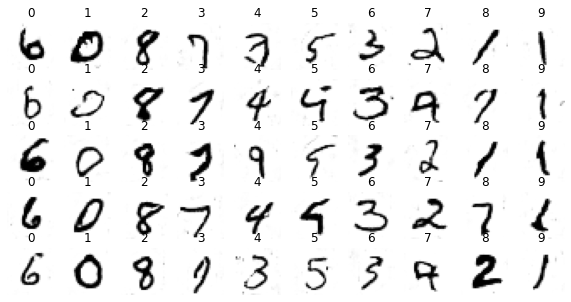

In [73]:
plotSome()

In [181]:
def eval_entropy():
    codes = [i % n_cat for i in range(50)]
    X, y, z = generate_fake_samples_and_z_from_cat(g_model, latent_dim, n_cat, codes)
    c = gan_model.predict(z)[1]
    return entropy(c, base=2)

In [182]:
ent = eval_entropy()
ent

array([2.3440807, 2.3557134, 2.328082 , 2.3310602, 2.377829 , 2.3378832,
       2.4007416, 2.3316112, 2.3108513, 2.6404378], dtype=float32)

In [183]:
np.mean(ent)

2.3758292

In [184]:
def onehot(i, s = 10, eps = 0):
    arr = [eps] * s
    arr[i] = 1 - (s - 1) * eps
    return arr

In [185]:
k = 100000
c = np.array([onehot(i % 10, 10, 1e-1) for i in range(k)])
np.sum(entropy(c, base=2))

166.09640474386055